In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(rc = {'figure.figsize':(20,16)})

In [2]:
test = pd.read_csv('test.csv') # Store our data

In [3]:
new = test.copy() # Creating a copy so that original data will be unaffected by future changes.

### Data Cleaning And Feature Engineering.

In [4]:
# We need to drop columns that will have marginal effect on our data, including ticket numbers and IDs.
new.drop(['device_token'], axis=1, inplace=True) # Empty
new.drop(['order_try_id_new','order_id_new', 'driver_device_uid_new', 'ticket_id_new'], axis=1, inplace=True) # Numbers
new.drop(['order_state', 'order_try_state', 'b_state'], axis=1, inplace=True)

#### Datetime

In [5]:
# We need to change the timestamp to readable date time: Days of the week and time of day.
new['date'] = pd.to_datetime(new['calc_created']).dt.day_name()
new['time'] = pd.to_datetime(new['calc_created']).dt.time


# We will write a function to turn the time strings to corresponding time of the day.
def time_of_day(Time):
    hour = int(str(Time)[:2])
    if (hour > 4) and (hour <= 8):
        return 'Early Morning'
    elif (hour > 8) and (hour <= 12 ):
        return 'Morning'
    elif (hour > 12) and (hour <= 16):
        return 'Noon'
    elif (hour > 16) and (hour <= 20) :
        return 'Evening'
    elif (hour > 20) and (hour <= 24):
        return 'Night'
    elif (hour <= 4):
        return 'Late Night'
    

# We then applied the function to our time column
new['time'] = new['time'].apply(time_of_day)

# Then we dropped the timestamps
new.drop('calc_created', axis=1, inplace=True)

## Feature Engineering...(General data).

In [6]:
# To properly understand the data, we will need to measure the differences in price, distances and time. Then we take percentages of them.
# Firstly, we calculate differences in distance, duration and price and add them as new columns.

distance_diff = new['distance'] - new['predicted_distance']
duration_diff = new['duration'] - new['predicted_duration']
price_diff = new['metered_price'] - new['upfront_price']

new['dist_diff'] = distance_diff
new['time_diff'] = duration_diff
new['price_diff'] = price_diff

# Then we turn them to percentages..showing relationships between predicted and actual values, in percentages. This helps reduce the effect of large data point since our data points have no units.
new['dist_gap'] = (new['dist_diff'] / new['predicted_distance']) * 100 
new['precision_acc'] = (new['price_diff'] / new['upfront_price']) * 100
new['time_gap'] = (new['time_diff'] / new['predicted_duration']) * 100

# We need a new column to measure the threshold Bolt uses. Metered_prices within 20% of predicted value are
# converted to upfront_prices so it means all prices 20% more or less than the upfront price are considered precise enough to be adopted.

precision = (new['price_diff'] / new['upfront_price']) * 100 
new['precision'] = abs(precision) # Different from precision% which will differentiate percentage gap between prices


### Exploratory Data Analysis....General data.

In [7]:
# We start analyzing the data.
new.head(10)

metered_price  upfront_price  distance  duration  gps_confidence  \
0           4.04           10.0      2839       700               1   
1           6.09            3.6      5698       493               1   
2           4.32            3.5      4426       695               1   
3       72871.72            NaN     49748      1400               0   
4       20032.50        19500.0     10273      5067               1   
5           6.11            6.3      4924       513               1   
6       20753.20        10500.0     10459      1874               1   
7           2.61            6.5      2020       412               1   
8       13600.50            NaN      9540      1917               1   
9           4.14            2.5      3845       720               1   

  entered_by  dest_change_number        prediction_price_type  \
0     client                   1                      upfront   
1     client                   1                      upfront   
2     client                   1                      upfront   
3     client                   2  upfront_destination_changed   
4     client                   1                      upfront   
5     client                   1                      upfront   
6     client                   1                      upfront   
7     client                   1                      upfront   
8     client                   1                   prediction   
9     client                   1                      upfront   

   predicted_distance  predicted_duration  ... fraud_score       date  \
0             13384.0              1091.0  ...     -1383.0     Sunday   
1              2286.0               360.0  ...         NaN   Saturday   
2              4101.0               433.0  ...      -166.0   Saturday   
3              3017.0               600.0  ...         NaN  Wednesday   
4             14236.0              2778.0  ...         NaN   Thursday   
5              4882.0               562.0  ...         NaN     Friday   
6              4892.0               698.0  ...         NaN     Sunday   
7              8545.0               888.0  ...     -2350.0     Monday   
8             11018.0              1914.0  ...         NaN   Thursday   
9              1883.0               298.0  ...     -5181.0     Friday   

            time dist_diff  time_diff  price_diff     dist_gap precision_acc  \
0     Late Night  -10545.0     -391.0       -5.96   -78.788105    -59.600000   
1     Late Night    3412.0      133.0        2.49   149.256343     69.166667   
2        Morning     325.0      262.0        0.82     7.924896     23.428571   
3  Early Morning   46731.0      800.0         NaN  1548.922771           NaN   
4        Evening   -3963.0     2289.0      532.50   -27.837876      2.730769   
5     Late Night      42.0      -49.0       -0.19     0.860303     -3.015873   
6  Early Morning    5567.0     1176.0    10253.20   113.798038     97.649524   
7        Evening   -6525.0     -476.0       -3.89   -76.360445    -59.846154   
8           Noon   -1478.0        3.0         NaN   -13.414413           NaN   
9        Morning    1962.0      422.0        1.64   104.195433     65.600000   

     time_gap  precision  
0  -35.838680  59.600000  
1   36.944444  69.166667  
2   60.508083  23.428571  
3  133.333333        NaN  
4   82.397408   2.730769  
5   -8.718861   3.015873  
6  168.481375  97.649524  
7  -53.603604  59.846154  
8    0.156740        NaN  
9  141.610738  65.600000  

[10 rows x 26 columns]

In [8]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4943 entries, 0 to 4942
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   metered_price          4923 non-null   float64
 1   upfront_price          3409 non-null   float64
 2   distance               4943 non-null   int64  
 3   duration               4943 non-null   int64  
 4   gps_confidence         4943 non-null   int64  
 5   entered_by             4943 non-null   object 
 6   dest_change_number     4943 non-null   int64  
 7   prediction_price_type  4923 non-null   object 
 8   predicted_distance     4923 non-null   float64
 9   predicted_duration     4923 non-null   float64
 10  change_reason_pricing  298 non-null    object 
 11  rider_app_version      4927 non-null   object 
 12  driver_app_version     4943 non-null   object 
 13  device_name            4943 non-null   object 
 14  eu_indicator           4943 non-null   int64  
 15  over

Our data has missing values in the upfront_pricing column which is a key feature.

#### Missing Values

In [9]:
# We need to remove missing values so we can have a more accurate understanding of overall pricing effectiveness.
# We will remove missing values from upfront_price column.

clean_data = new[new['upfront_price'].isna() == False]

In [10]:
clean_data.head(5)

metered_price  upfront_price  distance  duration  gps_confidence  \
0           4.04           10.0      2839       700               1   
1           6.09            3.6      5698       493               1   
2           4.32            3.5      4426       695               1   
4       20032.50        19500.0     10273      5067               1   
5           6.11            6.3      4924       513               1   

  entered_by  dest_change_number prediction_price_type  predicted_distance  \
0     client                   1               upfront             13384.0   
1     client                   1               upfront              2286.0   
2     client                   1               upfront              4101.0   
4     client                   1               upfront             14236.0   
5     client                   1               upfront              4882.0   

   predicted_duration  ... fraud_score      date        time dist_diff  \
0              1091.0  ...     -1383.0    Sunday  Late Night  -10545.0   
1               360.0  ...         NaN  Saturday  Late Night    3412.0   
2               433.0  ...      -166.0  Saturday     Morning     325.0   
4              2778.0  ...         NaN  Thursday     Evening   -3963.0   
5               562.0  ...         NaN    Friday  Late Night      42.0   

   time_diff  price_diff    dist_gap precision_acc   time_gap  precision  
0     -391.0       -5.96  -78.788105    -59.600000 -35.838680  59.600000  
1      133.0        2.49  149.256343     69.166667  36.944444  69.166667  
2      262.0        0.82    7.924896     23.428571  60.508083  23.428571  
4     2289.0      532.50  -27.837876      2.730769  82.397408   2.730769  
5      -49.0       -0.19    0.860303     -3.015873  -8.718861   3.015873  

[5 rows x 26 columns]

In [11]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3409 entries, 0 to 4942
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   metered_price          3409 non-null   float64
 1   upfront_price          3409 non-null   float64
 2   distance               3409 non-null   int64  
 3   duration               3409 non-null   int64  
 4   gps_confidence         3409 non-null   int64  
 5   entered_by             3409 non-null   object 
 6   dest_change_number     3409 non-null   int64  
 7   prediction_price_type  3409 non-null   object 
 8   predicted_distance     3409 non-null   float64
 9   predicted_duration     3409 non-null   float64
 10  change_reason_pricing  32 non-null     object 
 11  rider_app_version      3409 non-null   object 
 12  driver_app_version     3409 non-null   object 
 13  device_name            3409 non-null   object 
 14  eu_indicator           3409 non-null   int64  
 15  over

We can now do general EDA.

In [12]:
# # We examine the average precision% of our dataset and explore some relationships.
print(clean_data.precision_acc.mean())
print(clean_data.dist_gap.mean())
print(clean_data.time_gap.mean())

18.650938689480583
16.626579514661927
29.272215902109338


All rides in our data had 18.6% more price, 16.6% more distance and 29.2% more time than predicted.

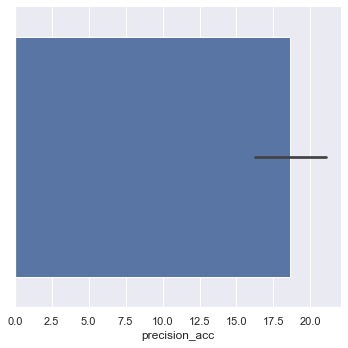

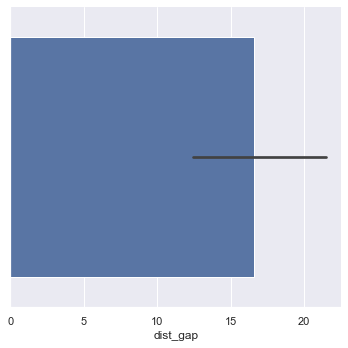

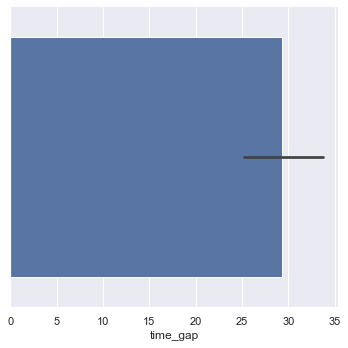

In [13]:
# We can confirm here.
sns.catplot(x='precision_acc', data=clean_data, kind= 'bar', estimator= np.mean)
sns.catplot(x='dist_gap', data=clean_data, kind= 'bar', estimator= np.mean)
sns.catplot(x='time_gap', data=clean_data, kind= 'bar', estimator= np.mean)

In [175]:
get_std_cv(clean_data)

standard_deviation for precision data is:  68.10205827242865
coefficient of variation for precision data is:  3.651401112097337
standard_deviation for distance data is:  134.24716837335333
coefficient of variation for distance precision data is:  8.074250524888132
standard_deviation for duration data is:  121.6829468920357
coefficient of variation for duration precision data is:  4.156943474964849


This shows our standard deviation is high. Our mean isn't entirely reliable because a lot of data skewed the value. We have to break the dataset into chunks and analyze to get a better picture.

<AxesSubplot:xlabel='time', ylabel='count'>

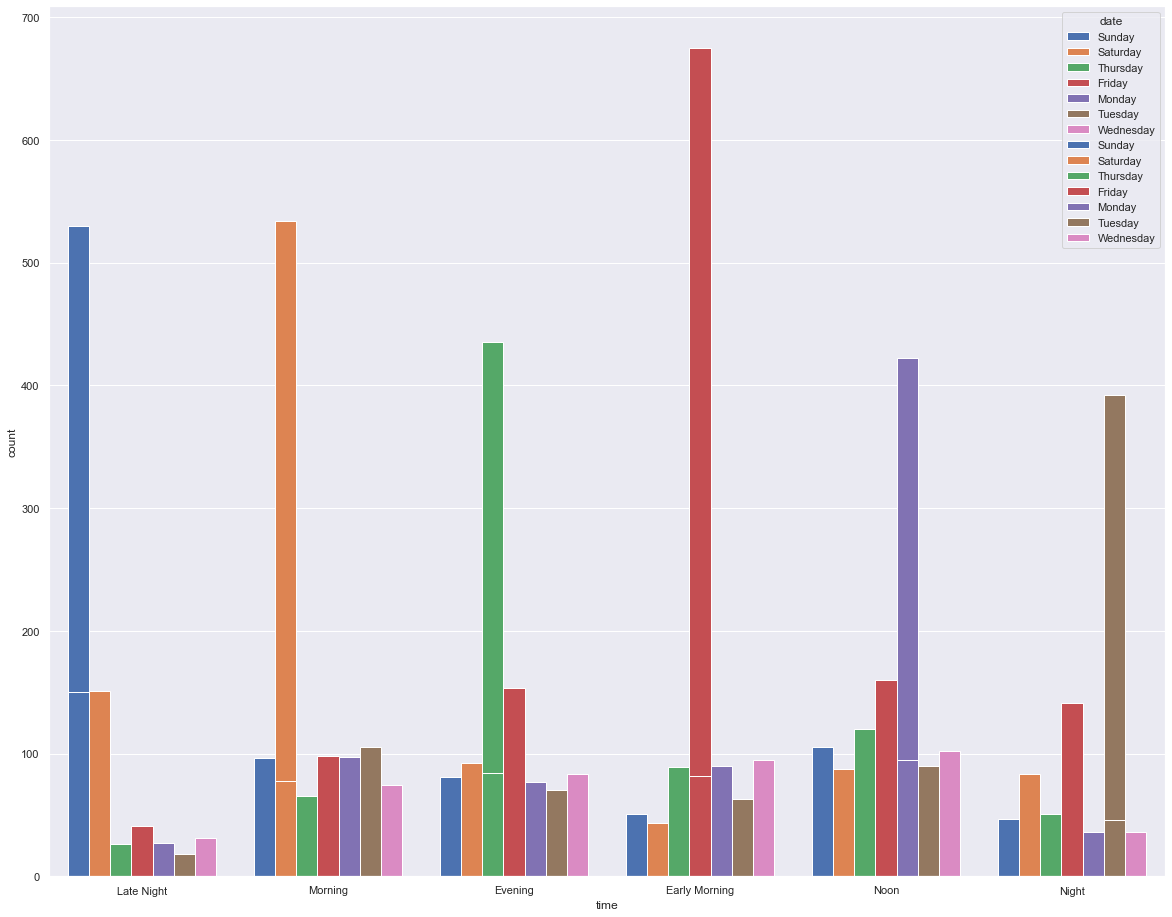

In [14]:
# We check the dates with most trips.
sns.countplot(x= 'date', data= clean_data, hue='date', saturation=1)
sns.countplot(x= 'time', data= clean_data, hue='date', saturation=1)

Most trips happened during the weekend and in the afternoon, from 12pm to 4pm, especially on Friday. 

In [15]:
# Some trips had low GPS confidence while others have high GPS confidence. We examine this.
# We write a function to evaluate the precision, distances and duration% for each binary data our dataset

def print_percentage_differences(col):
    data = clean_data[clean_data[col]==0]
    data2 = clean_data[clean_data[col]==1]
    print('Precision% for {} = 0 is: '.format(col), data.precision_acc.mean())
    print('Precision% for {} = 1 is: '.format(col), data2.precision_acc.mean())
    print('Distance% for {} = 0 is: '.format(col), data.dist_gap.mean())
    print('Distance% for {} = 1 is: '.format(col), data2.dist_gap.mean())
    print('Duration% for {} = 0 is: '.format(col), data.time_gap.mean())
    print('Duration% for {} = 1 is: '.format(col), data2.time_gap.mean())
    


In [16]:
# We apply our function to check percentage differences for several binary data.
# GPS confidence
print_percentage_differences('gps_confidence')

Precision% for gps_confidence = 0 is:  73.92923941314025
Precision% for gps_confidence = 1 is:  11.879938403276654
Distance% for gps_confidence = 0 is:  76.41524217832956
Distance% for gps_confidence = 1 is:  9.30310815776884
Duration% for gps_confidence = 0 is:  73.77518916356426
Duration% for gps_confidence = 1 is:  23.821077919474714


Rides with low GPS confidence cost 73% more, took 76% more distance, and lasted 73.7% more than predicted values for price, distance and duration while rides with high GPS confidence had 11% more price, 9% more distance and 23% more time.




This shows that GPS confidence generally affected ride estimation and upfront_pricing could be improved by checking GPS confidence and adjusting the algorithm by a factor of 1.5 to 3.0 for distance and a factor of 1.1 to 1.5 for duration.

In [17]:
# We can check data for eu-indicators
print_percentage_differences('eu_indicator')

Precision% for eu_indicator = 0 is:  34.77717045365428
Precision% for eu_indicator = 1 is:  13.022392422760673
Distance% for eu_indicator = 0 is:  18.95125664875736
Distance% for eu_indicator = 1 is:  15.815196359825327
Duration% for eu_indicator = 0 is:  50.62157774487014
Duration% for eu_indicator = 1 is:  21.82063808441438


Rides within the EU cost 13% more price, took 15.8% more distance and 21.8% more time while rides outside the EU cost 34.7% more price, took 18.9% more distance and 50.6% more time than predicted. This is also because there were more rides in the EU with good GPS confidence than rides outside the EU.

In [18]:
# We check for complaints about overpaying for rides.
print_percentage_differences('overpaid_ride_ticket')

Precision% for overpaid_ride_ticket = 0 is:  16.976832311958315
Precision% for overpaid_ride_ticket = 1 is:  69.81969009874912
Distance% for overpaid_ride_ticket = 0 is:  15.468174711594218
Distance% for overpaid_ride_ticket = 1 is:  52.03300780101809
Duration% for overpaid_ride_ticket = 0 is:  28.450293870207535
Duration% for overpaid_ride_ticket = 1 is:  54.39411059940359


Trips where riders complained about overpaying had 69.8% more price, 52% more distance and 54% more time than predicted while rides without complaints had 16.9% more price, 15.4% more distance and 28.4% more time. This means a lot of their complaints were valid since they paid 1.3% more price per % increase in distance than riders who didn't complained. I examined why this happened in details in the more specific analysis.

In [19]:
# We check which rides and devices had the most issues with GPS.
print(clean_data[clean_data['gps_confidence']==0].device_name.mode())
print(clean_data[clean_data['gps_confidence']==1].device_name.mode())

0    TECNO MOBILE LIMITED TECNO B1p
dtype: object
0    iPhone8,1
dtype: object


The most instances of GPS challenges happened to drivers with Techno B1p while good GPS confidence occurred more for drivers with iPhone 8.1

<AxesSubplot:xlabel='precision_acc', ylabel='Density'>

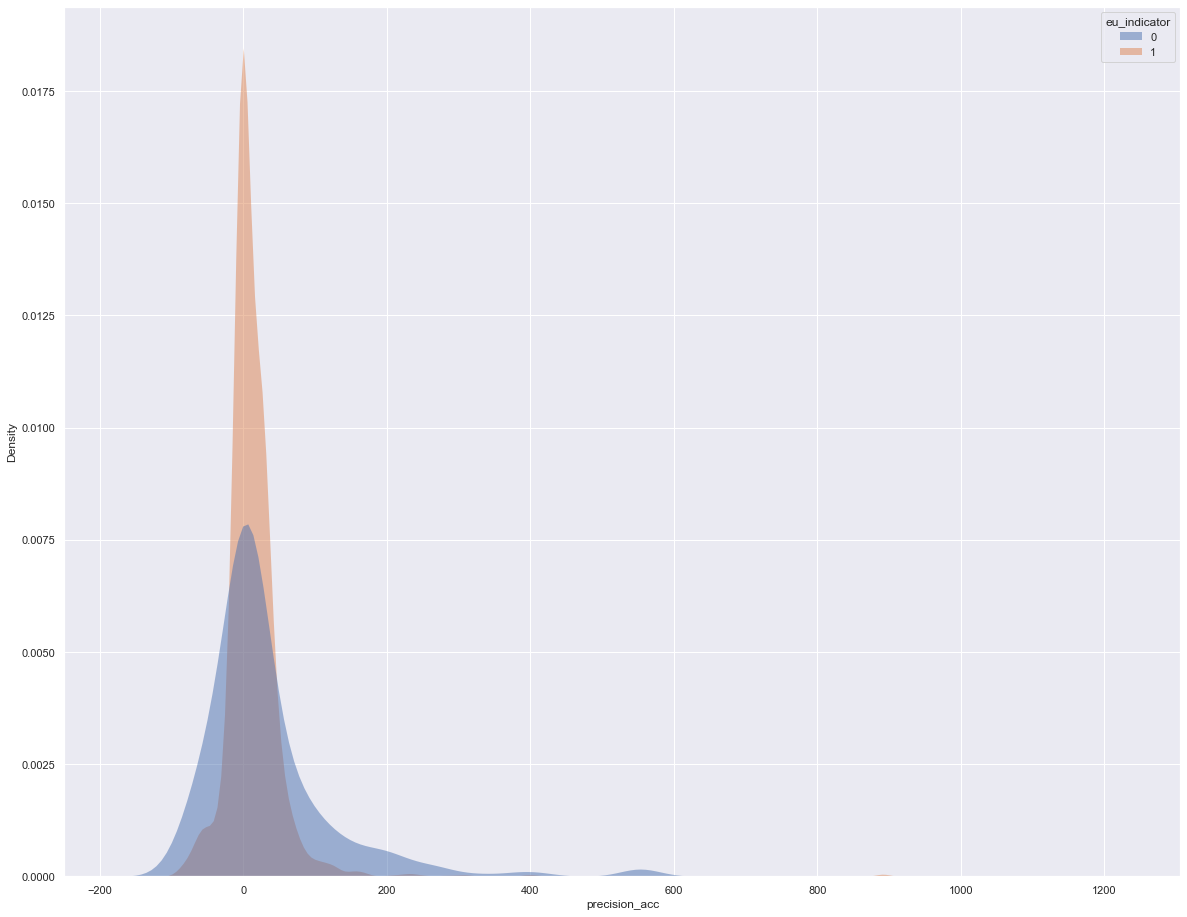

In [223]:
sns.kdeplot(
   data=clean_data, x="precision_acc", hue="eu_indicator",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0,
)

Rides in the EU were generally more precise than rides outside.

In [177]:
# We evaluate rides that meet the threshold and rides that don't.
precise_rides = clean_data[clean_data['precision'] <= 20]
imprecise_rides = clean_data[clean_data['precision'] > 20]

In [178]:
get_sum(precise_rides)

Precision% for data is:  0.22715628269670735
Distance% for data is:  -2.552859593222743
Duration% for data is:  3.7826735155432396


These rides on the average had 0.2% more price, 2.5% less distance and 3.7% more time than predicted.

<AxesSubplot:xlabel='precision_acc', ylabel='Density'>

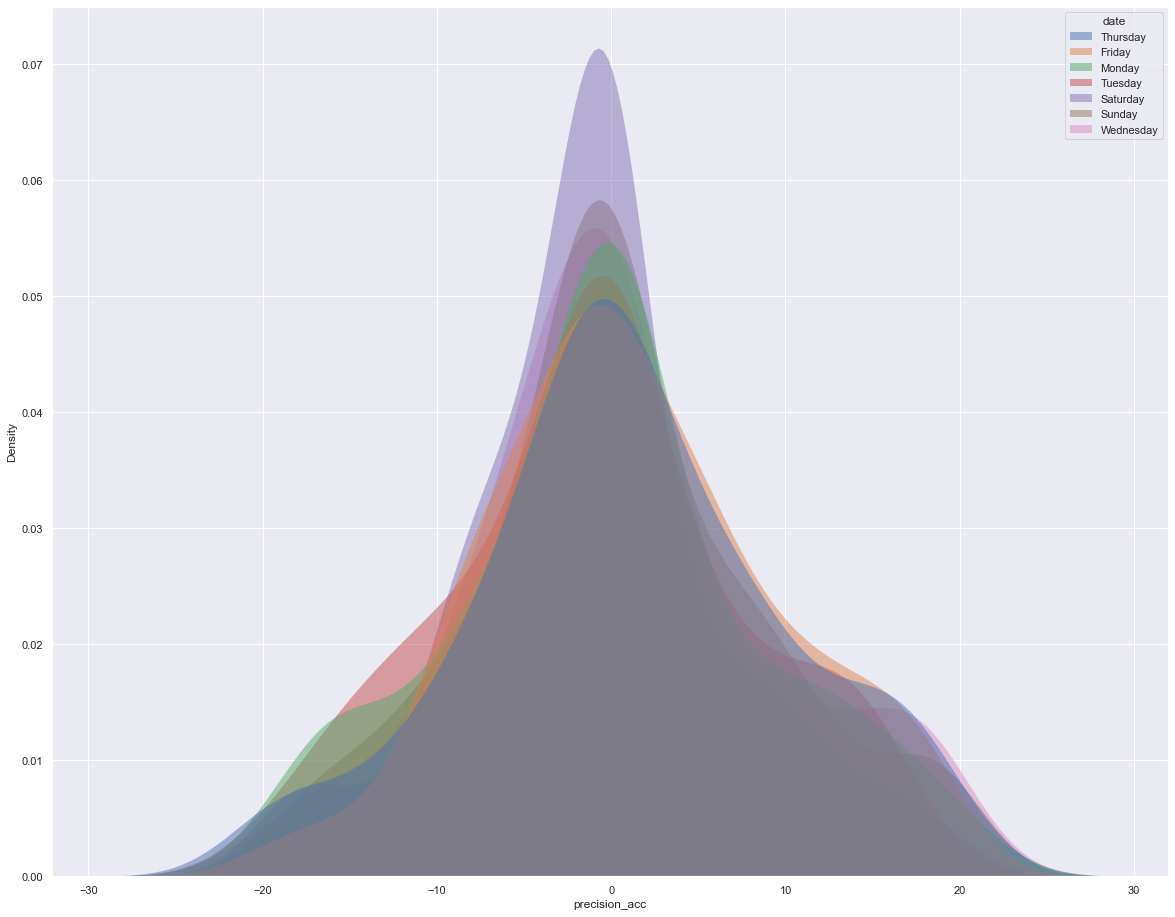

In [204]:
sns.kdeplot(
   data=precise_rides, x="precision_acc", hue="date",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0,
)

The more precise rides happened on weekends.

<AxesSubplot:xlabel='precision_acc', ylabel='Proportion'>

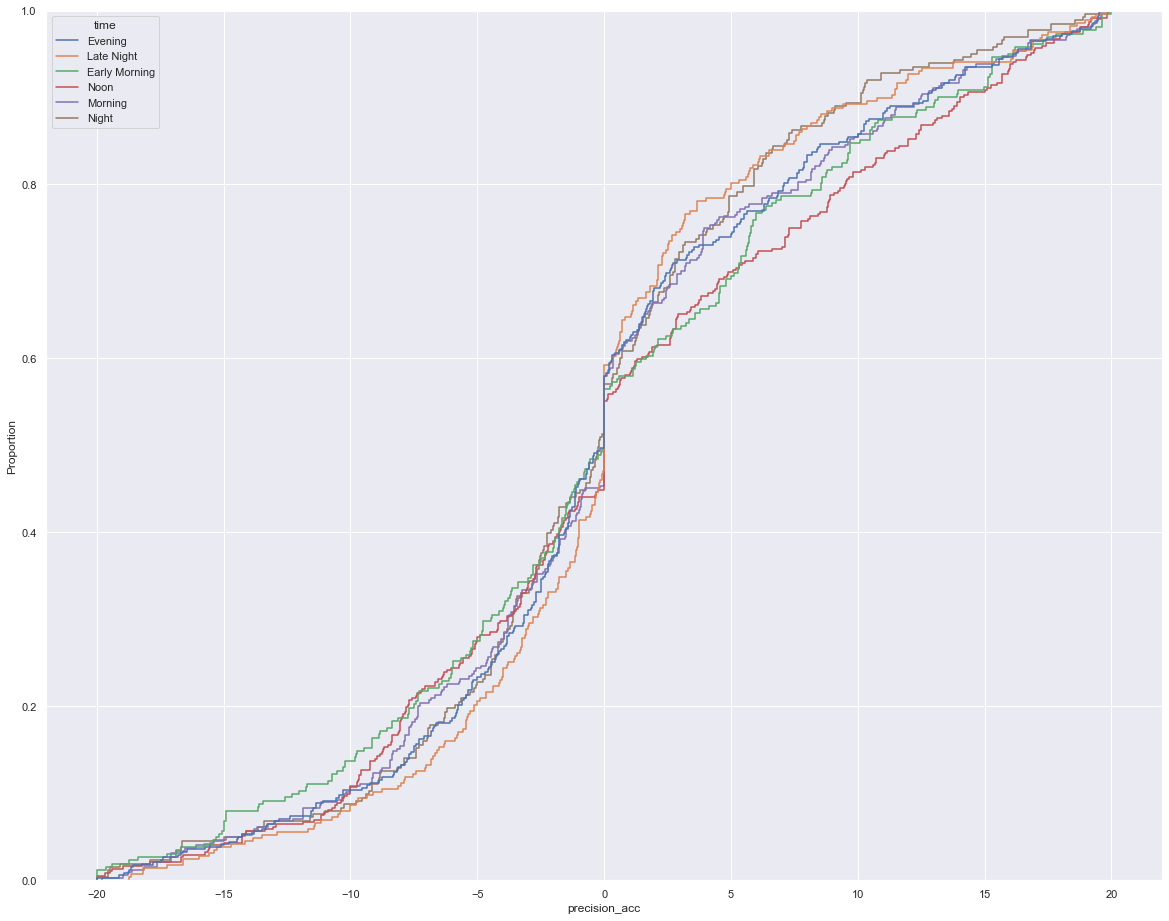

In [205]:
# We look at the time of the day with the best precision
sns.ecdfplot(
   data=precise_rides, x="precision_acc", hue="time")
  

<AxesSubplot:xlabel='precision_acc', ylabel='Density'>

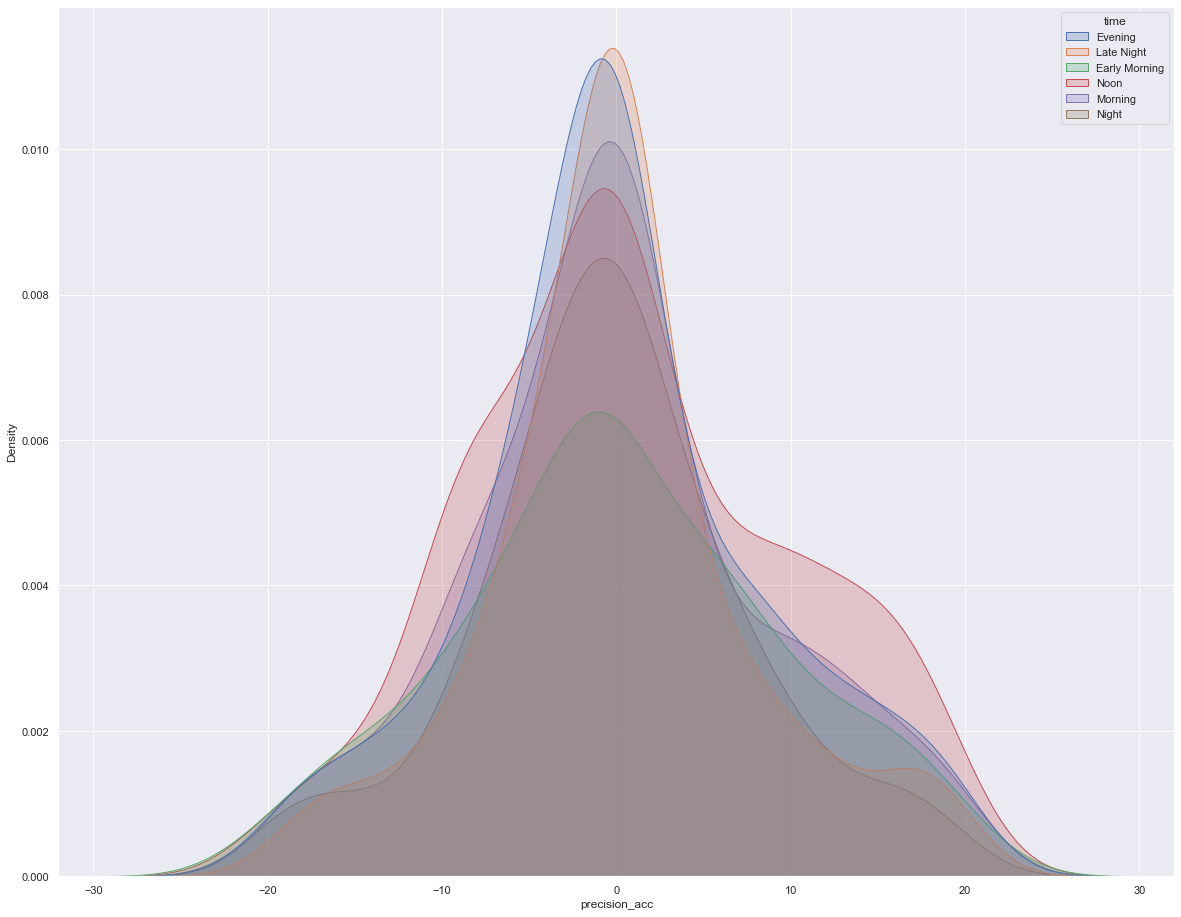

In [202]:
sns.kdeplot(
   data=precise_rides, x="precision_acc", hue="eu_indicator", fill=True)
  

The more precise rides happened in the early morning, evening and noon.

<AxesSubplot:xlabel='precision', ylabel='dist_gap'>

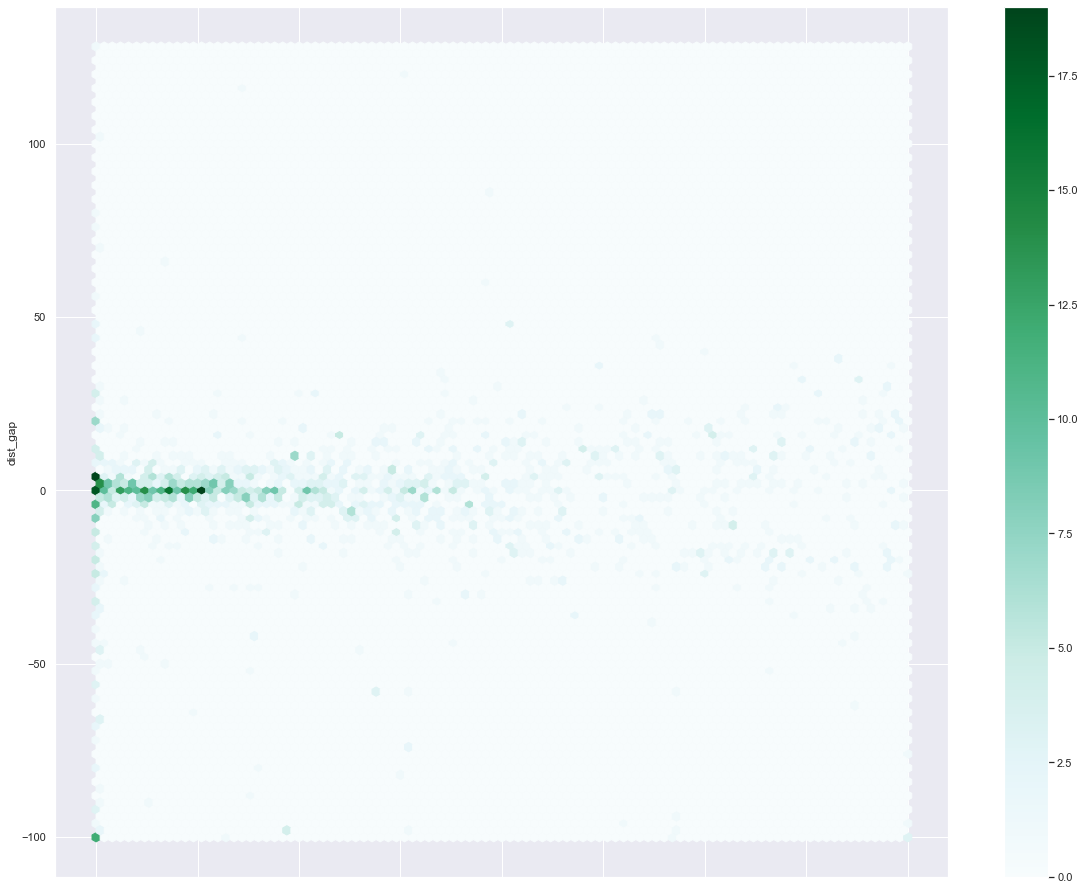

In [203]:
precise_rides.plot.hexbin('precision', 'dist_gap')

<AxesSubplot:xlabel='precision_acc', ylabel='Density'>

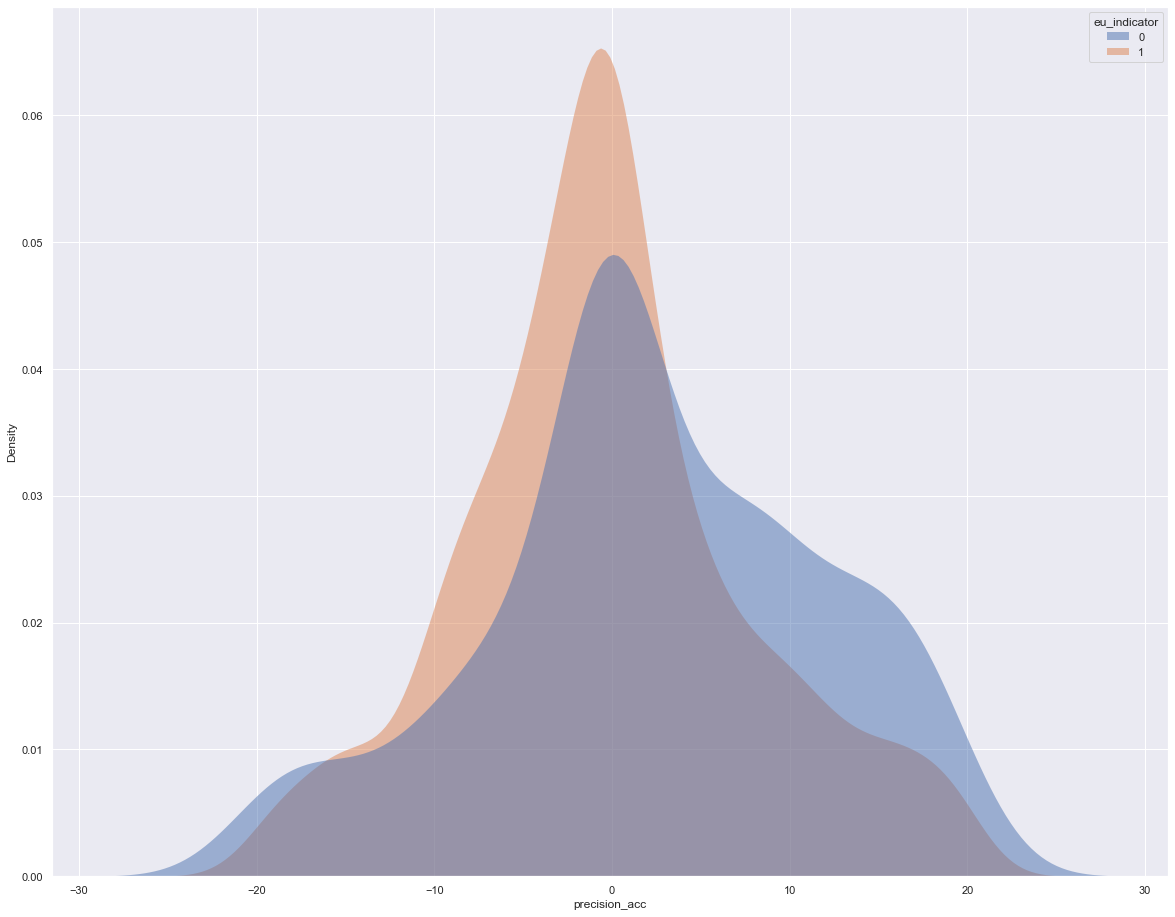

In [222]:
sns.kdeplot(
   data=precise_rides, x="precision_acc", hue="eu_indicator",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0,
)

Rides in the EU were generally more precise than rides outside the EU.

In [225]:
precise_rides.corr(method='pearson')

metered_price  upfront_price  distance  duration  \
metered_price              1.000000       0.995739  0.236022  0.489252   
upfront_price              0.995739       1.000000  0.230627  0.480250   
distance                   0.236022       0.230627  1.000000  0.781607   
duration                   0.489252       0.480250  0.781607  1.000000   
gps_confidence            -0.202890      -0.213697 -0.068612 -0.157348   
dest_change_number        -0.022095      -0.021649  0.113962  0.118386   
predicted_distance         0.241967       0.241536  0.992306  0.786474   
predicted_duration         0.418826       0.419278  0.853523  0.926008   
eu_indicator              -0.645245      -0.649277 -0.003861 -0.316607   
overpaid_ride_ticket       0.235948       0.246544  0.018449  0.091419   
fraud_score               -0.106330      -0.106910  0.070960  0.049379   
dist_diff                  0.015328      -0.024080  0.316869  0.164311   
time_diff                  0.399292       0.376105  0.279826  0.680308   
price_diff                 0.394994       0.308589  0.136946  0.262161   
dist_gap                  -0.009980      -0.028367  0.172226  0.142040   
precision_acc              0.140902       0.104645  0.174669  0.304705   
time_gap                   0.092657       0.086206  0.029255  0.163769   
precision                  0.120025       0.112692  0.075572  0.229251   

                      gps_confidence  dest_change_number  predicted_distance  \
metered_price              -0.202890           -0.022095            0.241967   
upfront_price              -0.213697           -0.021649            0.241536   
distance                   -0.068612            0.113962            0.992306   
duration                   -0.157348            0.118386            0.786474   
gps_confidence              1.000000           -0.041620           -0.068665   
dest_change_number         -0.041620            1.000000            0.111176   
predicted_distance         -0.068665            0.111176            1.000000   
predicted_duration         -0.168511            0.095250            0.861094   
eu_indicator                0.255502            0.032239           -0.021303   
overpaid_ride_ticket       -0.095437           -0.020250            0.026686   
fraud_score                -0.049501            0.040191            0.069452   
dist_diff                  -0.017294            0.050735            0.197002   
time_diff                  -0.062768            0.108451            0.277189   
price_diff                  0.036132           -0.012233            0.089607   
dist_gap                   -0.002838            0.012491            0.088454   
precision_acc              -0.029552            0.088833            0.104623   
time_gap                   -0.006627            0.033342            0.020463   
precision                  -0.096570            0.074545            0.069774   

                      predicted_duration  eu_indicator  overpaid_ride_ticket  \
metered_price                   0.418826     -0.645245              0.235948   
upfront_price                   0.419278     -0.649277              0.246544   
distance                        0.853523     -0.003861              0.018449   
duration                        0.926008     -0.316607              0.091419   
gps_confidence                 -0.168511      0.255502             -0.095437   
dest_change_number              0.095250      0.032239             -0.020250   
predicted_distance              0.861094     -0.021303              0.026686   
predicted_duration              1.000000     -0.248123              0.099957   
eu_indicator                   -0.248123      1.000000             -0.275182   
overpaid_ride_ticket            0.099957     -0.275182              1.000000   
fraud_score                     0.053773      0.057570                   NaN   
dist_diff                       0.162148      0.132624             -0.058342   
time_diff                       0.353289     -0.302871

Both metered and upfront prices correlated more wih actual ride durations and predicted distance.

####  For imprecise_rides

In [227]:
# We check the properties
get_sum(imprecise_rides)

Precision% for data is:  40.41056909442182
Distance% for data is:  39.278687379764335
Duration% for data is:  59.37694734523224


These rides on the average had 40% more price, 39% less distance and 59% more time than predicted.

We check for rides within 20% distances in either direction

In [229]:
rides_within_20 = imprecise_rides[imprecise_rides['dist_gap'] > -20]
rides_within_20 = rides_within_20[rides_within_20['dist_gap'] < 20]

In [233]:
get_sum(rides_within_20)

Precision% for data is:  30.116231642764365
Distance% for data is:  6.287691958092558
Duration% for data is:  68.86264908502503


The rides cost 30% less than predicted, 6% more distance and 68.8% more time than predicted

In [235]:
print_percentage_differences(rides_within_20, 'gps_confidence')

Precision% for gps_confidence = 0 is:  35.163978315998015
Precision% for gps_confidence = 1 is:  29.693986673900703
Distance% for gps_confidence = 0 is:  3.6680318343909777
Distance% for gps_confidence = 1 is:  6.506827025474438
Duration% for gps_confidence = 0 is:  130.42758569965707
Duration% for gps_confidence = 1 is:  63.7127304328505


Trips with good GPS confidence cost 29% more, took 6.5% more distance and 63% more time than predicted compared to the 35% more cost, 3.6% more distance and 130% more time that trips with low confidence had. 

GPS confidence is crucial to improving pricing precision.

In [236]:
print_percentage_differences(rides_within_20, 'eu_indicator')

Precision% for eu_indicator = 0 is:  34.25865941680489
Precision% for eu_indicator = 1 is:  29.011584236353542
Distance% for eu_indicator = 0 is:  7.060914090345571
Distance% for eu_indicator = 1 is:  6.08149938949175
Duration% for eu_indicator = 0 is:  129.4593888148971
Duration% for eu_indicator = 1 is:  52.70351849039253


Trips within the EU cost 29% more, took 6% more distance and 52% more time than predicted compared to the 34% more cost, 7% more distance and 129% more time that trips outside the EU had.

The pricing model needs to improve for trips outside the EU. 

<AxesSubplot:>

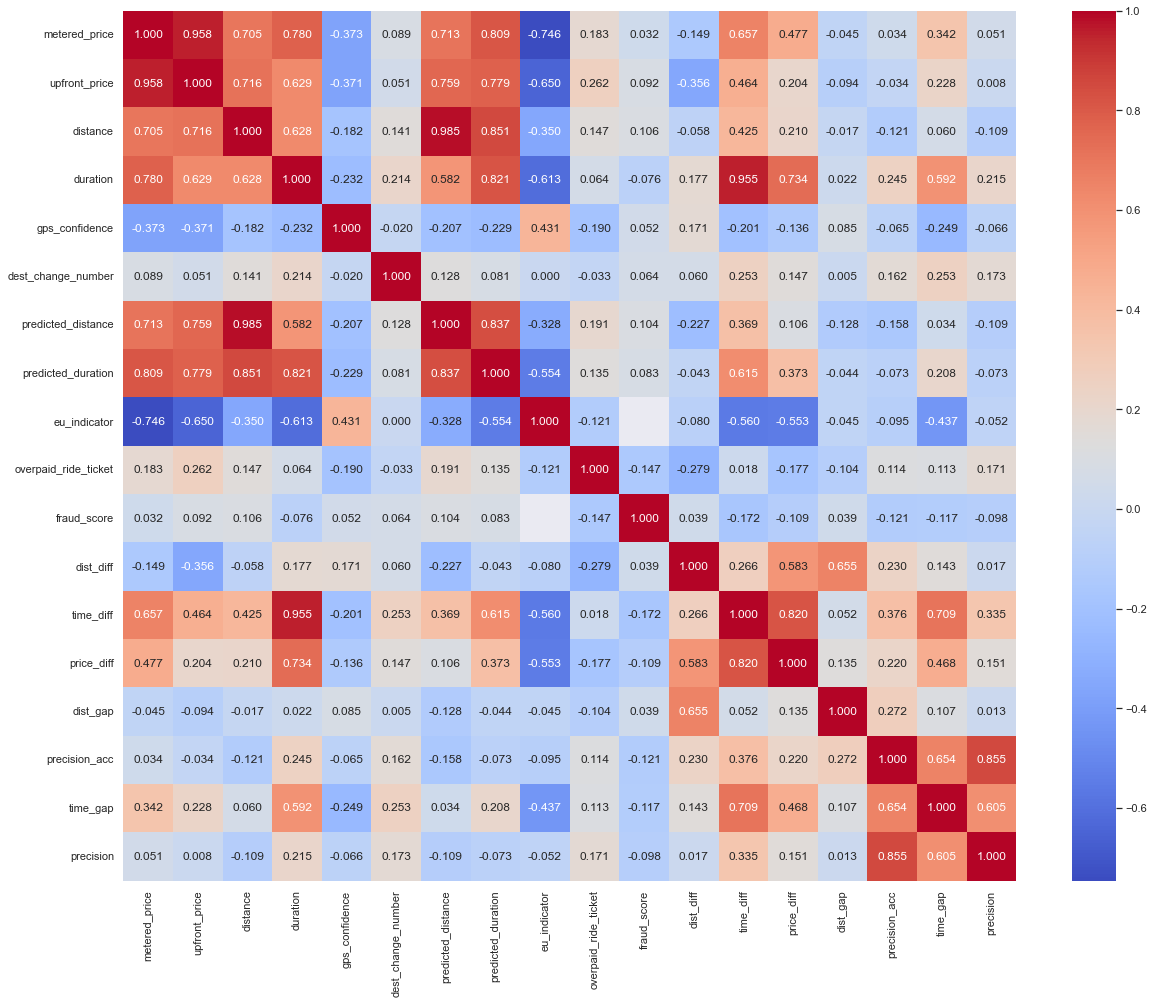

In [239]:
sns.heatmap(rides_within_20.corr(),annot=True,
                 fmt=".3f",
                 cmap = 'coolwarm')

These rides correlated more with both predicted distance and predicted duration. The algorithm needs to improve its duration factor especially for areas with low GPS confidence and outside the EU.

#### Exploratory Data Analysis...Categorized.

In [20]:
# Now we break rides into smaller units and analyze each of them to identify patterns that could improve business policies.
# We start with rides priced 1000 or less.
Rides_less_than_1000 = new[new['upfront_price'] <= 1000]
Accurate_rides = Rides_less_than_1000[Rides_less_than_1000['precision'] <= 20] # These are rides in which metered price switched to upfront_price. We analyze them.


In [21]:
# Some general analysis of this category.
print('Precision% for rides with less than 1000 upfront pricing is: ', Rides_less_than_1000.precision_acc.mean())
print('Distance% for rides with less than 1000 upfront pricing is: ', Rides_less_than_1000.dist_gap.mean())
print('Duration% for rides with less than 1000 upfront pricing is: ', Rides_less_than_1000.time_gap.mean())

Precision% for rides with less than 1000 upfront pricing is:  13.022392422760673
Distance% for rides with less than 1000 upfront pricing is:  15.815196359825327
Duration% for rides with less than 1000 upfront pricing is:  21.82063808441438


These rides on the average had 13% more price, 15% more distance and 21% more time than predicted.

In [22]:
# We analyze rides that met the threshold. This is to understand their unique properties.
print('Precision% for rides with less than 1000 upfront pricing and within threshold is: ', Accurate_rides.precision_acc.mean())
print('Distance% for rides with less than 1000 upfront pricing and within threshold is: ', Accurate_rides.dist_gap.mean())
print('Duration% for rides with less than 1000 upfront pricing and within threshold is: ', Accurate_rides.time_gap.mean())

Precision% for rides with less than 1000 upfront pricing and within threshold is:  -0.3153422632864918
Distance% for rides with less than 1000 upfront pricing and within threshold is:  -1.0296219206931272
Duration% for rides with less than 1000 upfront pricing and within threshold is:  0.5094949986205044


For rides within this category with the metered price 20% or less from the upfront price, trips cost 0.3% less,took 1% less distance and 0.5% more time than predicted. That's significant accuracy.

<AxesSubplot:xlabel='date', ylabel='count'>

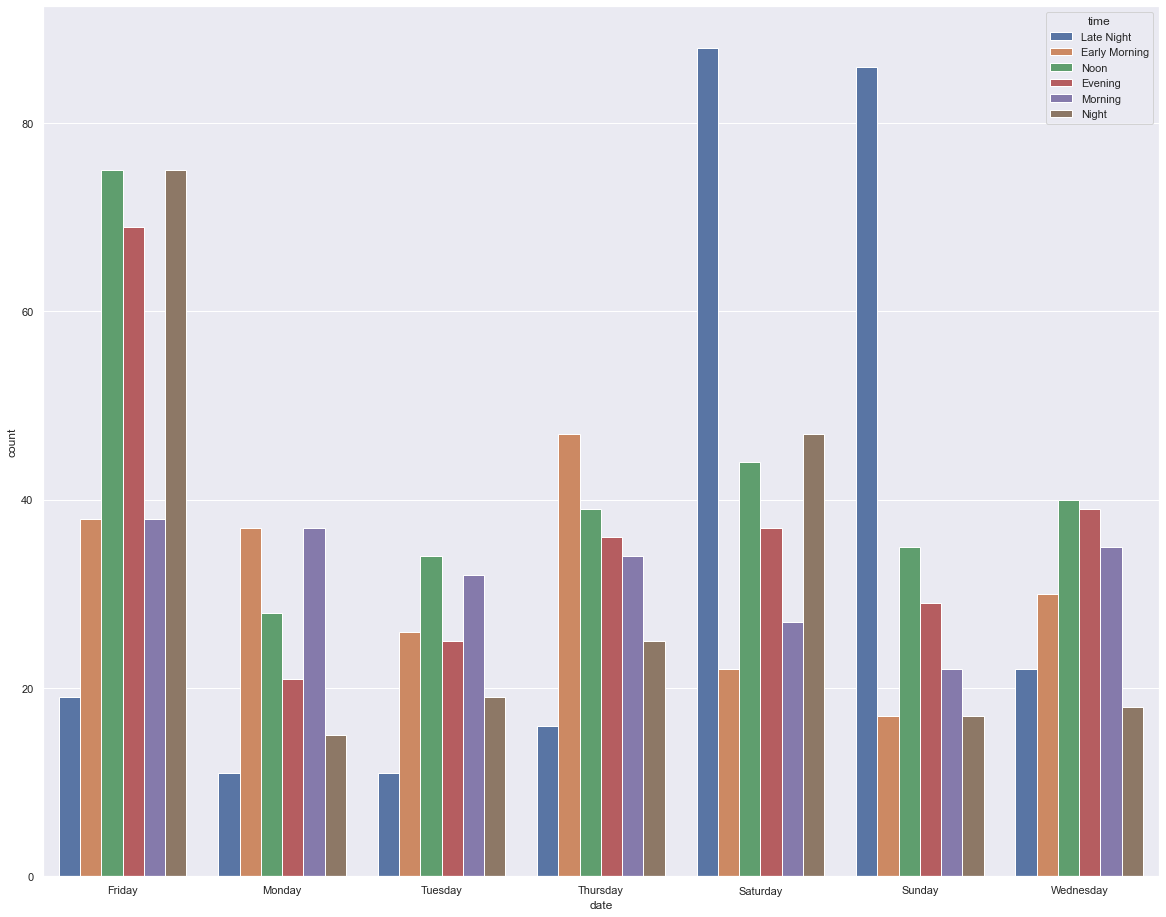

In [23]:
sns.countplot(x='date', data=Accurate_rides, hue='time')

More trips happened on weekends and late nights on Saturday and Sunday. Noon had more trips on the average.

In [24]:
# We adjust our function to accept dataframes as arguments too.
def print_percentage_differences(DF, col):
    data = DF[DF[col]==0]
    data2 = DF[DF[col]==1]
    print('Precision% for {} = 0 is: '.format(col), data.precision_acc.mean())
    print('Precision% for {} = 1 is: '.format(col), data2.precision_acc.mean())
    print('Distance% for {} = 0 is: '.format(col), data.dist_gap.mean())
    print('Distance% for {} = 1 is: '.format(col), data2.dist_gap.mean())
    print('Duration% for {} = 0 is: '.format(col), data.time_gap.mean())
    print('Duration% for {} = 1 is: '.format(col), data2.time_gap.mean())

In [25]:
# We check percentage differences for accurate rides.
print_percentage_differences(Accurate_rides, 'gps_confidence')

Precision% for gps_confidence = 0 is:  3.129670089604922
Precision% for gps_confidence = 1 is:  -0.41973657701047395
Distance% for gps_confidence = 0 is:  5.007642617803523
Distance% for gps_confidence = 1 is:  -1.2125693309506027
Duration% for gps_confidence = 0 is:  3.497741579394808
Duration% for gps_confidence = 1 is:  0.4189420719303747


Rides with low GPS confidence cost 3% more than predicted, took 5% more distance and 3% more time while rides with good gps confidence had 0.4% less price, 1.2% less distance and took 0.4% more time. Again, GPS confidence affected rides.

<AxesSubplot:xlabel='date', ylabel='count'>

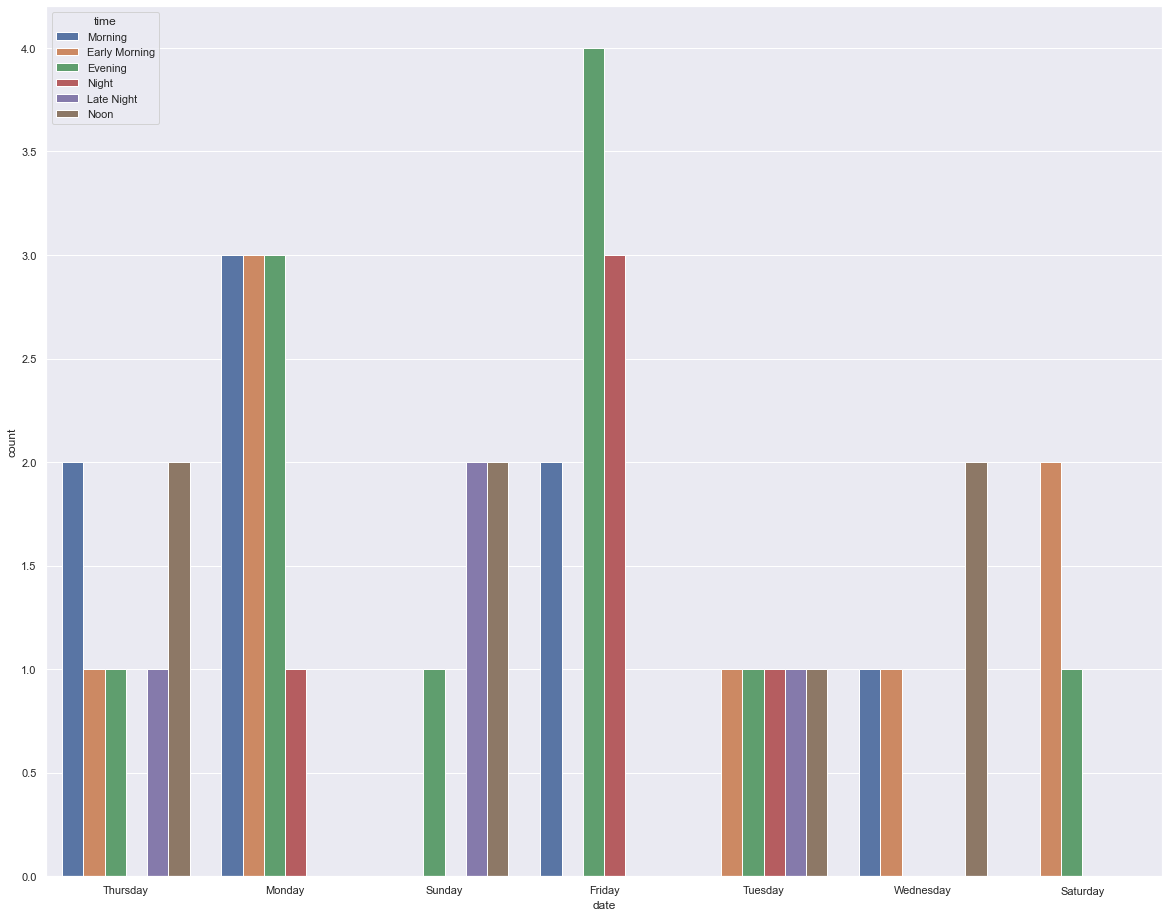

In [26]:
sns.countplot(x='date', data=Accurate_rides[Accurate_rides['gps_confidence']==0], hue='time')

<AxesSubplot:xlabel='date', ylabel='count'>

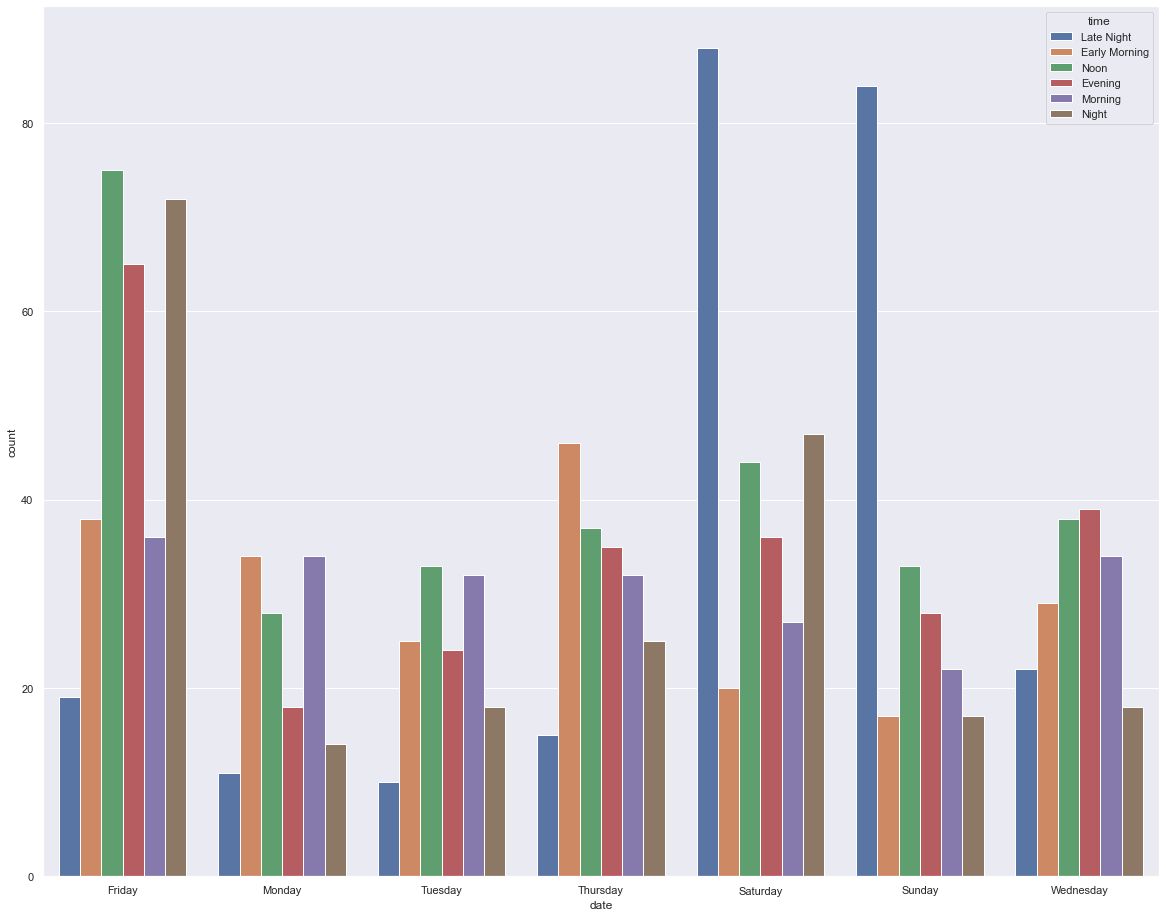

In [27]:
sns.countplot(x='date', data=Accurate_rides[Accurate_rides['gps_confidence']==1], hue='time')

Rides without gps confidence happened in the evening more than any other time while rides with gps confidence happened at noon more.

<AxesSubplot:xlabel='precision_acc', ylabel='Density'>

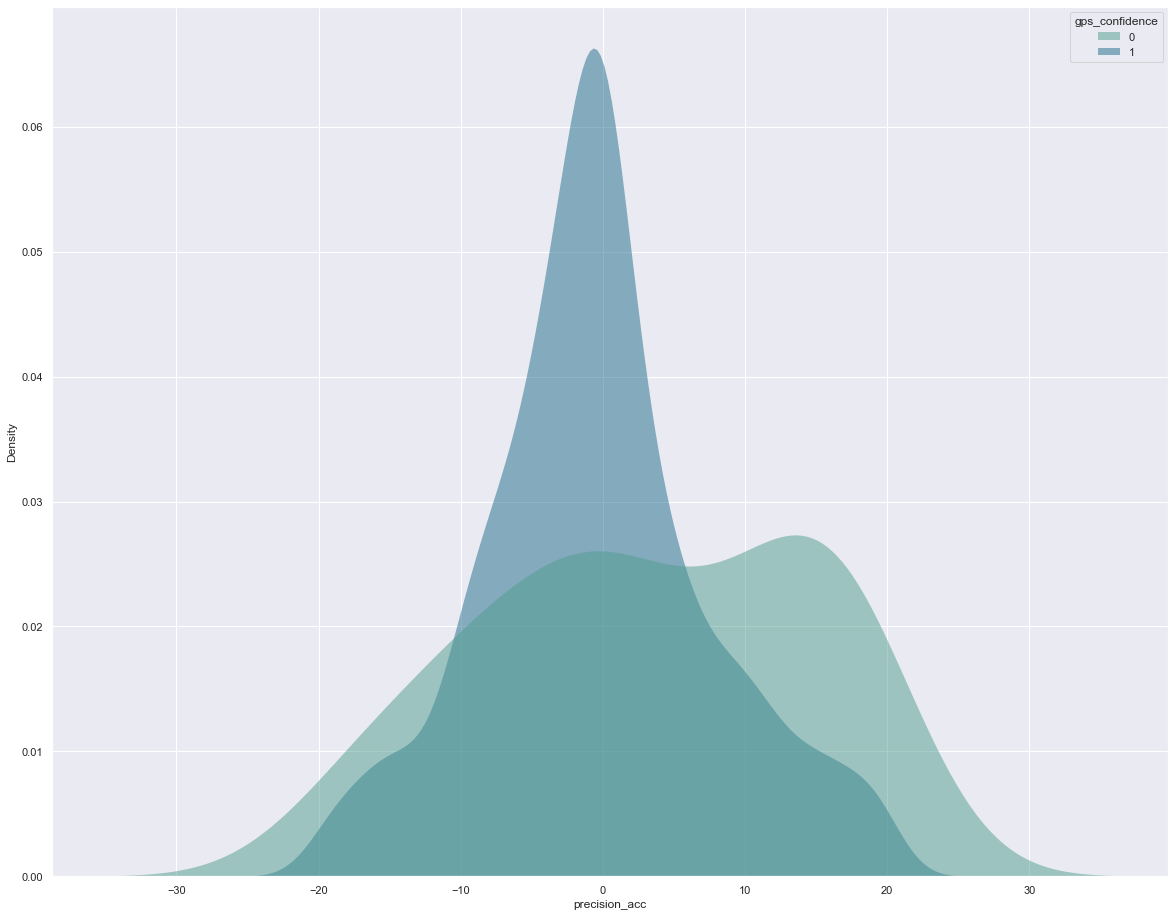

In [28]:
# We set a benchmark for their precision by evaluating their probability distribution using KDE.

sns.kdeplot(
   data=Accurate_rides, x="precision_acc", hue="gps_confidence",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,
)

We can see that rides with good GPS confidence had more precision than rides with low confidence.

<AxesSubplot:>

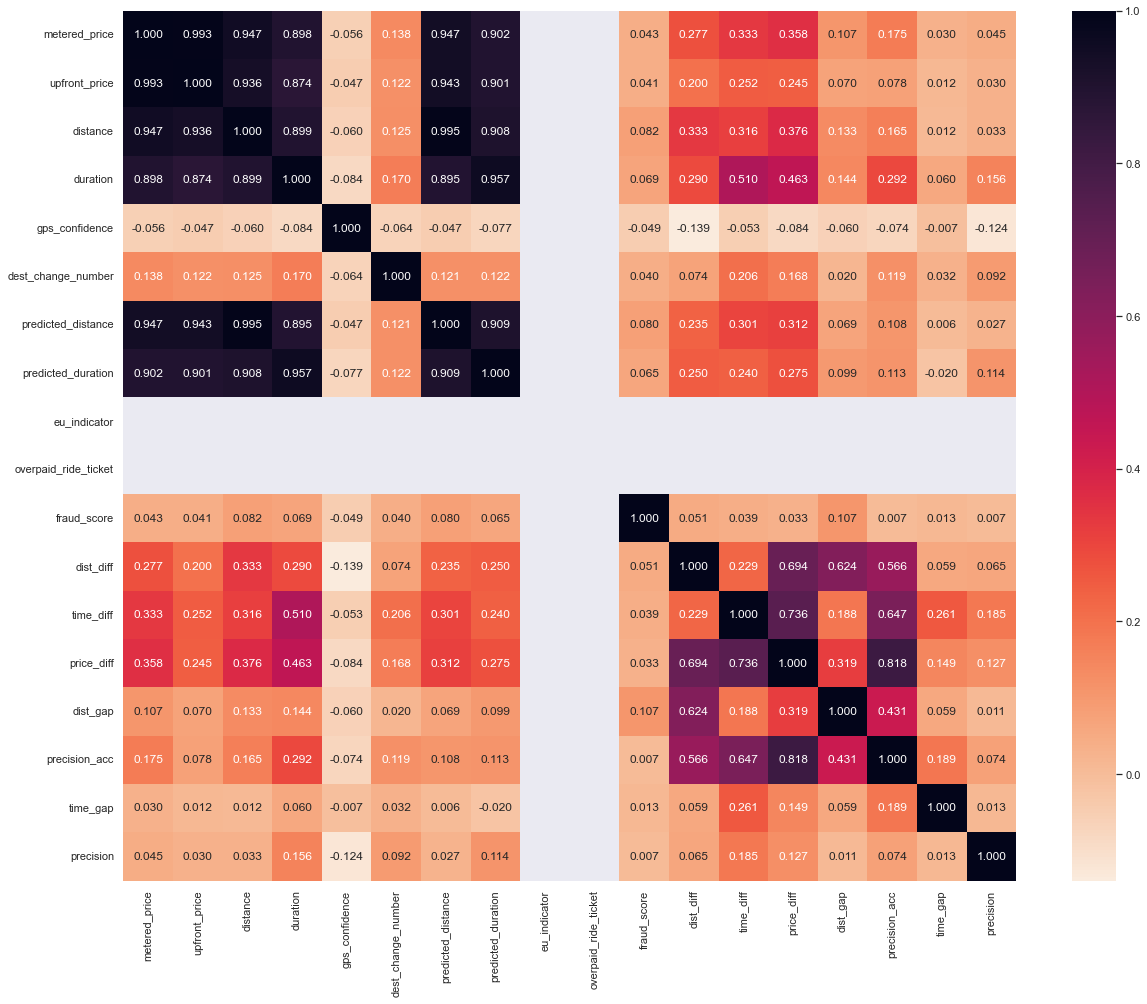

In [29]:
sns.heatmap(Accurate_rides.corr(),annot=True,
                 fmt=".3f",
                 cmap = sns.cm.rocket_r)

Without GPS confidence, metered_price and upfront price correlated more with both predicted distance and predicted duration over actual distance and duration but rides with gps confidence had metered_price correlating more with actual distance, reflecting the influence of accurate GPS measurements on the eventual price of the trip.

#### Rides costing 1000 or less in which metered price was at least 20% less than the upfront price

In [30]:
# We first isolate rides outside the standard threshold
Rides_outside_threshold = Rides_less_than_1000[Rides_less_than_1000['precision'] > 20]


In [138]:
def get_sum(df):
    print('Precision% for data is: ', df.precision_acc.mean())
    print('Distance% for data is: ', df.dist_gap.mean())
    print('Duration% for data is: ', df.time_gap.mean())
    
def get_std_cv(df):
    print('standard_deviation for precision data is: ', df.precision_acc.std())
    print('coefficient of variation for precision data is: ', (df.precision_acc.std()/ df.precision_acc.mean()))
    print('standard_deviation for distance data is: ', df.dist_gap.std())
    print('coefficient of variation for distance precision data is: ', (df.dist_gap.std()/ df.dist_gap.mean()))
    print('standard_deviation for duration data is: ', df.time_gap.std())
    print('coefficient of variation for duration precision data is: ', (df.time_gap.std()/ df.time_gap.mean()))
    

In [32]:
get_sum(Rides_outside_threshold)

Precision% for data is:  31.33203384154093
Distance% for data is:  38.93925675993605
Duration% for data is:  51.075934977776484


The rides outside the threshold had 31% more price, took 38% more distance and 51% more time.

In [33]:
# We extract trips with metered price more than 20% less the upfront price and rides 20% more than upfront price
rides_outside_thresh_less_than_20p = Rides_outside_threshold[Rides_outside_threshold['precision_acc'] < -20]
rides_outside_thresh_more_than_20p = Rides_outside_threshold[Rides_outside_threshold['precision_acc'] > 20]

In [34]:
# rides more than 20% less than the upfront price 
get_sum(rides_outside_thresh_less_than_20p)

Precision% for data is:  -44.38015190258365
Distance% for data is:  -64.97958072356575
Duration% for data is:  -58.39232721160159


All rides at least 20% less than the predicted price cost 44% less on the average, took 64% less distance and 58% less time. This would have been swayed by trips that ended significantly earlier than expected for whateved reason. This would skew our data so we extract trips within this category with close distances, reflecting more a pricing issue than an uncompleted trip.



In [35]:
# Took rides which finished within 20% of predicted distance since it is the benchmark for accuracy
normalrides_less_than_upfront = rides_outside_thresh_less_than_20p[rides_outside_thresh_less_than_20p['dist_gap'] > -20]

In [36]:
get_sum(normalrides_less_than_upfront)

Precision% for data is:  -23.550933039398696
Distance% for data is:  -10.097551523403078
Duration% for data is:  -24.27896665185915


The average trip price increased to 23 less than predicted, 10% less distance and 24% less time than predicted.

<AxesSubplot:xlabel='date', ylabel='count'>

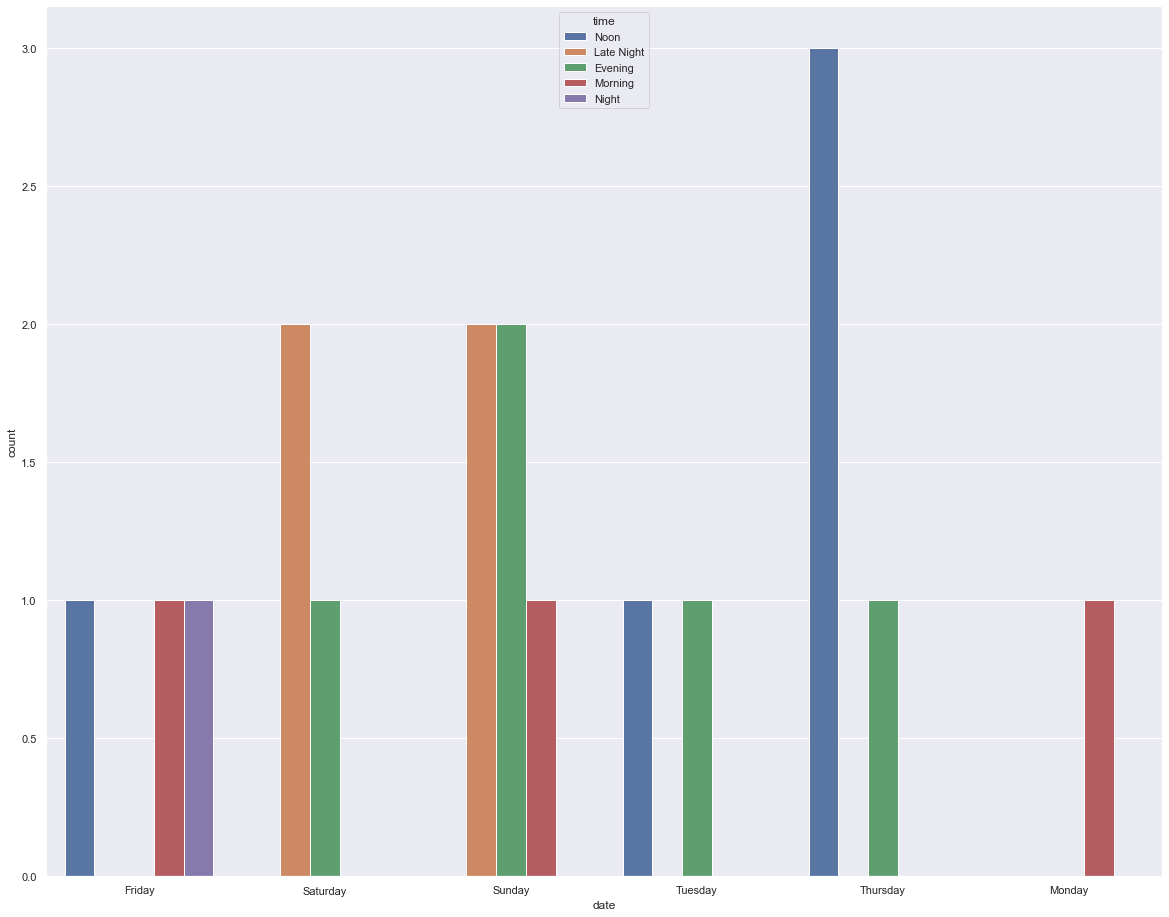

In [37]:
sns.countplot(x='date', data=normalrides_less_than_upfront, hue='time')

C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


<AxesSubplot:xlabel='precision', ylabel='dist_gap'>

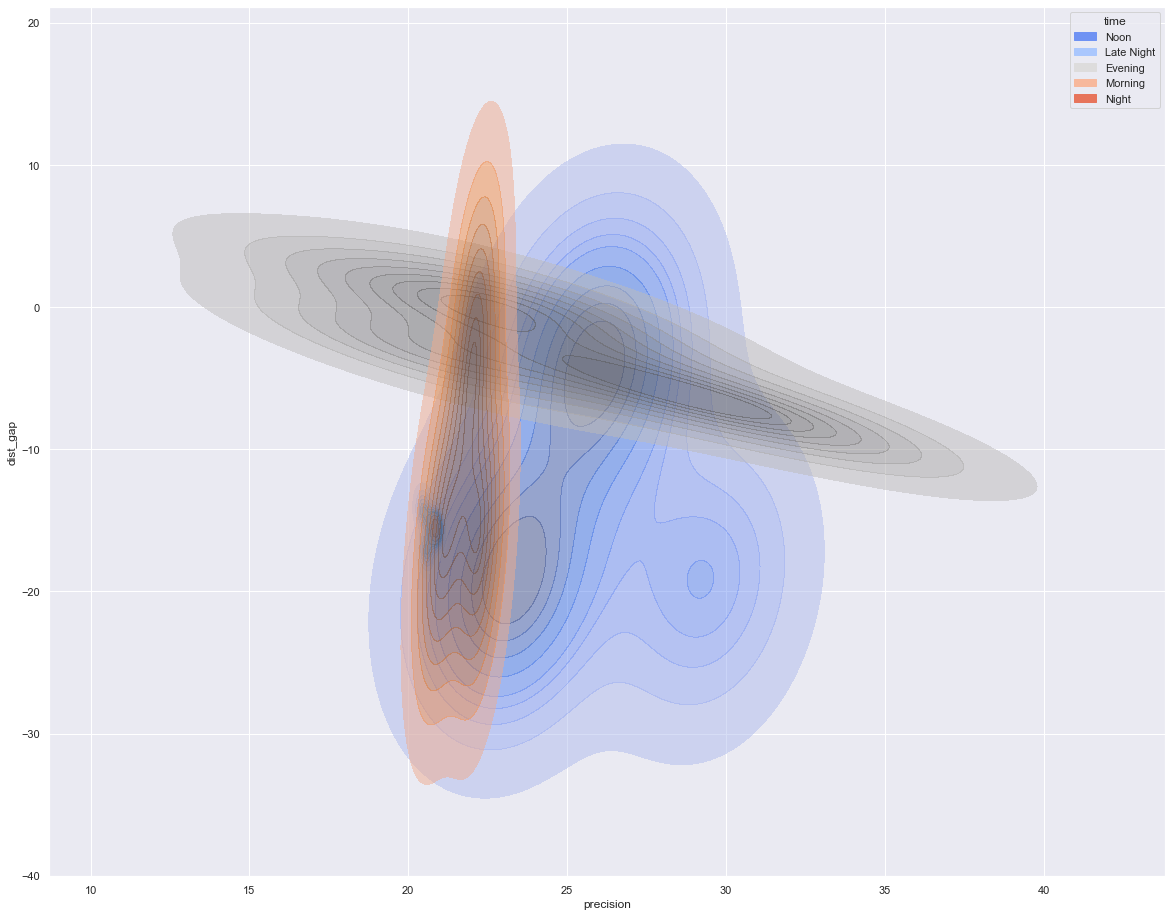

In [38]:
sns.kdeplot(
   data=normalrides_less_than_upfront, x="precision", y= 'dist_gap', hue="time",
   fill=True, common_norm=False, palette="coolwarm",
   alpha=.5, linewidth=0,
)

The rides happened more in the day time, between noon and night but evening trips had better precision.

<AxesSubplot:>

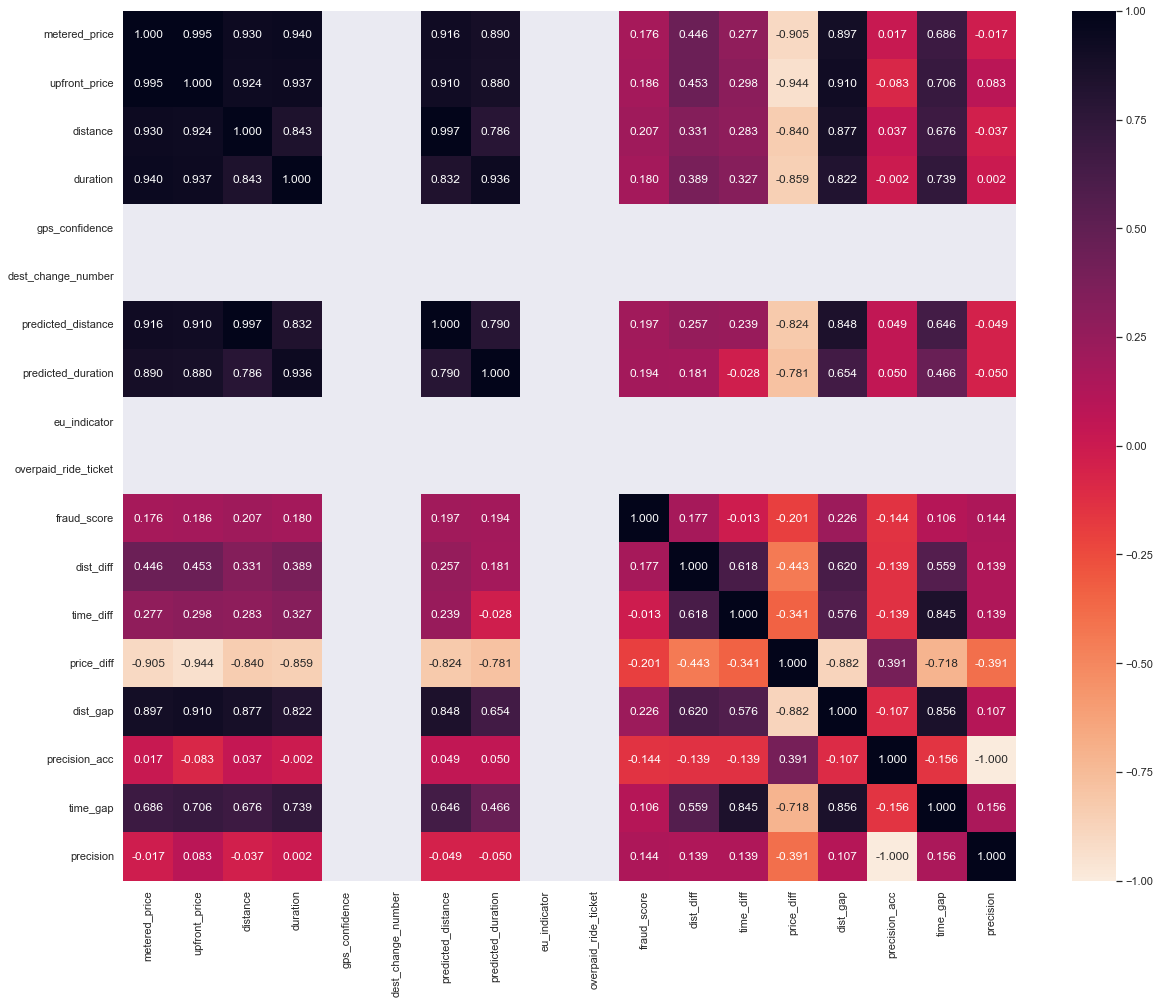

In [39]:
sns.heatmap(normalrides_less_than_upfront.corr(),annot=True,
                 fmt=".3f",
                 cmap = sns.cm.rocket_r)

The unique thing about these rides is that the upfront price correlated more with distance and duration than with the predicted distances and duration. This implies that these trips were underanalyzed by the algorithm, resulting in less metered price. GPS confidence was low for only 2 trips so it was insufficient to understand why the pricing underperformed. It could be because of the long distances because the average distance travelled was higher than the average distance for all rides within this bracket.

#### Rides costing 1000 or less in which metered price was at least 20% more than the upfront price

In [40]:
# We extract rides in which metered price cost 20% or more than the predicted price.
rides_outside_thresh_more_than_20p = Rides_outside_threshold[Rides_outside_threshold['precision_acc'] > 20]

In [41]:
get_sum(rides_outside_thresh_more_than_20p)

Precision% for data is:  47.24880016274896
Distance% for data is:  60.78583054908133
Duration% for data is:  74.08914918804344


The rides cost 47% more than predicted price, took 60% more distance and 74% more time than predicted.








Filtered data for rides which were 20% or more than the upfront price but distance was 20% or less than predicted distance. That’s to eliminate trips in which distances were significantly more than the predicted distances(trips which were continued or done using extended time).

In [42]:
# Applied distance factor of 20%
normalrides_outside_thresh_more_than_20p = rides_outside_thresh_more_than_20p[rides_outside_thresh_more_than_20p['dist_gap'] < 20]

In [43]:
get_sum(normalrides_outside_thresh_more_than_20p)

Precision% for data is:  35.54465072785432
Distance% for data is:  6.031054886451819
Duration% for data is:  67.75199210004156


These rides cost 35% more price, took 5% more distance and 67% more time than predicted. All happened within the EU.

<AxesSubplot:xlabel='precision_acc', ylabel='dist_gap'>

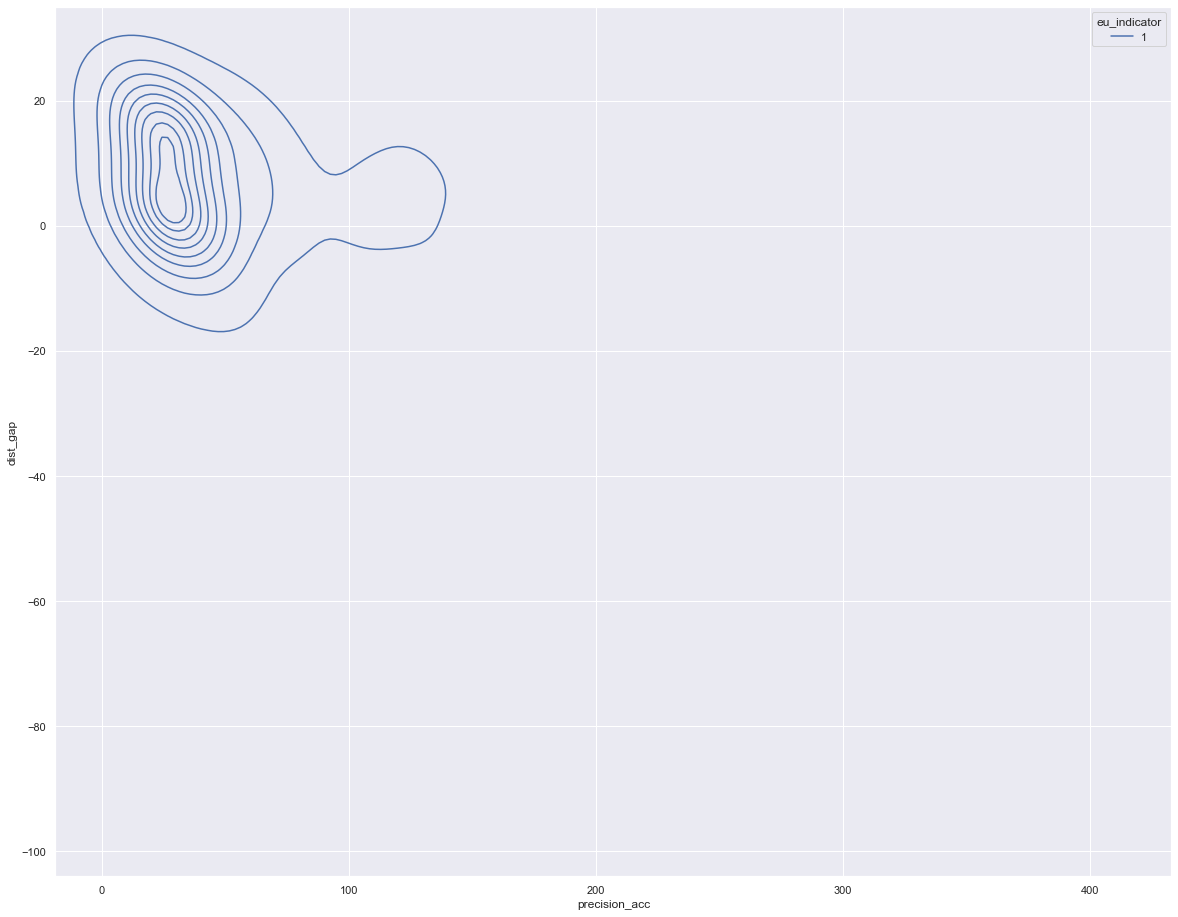

In [44]:
sns.kdeplot(x='precision_acc', y='dist_gap', data= normalrides_outside_thresh_more_than_20p, hue='eu_indicator')

Precision tended to increase as the rides accumulated more distances than predicted.

In [45]:
# We check gps_confidence on trips
print_percentage_differences(normalrides_outside_thresh_more_than_20p, 'gps_confidence')

Precision% for gps_confidence = 0 is:  50.482329892724
Precision% for gps_confidence = 1 is:  35.25738766699144
Distance% for gps_confidence = 0 is:  6.037255408074341
Distance% for gps_confidence = 1 is:  6.030935645651383
Duration% for gps_confidence = 0 is:  120.88664502041833
Duration% for gps_confidence = 1 is:  66.73017185157278


Trips with low GPS confidence paid 50% price and 6% more distance and 120.8% more time than predicted compared to rides with high GPS confidence, who paid 35% more price and had 6.5% more distance and 66% more time. 

<AxesSubplot:xlabel='precision', ylabel='Density'>

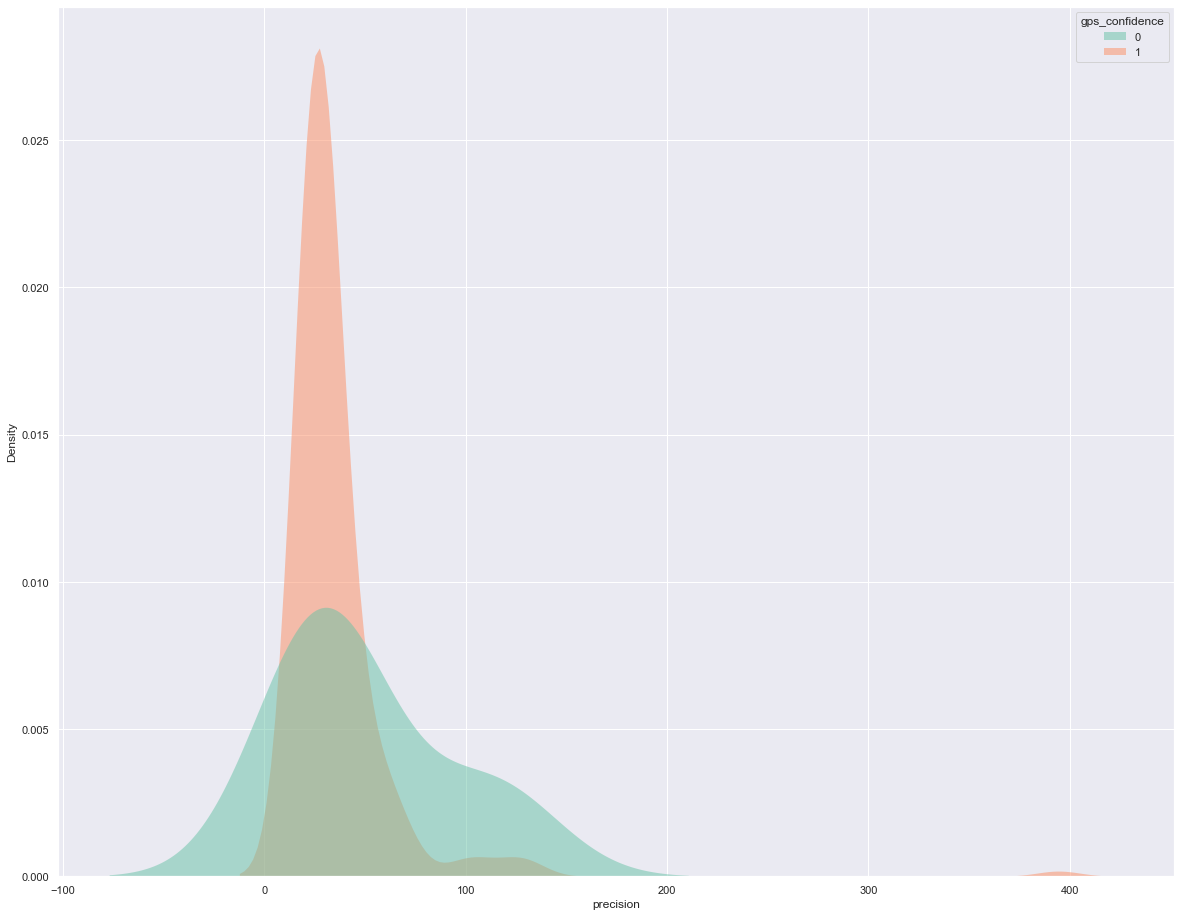

In [46]:
sns.kdeplot(
   data=normalrides_outside_thresh_more_than_20p, x="precision", hue="gps_confidence",
   fill=True, common_norm=False, palette="Set2",
   alpha=.5, linewidth=0,
)

 Further explained here.

In [47]:
# Some riders complained about overpaying.

print_percentage_differences(normalrides_outside_thresh_more_than_20p, 'overpaid_ride_ticket')

Precision% for overpaid_ride_ticket = 0 is:  34.74522266515179
Precision% for overpaid_ride_ticket = 1 is:  77.1149099883856
Distance% for overpaid_ride_ticket = 0 is:  6.1131220084503095
Distance% for overpaid_ride_ticket = 1 is:  1.763564542530165
Duration% for overpaid_ride_ticket = 0 is:  65.7151064033297
Duration% for overpaid_ride_ticket = 1 is:  173.67004832905857


Riders complained about overpaying and their trips, most of which happened in the morning, cost 77% more, while having only 1% increase in distance but 173% increase in time. They spent more time on the road on the average, 1668, than the average for the entire bracket, 513. This may have been down to a surge or possible traffic conditions. 

<AxesSubplot:xlabel='precision', ylabel='Density'>

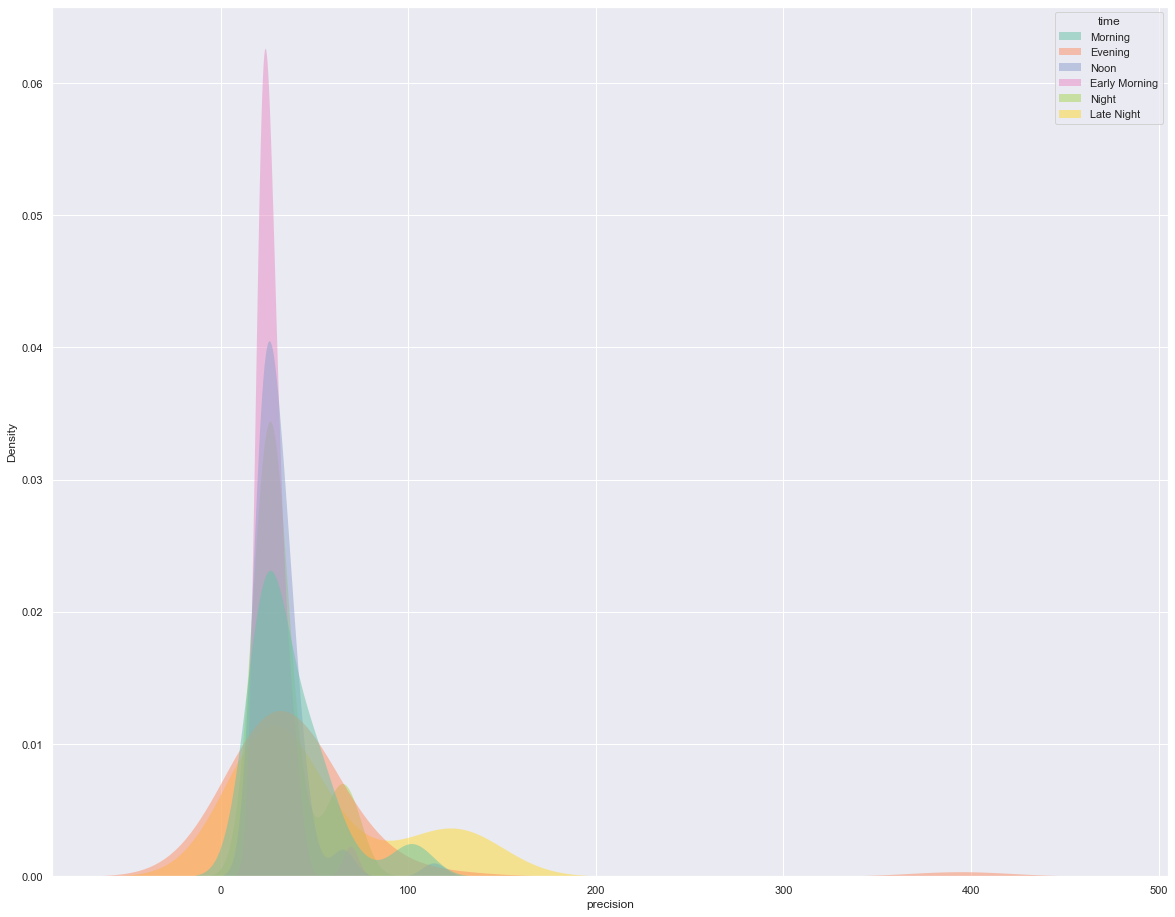

In [48]:
sns.kdeplot(
   data=normalrides_outside_thresh_more_than_20p, x="precision", hue="time",
   fill=True, common_norm=False, palette="Set2",
   alpha=.5, linewidth=0,
)

Trips were generally more precise in the evenings.

<AxesSubplot:>

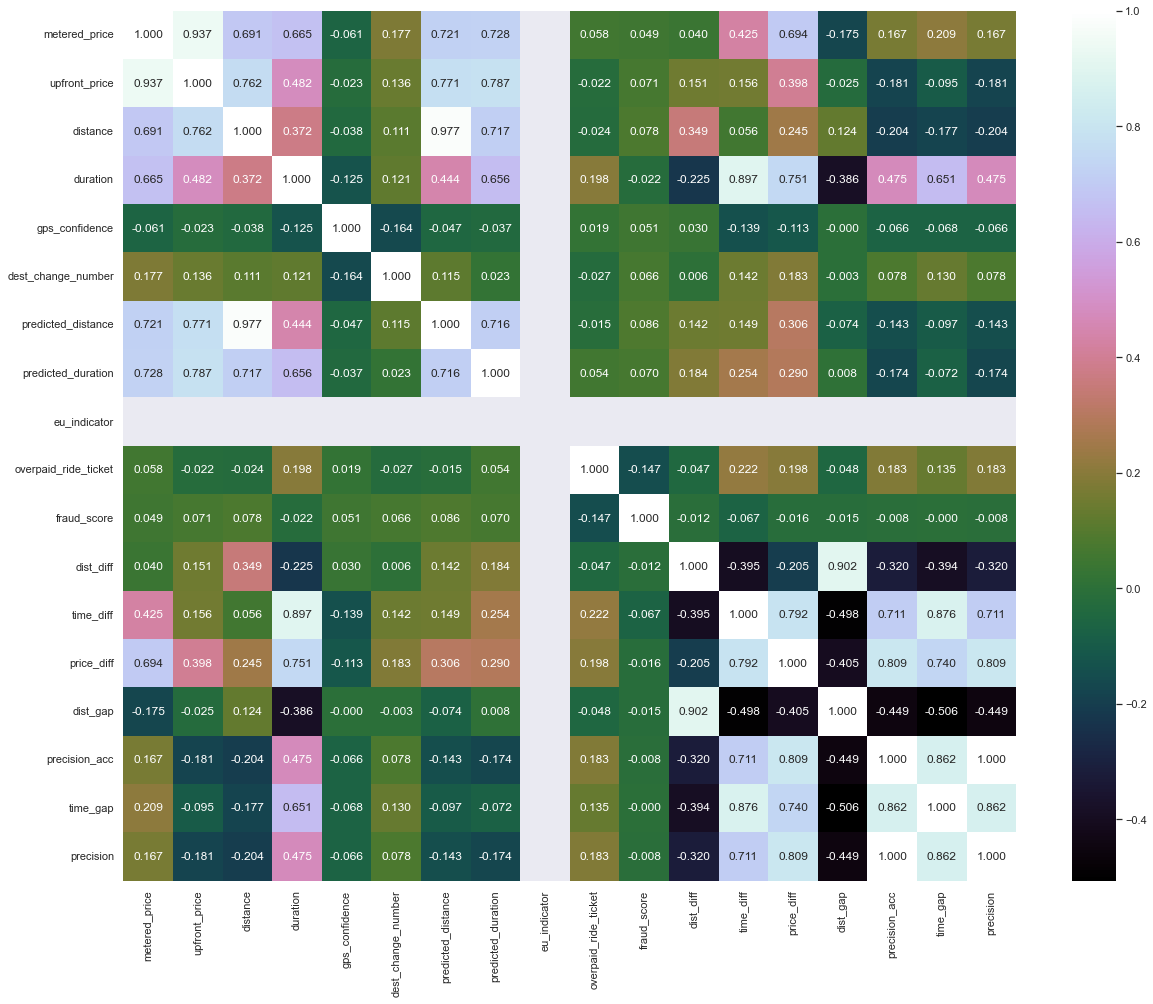

In [49]:
sns.heatmap(normalrides_outside_thresh_more_than_20p.corr(),annot=True,
                 fmt=".3f",
                 cmap = 'cubehelix')

Metered prices correlated more with predicted distances and predicted durations, indicating weak algorithmic calculations over longer distances as trips progressed. The closer the distances, the less the metered price correlated with them, but the more correlated precision is with duration. This indicates an inherent algorithmic bias towards duration even for short distances.

#### Rides costing between 1000 and 10,000

In [50]:
# We isolate rides costing between 1000 and 10000 which fell within the threshold.
rides_between_1000_and_10000 = new[new['upfront_price'] > 1000]
rides_between_1000_and_10000 = rides_between_1000_and_10000[rides_between_1000_and_10000['upfront_price'] <= 10000]

In [51]:
get_sum(rides_between_1000_and_10000)

Precision% for data is:  26.978452093627546
Distance% for data is:  20.422765377920726
Duration% for data is:  53.20486473170164


The rides cost 26.9% more,took 20.4% more distance, and 53.2% more time than predicted.







Filtered data for rides which were up to 20% more or less than the upfront price. Threshold rides.

In [52]:
threshold_rides_1000_10000 = rides_between_1000_and_10000[rides_between_1000_and_10000['precision'] < 20]

In [53]:
# We evaluate their averages.
get_sum(threshold_rides_1000_10000)

Precision% for data is:  0.9439977611257568
Distance% for data is:  -12.784852665473597
Duration% for data is:  10.636272808603062


These rides cost 0.9% more, took 12% less distance and 10% more time than predicted. These are benchmark values. Average distance difference was -462 which meant that predicted distances were more than actual distances on the average.

<AxesSubplot:xlabel='date', ylabel='count'>

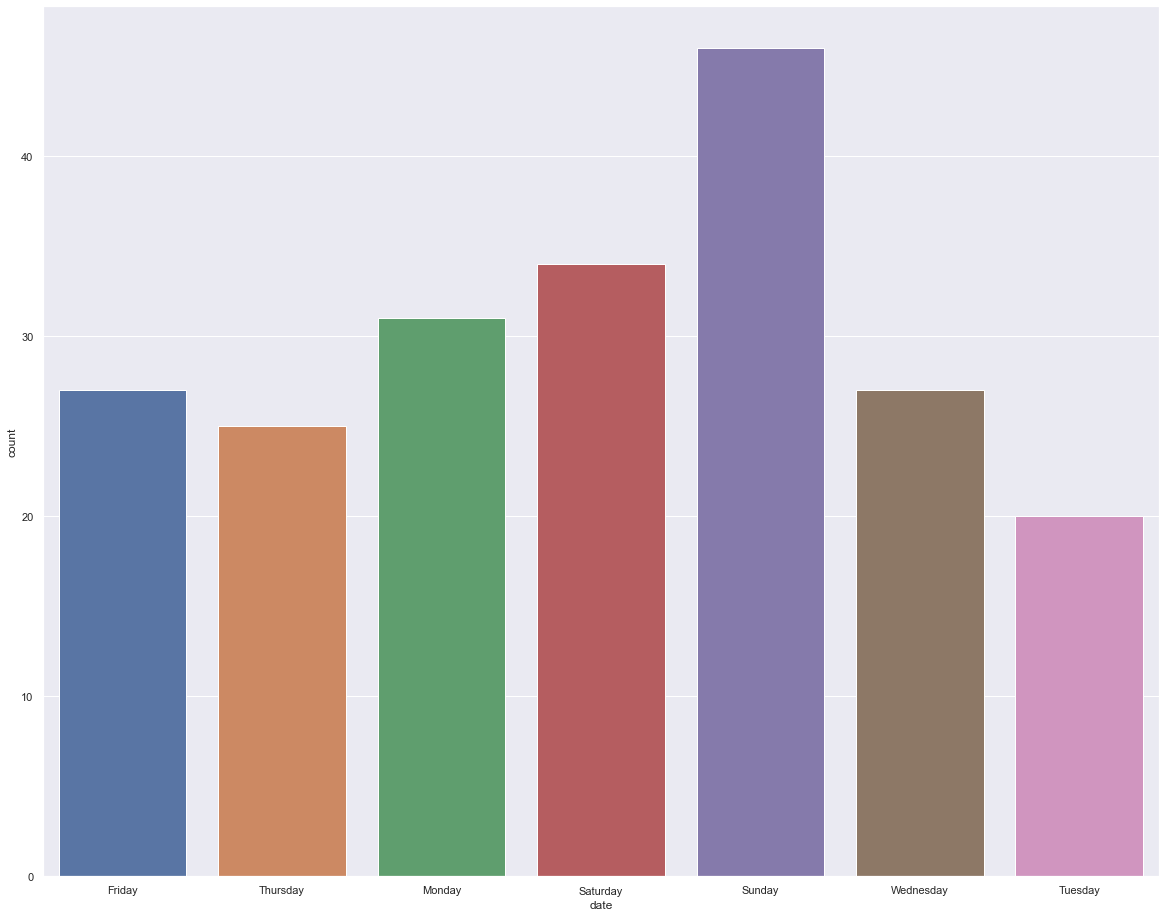

In [54]:
sns.countplot(x='date', data=threshold_rides_1000_10000)

More trips happened during the weekends, especially Sunday and between morning and noon.

<AxesSubplot:xlabel='precision_acc', ylabel='Density'>

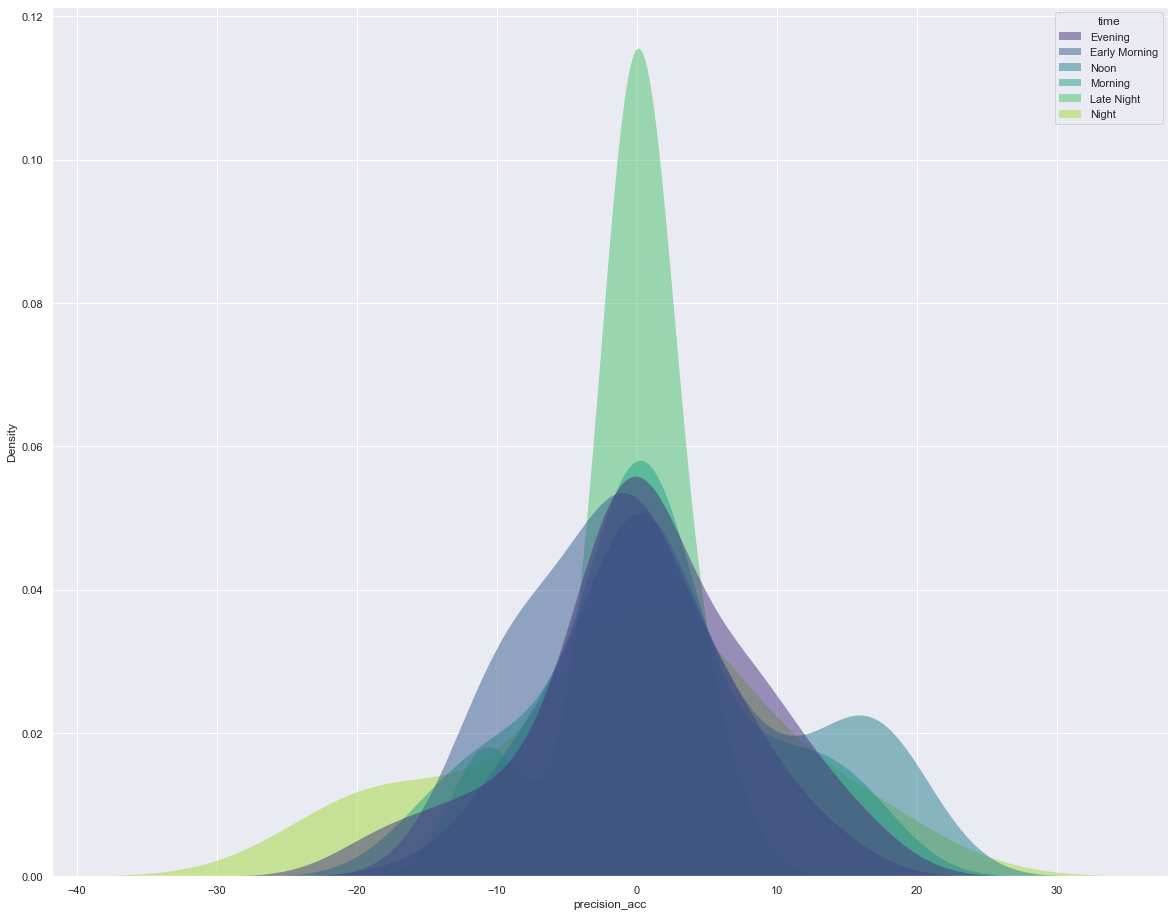

In [55]:
sns.kdeplot(
   data=threshold_rides_1000_10000, x="precision_acc", hue="time",
   fill=True, common_norm=False, palette="viridis",
   alpha=.5, linewidth=0,
)

The more precise trips happened at night and on Saturdays. 

In [56]:
print_percentage_differences(threshold_rides_1000_10000, 'gps_confidence')

Precision% for gps_confidence = 0 is:  -1.6385070157608492
Precision% for gps_confidence = 1 is:  1.3413061883390809
Distance% for gps_confidence = 0 is:  -15.520601525520721
Distance% for gps_confidence = 1 is:  -12.363968225466357
Duration% for gps_confidence = 0 is:  -7.931280142446902
Duration% for gps_confidence = 1 is:  13.492819416456896


Rides with high GPS confidence had higher correlations between pricing, distance and duration than rides with low GPS confidence. The rides with low GPS confidence paid 1.6% less price than predicted for 15% distance and 7.9% less time too, while rides with high GPS confidence paid 1.3% more price and had 12% less distance and 13% more time.

In [57]:
print_percentage_differences(threshold_rides_1000_10000, 'overpaid_ride_ticket')

Precision% for overpaid_ride_ticket = 0 is:  1.1442152094845008
Precision% for overpaid_ride_ticket = 1 is:  -1.1916550213675199
Distance% for overpaid_ride_ticket = 0 is:  -12.544725663146478
Distance% for overpaid_ride_ticket = 1 is:  -15.34620735696296
Duration% for overpaid_ride_ticket = 0 is:  11.452354152018033
Duration% for overpaid_ride_ticket = 1 is:  1.9314051455099859


Rides in which riders complained cost 1.1% less price, took 15% less distance and 1.9% more time compared to the 1% more price, 12% less distance and 11% more time that other rides paid. 

#### Rides with metered price more than 20% less than upfront price 

Which meant that rides with less metered price than the threshold had significantly less distances covered. So I introduced a time factor to understand the precision performance. I filtered out rides that were finished within 20% of the predicted time. 

In [58]:
rides_less_or_more_20p_threshold_1000 = rides_between_1000_and_10000[rides_between_1000_and_10000['precision'] > 20]
rides_less_than_20p_rides_1000 = rides_less_or_more_20p_threshold_1000[rides_less_or_more_20p_threshold_1000['precision_acc'] < -20]
rides_more_than_20p_rides_1000 = rides_less_or_more_20p_threshold_1000[rides_less_or_more_20p_threshold_1000['precision_acc'] > 20]

In [59]:
# I applied a time factor of 20%
normalrides_20p_less_threshold_1000 = rides_less_than_20p_rides_1000[rides_less_than_20p_rides_1000['time_gap'] >= -20]
normalrides_20p_less_threshold_1000 = normalrides_20p_less_threshold_1000[normalrides_20p_less_threshold_1000['time_gap'] >= -20]

In [60]:
get_sum(normalrides_20p_less_threshold_1000)

Precision% for data is:  -28.396091228070173
Distance% for data is:  -52.79907925177969
Duration% for data is:  12.273644777999014


The average trip cost 28.8% less price, took 50% less distance and 1.2% less time than predicted.

In [61]:
print_percentage_differences(normalrides_20p_less_threshold_1000, 'gps_confidence')

Precision% for gps_confidence = 0 is:  -35.71633333333334
Precision% for gps_confidence = 1 is:  -25.95601052631579
Distance% for gps_confidence = 0 is:  -44.36561873002551
Distance% for gps_confidence = 1 is:  -55.610232759031085
Duration% for gps_confidence = 0 is:  -11.977718566573987
Duration% for gps_confidence = 1 is:  20.35743255952335


Rides with low GPS confidence had 35% less prices than predicted, 44% less distance and 11 % less time, while high GPS confidence gave rides 26% less pricing, had 53% less distance and 6.5% more time. 

<AxesSubplot:xlabel='precision_acc', ylabel='time_gap'>

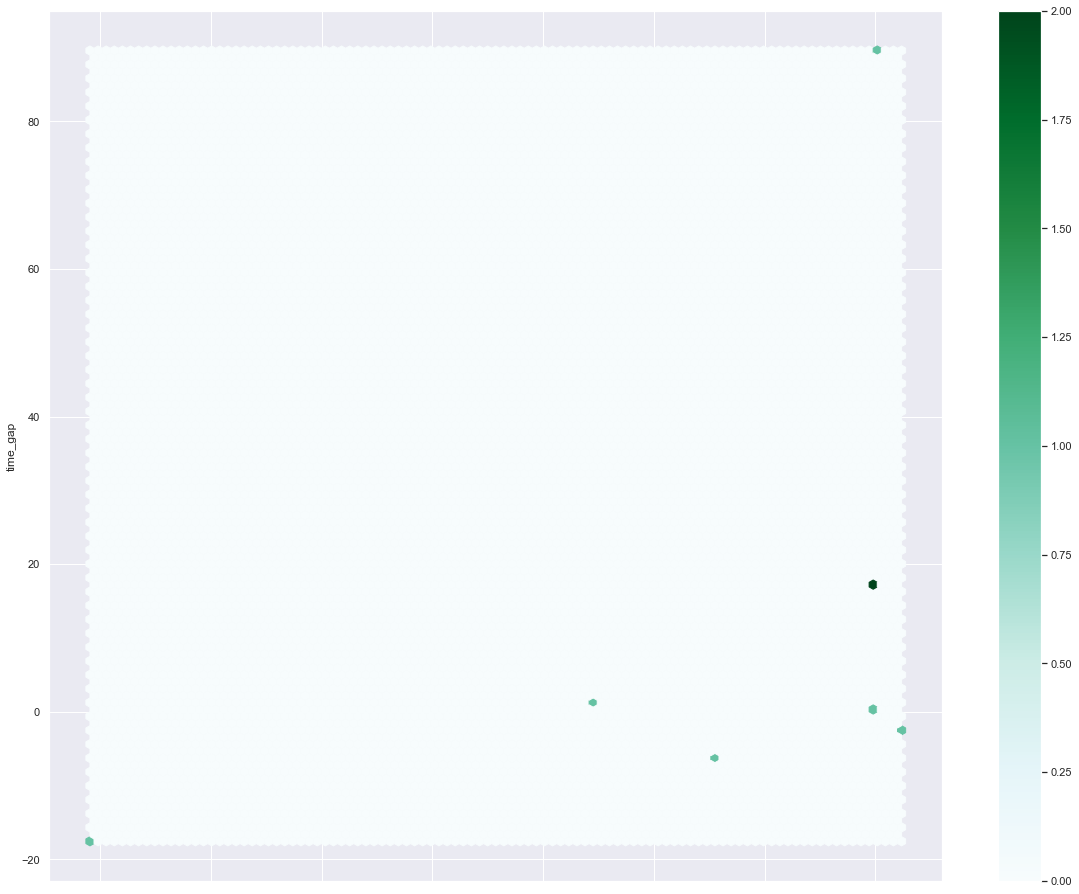

In [62]:
normalrides_20p_less_threshold_1000.plot.hexbin('precision_acc', 'time_gap')

Upfront price correlated more with trip durations than predicted values

<AxesSubplot:>

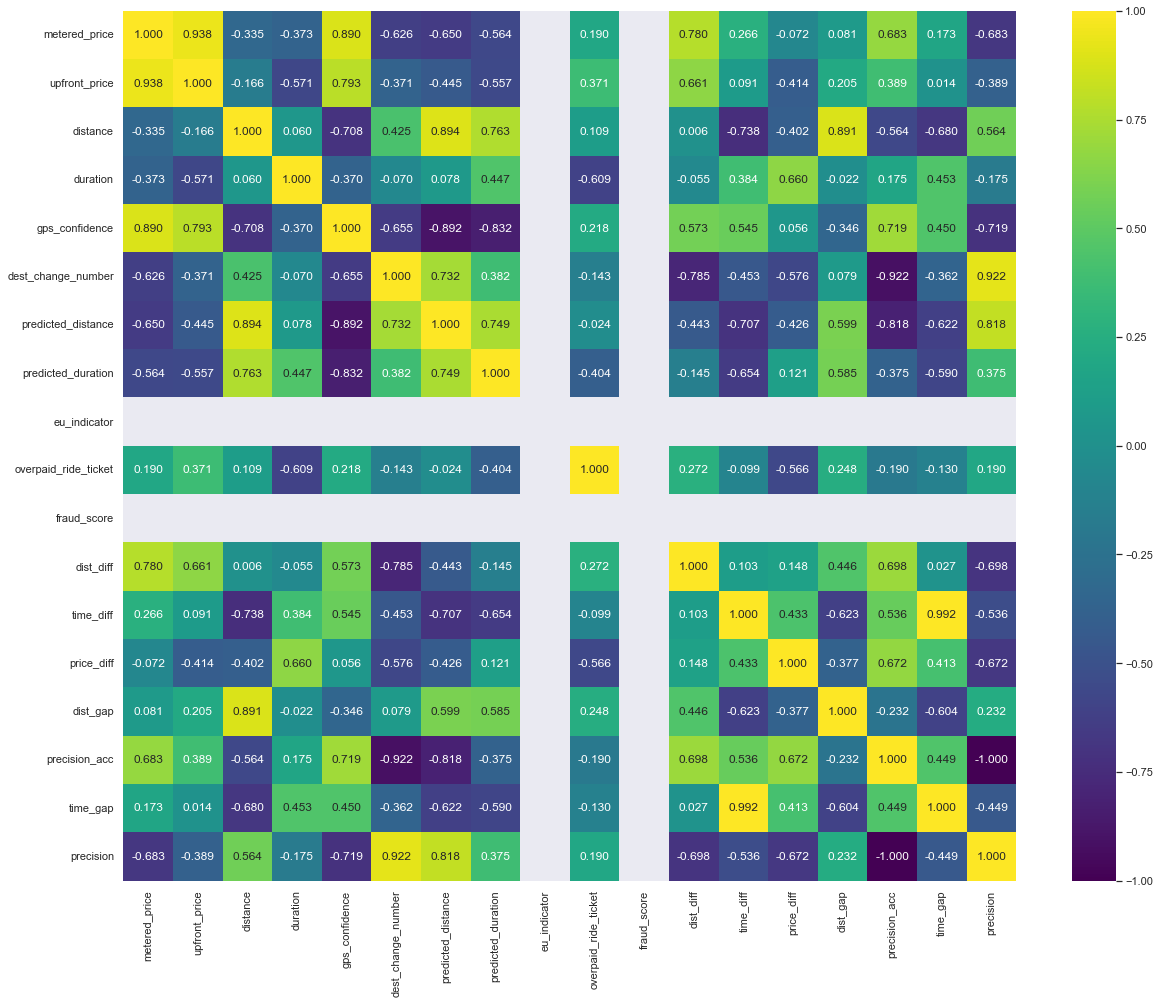

In [63]:
sns.heatmap(normalrides_20p_less_threshold_1000.corr(),annot=True,
                 fmt=".3f",
                 cmap = 'viridis')














Filtered out rides with metered price at least 20% more than the upfront price but with close distances. 

In [64]:
normalrides_20p_more_threshold_1000 = rides_more_than_20p_rides_1000[rides_more_than_20p_rides_1000['dist_gap'] >= -20]
normalrides_20p_more_threshold_1000 = normalrides_20p_more_threshold_1000[normalrides_20p_more_threshold_1000['dist_gap'] <= 20]

In [65]:
get_sum(normalrides_20p_more_threshold_1000)

Precision% for data is:  36.45686918128025
Distance% for data is:  8.199688121374251
Duration% for data is:  140.4952414189683


The average trip cost 36% more price, took 8% more distance and 130% more time than predicted.

In [66]:
print_percentage_differences(normalrides_20p_more_threshold_1000, 'gps_confidence')

Precision% for gps_confidence = 0 is:  53.567149411991515
Precision% for gps_confidence = 1 is:  33.034813135138
Distance% for gps_confidence = 0 is:  13.803497480100086
Distance% for gps_confidence = 1 is:  7.078926249629084
Duration% for gps_confidence = 0 is:  205.43750457839596
Duration% for gps_confidence = 1 is:  127.50678878708277


Trips without GPS confidence paid 53% more while travelling 13% more distances than predicted with 205% more time, while trips with GPS confidence paid 33% while travelling 7% less distances than predicted with 127% more time. 

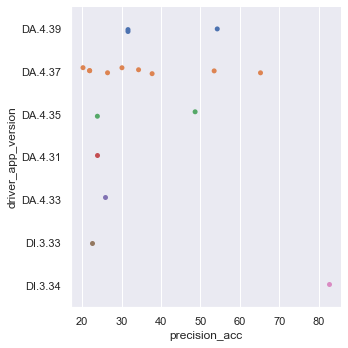

In [67]:
sns.catplot(x='precision_acc', y='driver_app_version', data=normalrides_20p_more_threshold_1000)

Driver app version 4.37 had the best precision

<AxesSubplot:xlabel='date', ylabel='count'>

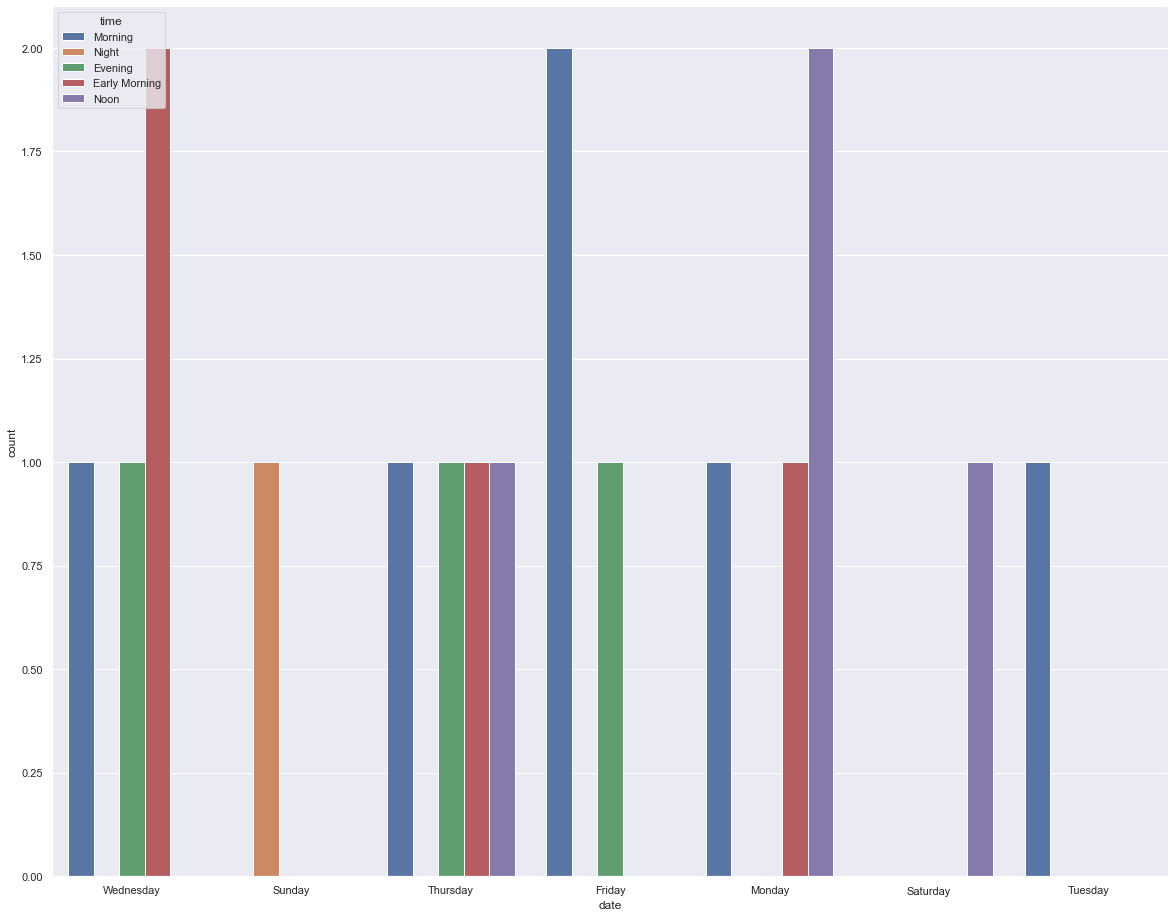

In [68]:
sns.countplot(x='date', data=normalrides_20p_more_threshold_1000, hue='time')

C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='precision_acc', ylabel='Density'>

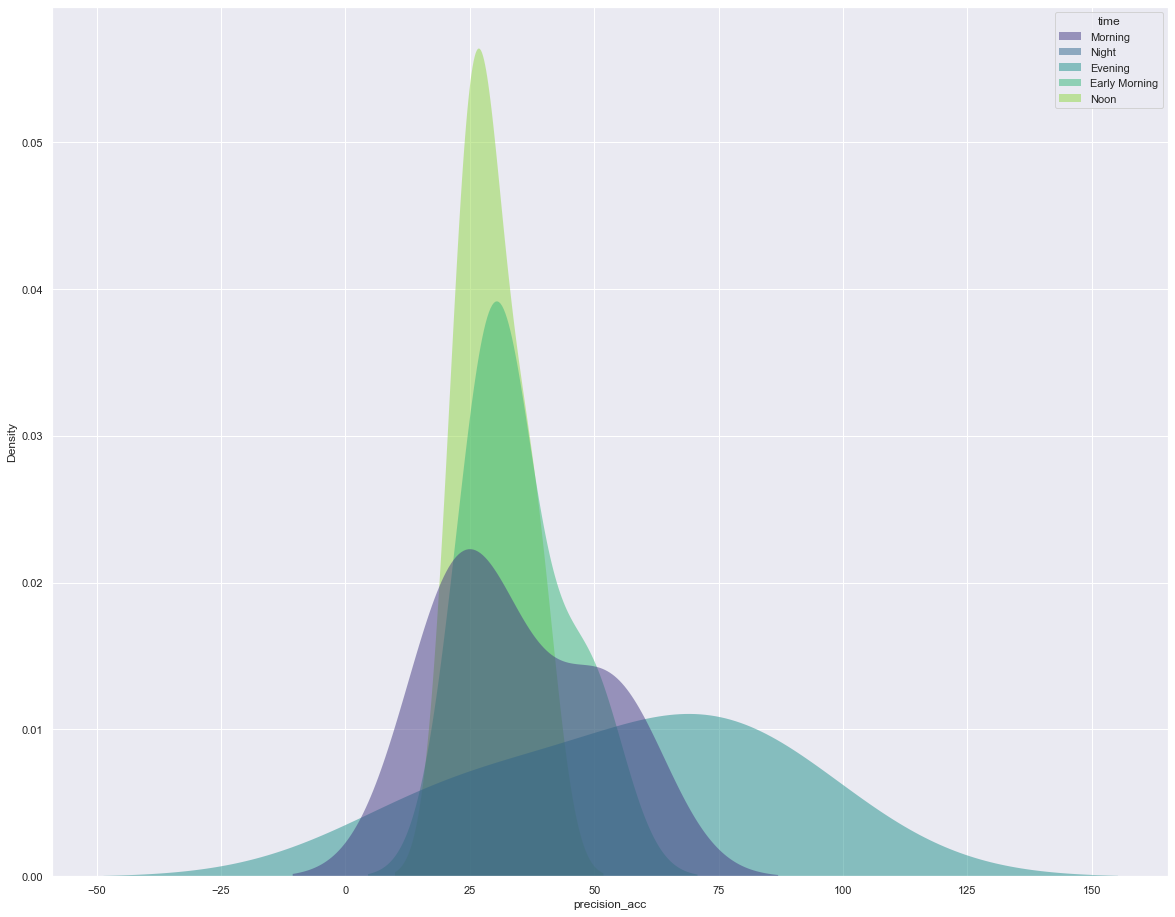

In [69]:
sns.kdeplot(
   data=normalrides_20p_more_threshold_1000, x="precision_acc", hue="time",
   fill=True, common_norm=False, palette="viridis",
   alpha=.5, linewidth=0,
)

Majority of these trips happened during weekdays, in the morning while the more precise rides happened then too.. They all happened outside the EU.

<AxesSubplot:>

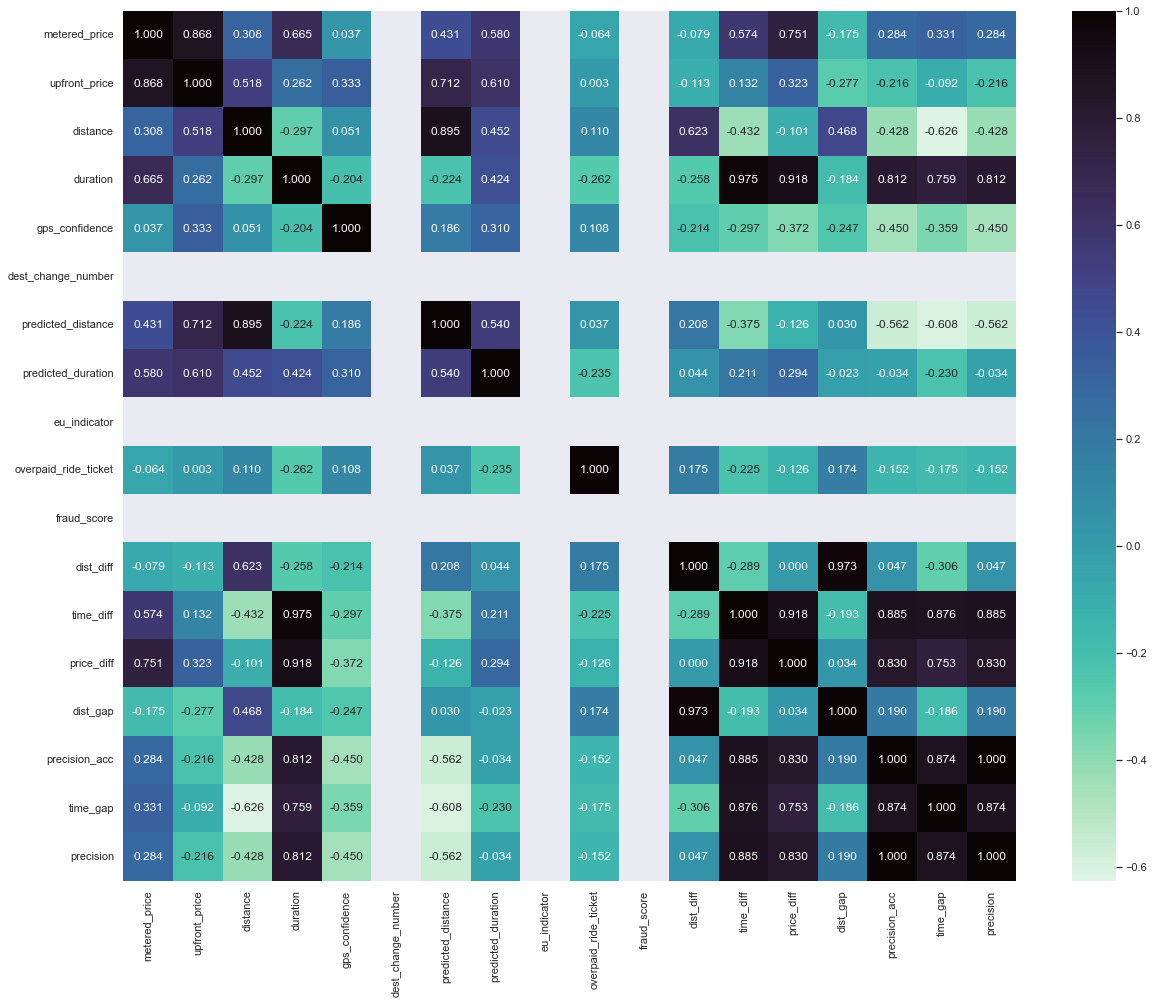

In [70]:
sns.heatmap(normalrides_20p_more_threshold_1000.corr(),annot=True,
                 fmt=".3f",
                 cmap = 'mako_r')

Metered price correlated more with predicted distance.

#### Rides costing between 10000 and 100000

In [71]:
Rides_between_10000_100000 = new[new['upfront_price'] > 10000]
Rides_between_10000_100000 = Rides_between_10000_100000[Rides_between_10000_100000['upfront_price'] <= 100000]

In [72]:
get_sum(Rides_between_10000_100000)

Precision% for data is:  42.65490288926899
Distance% for data is:  18.894244843601776
Duration% for data is:  50.06918613267508


The average trip cost 42% more price, took 18% more distance and 50% more time than predicted.


<AxesSubplot:xlabel='date', ylabel='count'>

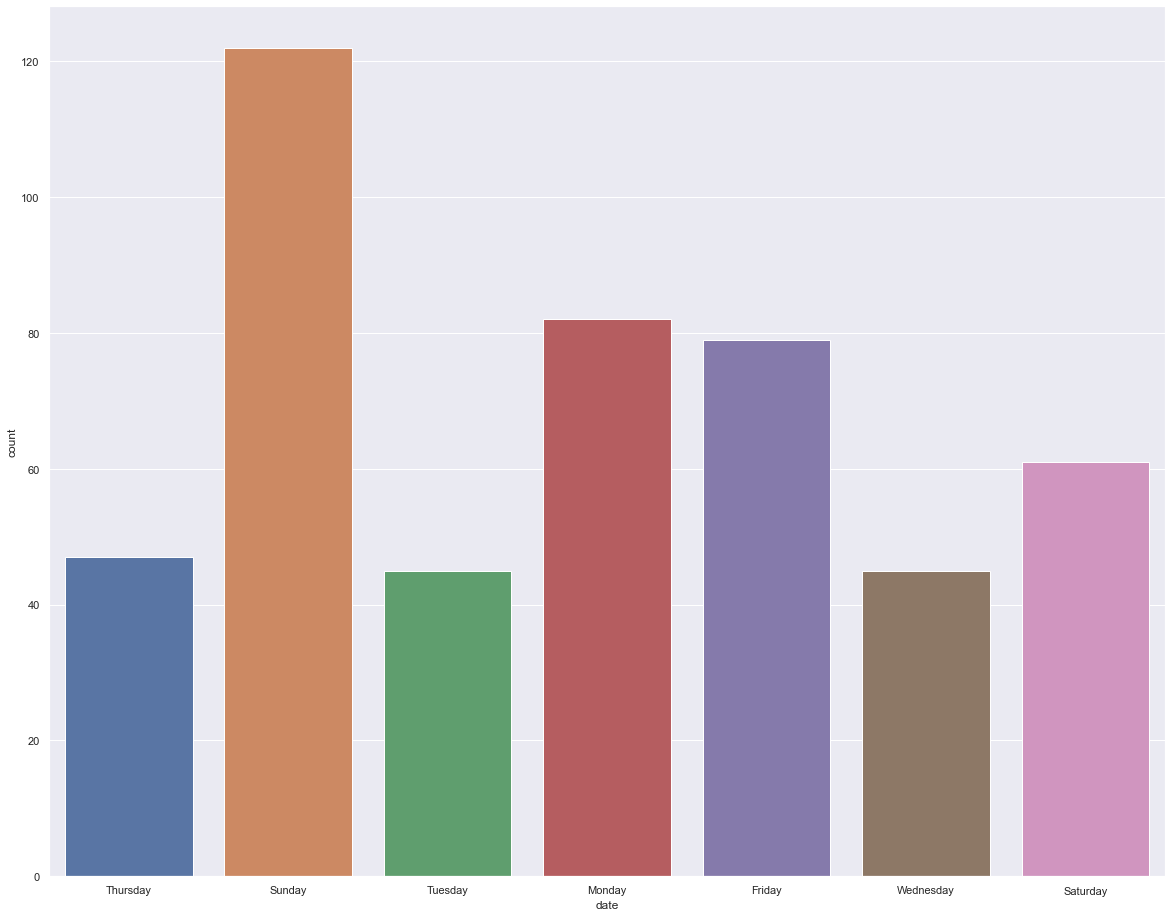

In [73]:
sns.countplot(x='date', data=Rides_between_10000_100000)

Most trips happened in the mornings and Sunday had most trips.

<AxesSubplot:xlabel='precision_acc', ylabel='Density'>

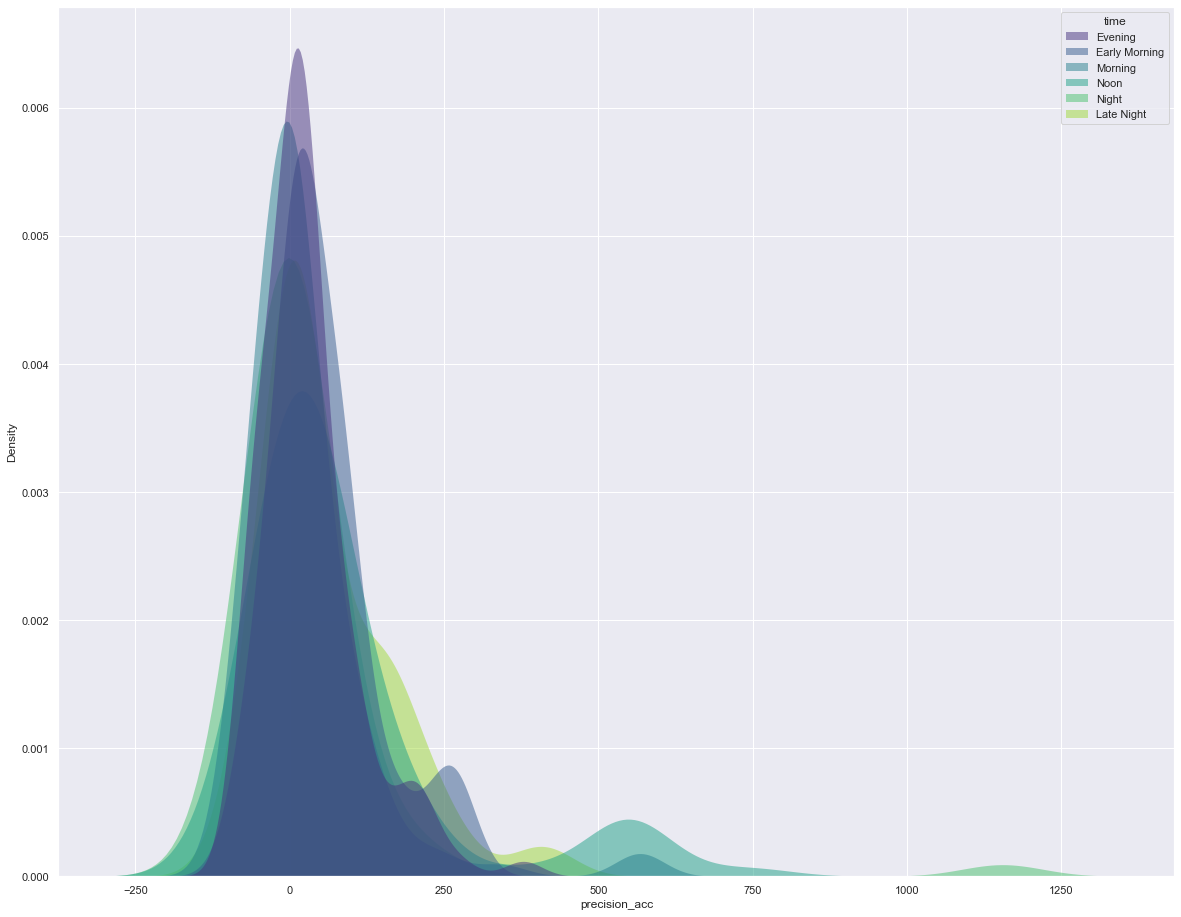

In [74]:
sns.kdeplot(
   data=Rides_between_10000_100000, x="precision_acc", hue="time",
   fill=True, common_norm=False, palette="viridis",
   alpha=.5, linewidth=0,
)

The more precise trips happened in the morning.

#### Threshold rides

In [75]:
# For rides with metered price at most 20% more or less the upfront price
Threshold_rides_100000 = Rides_between_10000_100000[Rides_between_10000_100000['precision'] < 21]

In [76]:
get_sum(Threshold_rides_100000)

Precision% for data is:  4.650033468198049
Distance% for data is:  -0.46216955382713637
Duration% for data is:  26.732907332437854


The average trip cost 4.6% more price, had 0.4% less distance and 26% more time than predicted. About 24% of rides had low GPS confidence, the highest across all data categories.

In [77]:
print_percentage_differences(Threshold_rides_100000, 'gps_confidence')

Precision% for gps_confidence = 0 is:  0.6446719279966571
Precision% for gps_confidence = 1 is:  5.96429272357663
Distance% for gps_confidence = 0 is:  -1.6048678955394
Distance% for gps_confidence = 1 is:  -0.08722166045279912
Duration% for gps_confidence = 0 is:  17.533120505212313
Duration% for gps_confidence = 1 is:  29.751587385121212


The rides paid 0.6% more for 1.6% less distances and 17% more time while rides with GPS confidence paid 5.95% more and had 0.08% less distances and 29.5% more time

In [78]:
print_percentage_differences(Threshold_rides_100000, 'overpaid_ride_ticket')

Precision% for overpaid_ride_ticket = 0 is:  5.15411324403413
Precision% for overpaid_ride_ticket = 1 is:  0.3933598055822596
Distance% for overpaid_ride_ticket = 0 is:  -0.2348481132717959
Distance% for overpaid_ride_ticket = 1 is:  -2.3817728296277885
Duration% for overpaid_ride_ticket = 0 is:  28.575583109879602
Duration% for overpaid_ride_ticket = 1 is:  11.172534100707527


Riders who complained about overpaying spent 0.3% more and had 2.3% less distance and 11% more time compared to riders who didn’t and paid 5% more and had 0.23% less distance than predicted but 28% more time

<AxesSubplot:xlabel='precision_acc', ylabel='Density'>

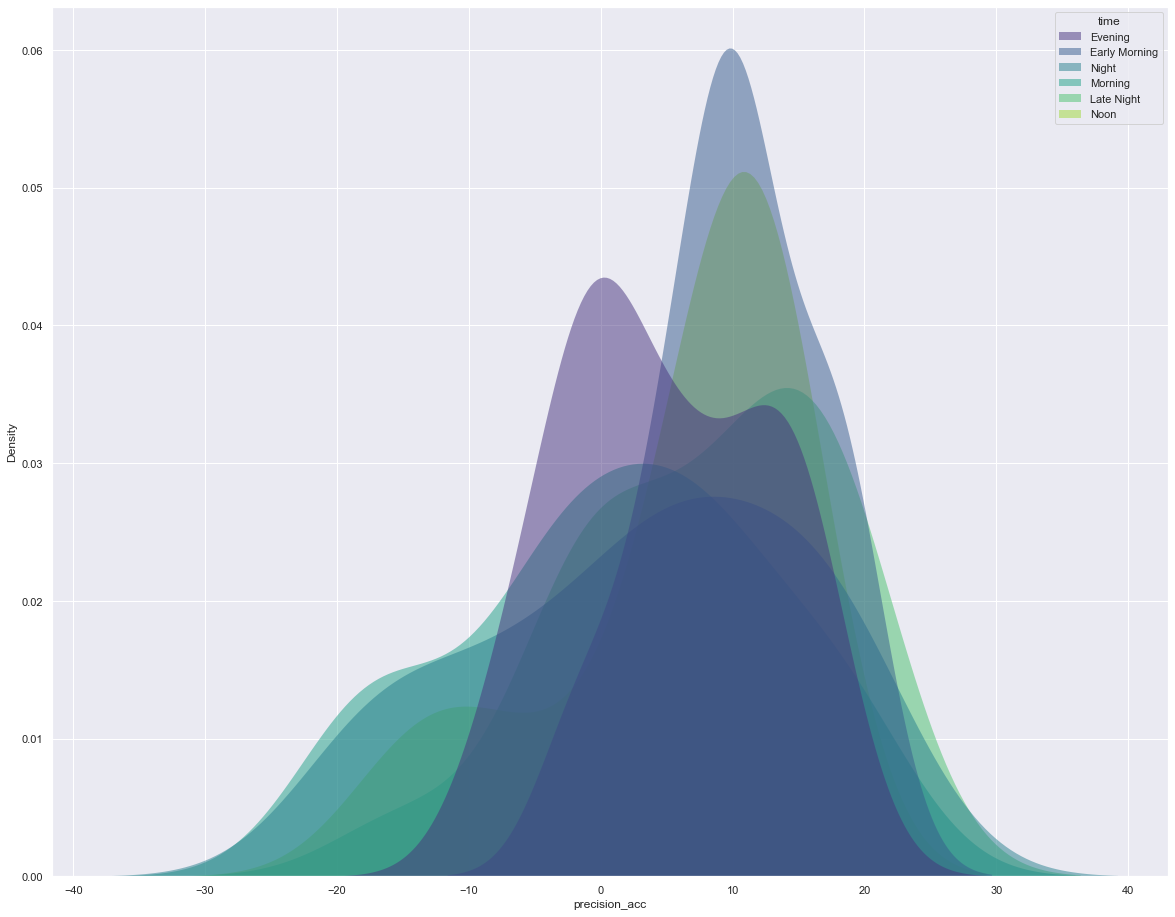

In [79]:
sns.kdeplot(
   data=Threshold_rides_100000, x="precision_acc", hue="time",
   fill=True, common_norm=False, palette="viridis",
   alpha=.5, linewidth=0,
)

The more precise rides happened in the evenings. All trips happened outside the EU.

<AxesSubplot:>

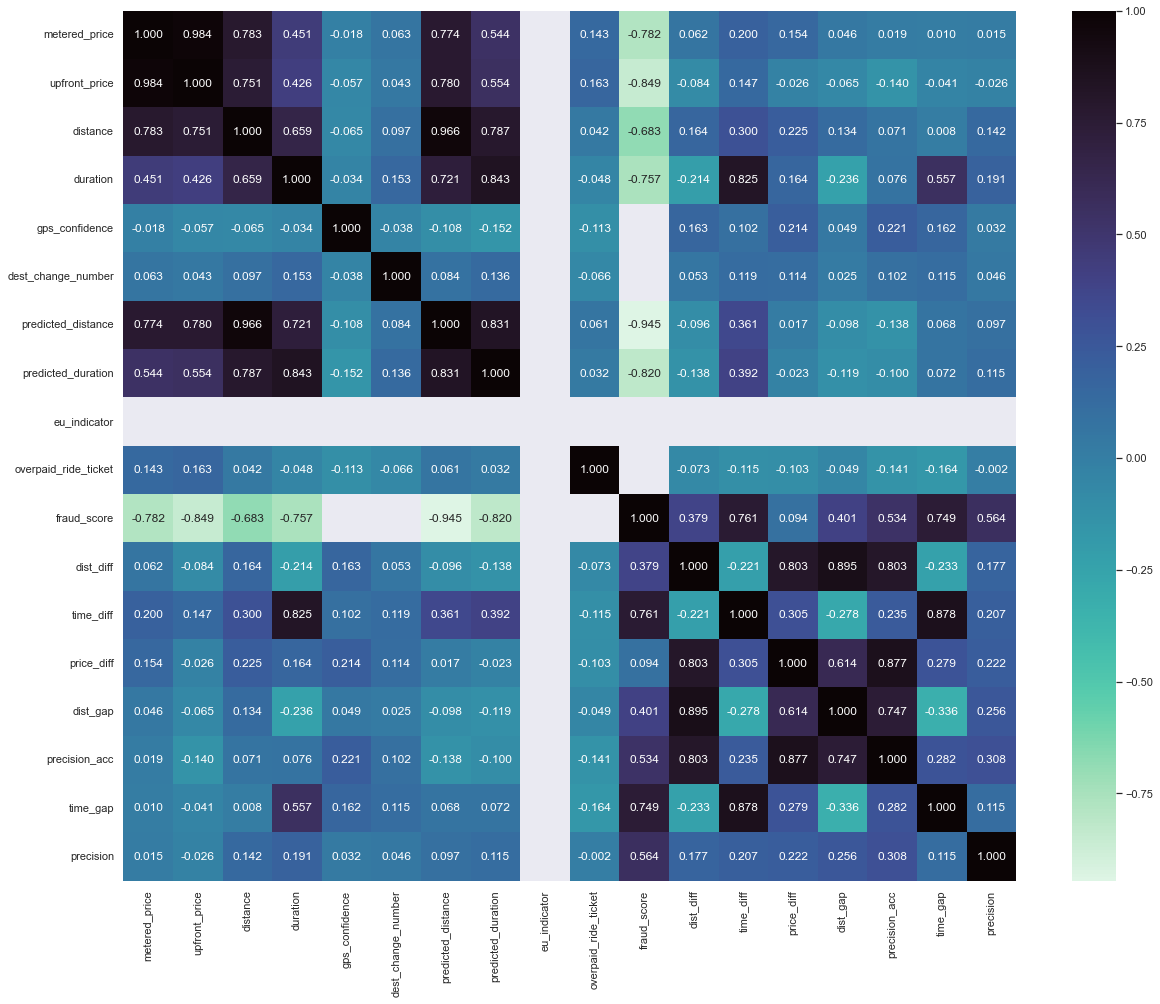

In [80]:
sns.heatmap(Threshold_rides_100000.corr(),annot=True,
                 fmt=".3f",
                 cmap = 'mako_r')

Upfront price correlated more with duration than predicted duration. Precision correlated more with distance and duration. Metered price correlated more with predicted duration.

#### Rides costing 10,000 to 100,000 with metered price at least 20% less than the upfront price

In [85]:
# We filter out these rides
rides_20p_more_less_than_threshold_100000 = Rides_between_10000_100000[Rides_between_10000_100000['precision'] > 20]

In [86]:
get_sum(rides_20p_more_less_than_threshold_100000)

Precision% for data is:  62.89229105695256
Distance% for data is:  29.16118108044692
Duration% for data is:  62.819383806865154


The average trip cost 51% less price, took 78.6% less distance and 54% less time than predicted.

In [83]:
# We select rides with similar distances for more accurate understanding of the precision errors
rides_20p_less_100000 = rides_20p_more_less_than_threshold_100000[rides_20p_more_less_than_threshold_100000['precision_acc'] < -21]

In [89]:
normalrides_20p_less_100000 = rides_20p_less_100000[rides_20p_less_100000['dist_gap'] >= -20]

In [90]:
# These rides don't exist. So we take a time factor deduction.
normalrides_20p_less_100000

Empty DataFrame
Columns: [metered_price, upfront_price, distance, duration, gps_confidence, entered_by, dest_change_number, prediction_price_type, predicted_distance, predicted_duration, change_reason_pricing, rider_app_version, driver_app_version, device_name, eu_indicator, overpaid_ride_ticket, fraud_score, date, time, dist_diff, time_diff, price_diff, dist_gap, precision_acc, time_gap, precision]
Index: []

[0 rows x 26 columns]

In [91]:
# Now we have data to analyze.
normalrides_20p_less_100000 = rides_20p_less_100000[rides_20p_less_100000['time_gap'] >= -20]

In [93]:
get_sum(normalrides_20p_less_100000)

Precision% for data is:  -32.861324759315174
Distance% for data is:  -55.52185065393491
Duration% for data is:  15.863985093282075


A time factor deduction was implemented and the corresponding data analyzed since rides with close distances within this bracket didn’t exist. The average precision was 32.8% less price and 55% less distance and 15.8% more time than predicted

In [94]:
# We check for GPS_confidence and other binary variables
print_percentage_differences(normalrides_20p_less_100000, 'gps_confidence')

Precision% for gps_confidence = 0 is:  -40.87334787244318
Precision% for gps_confidence = 1 is:  -31.040410415422446
Distance% for gps_confidence = 0 is:  -49.211455307596104
Distance% for gps_confidence = 1 is:  -56.95603141446646
Duration% for gps_confidence = 0 is:  6.397432580494936
Duration% for gps_confidence = 1 is:  18.015474300733693


~20% of the trips had low GPS confidence and they paid 40.8% less than predicted in 49% less distance and 6% less time while the rides with high confidence paid 31% less and had 56% less distance and 18% more time

<AxesSubplot:xlabel='precision_acc', ylabel='Proportion'>

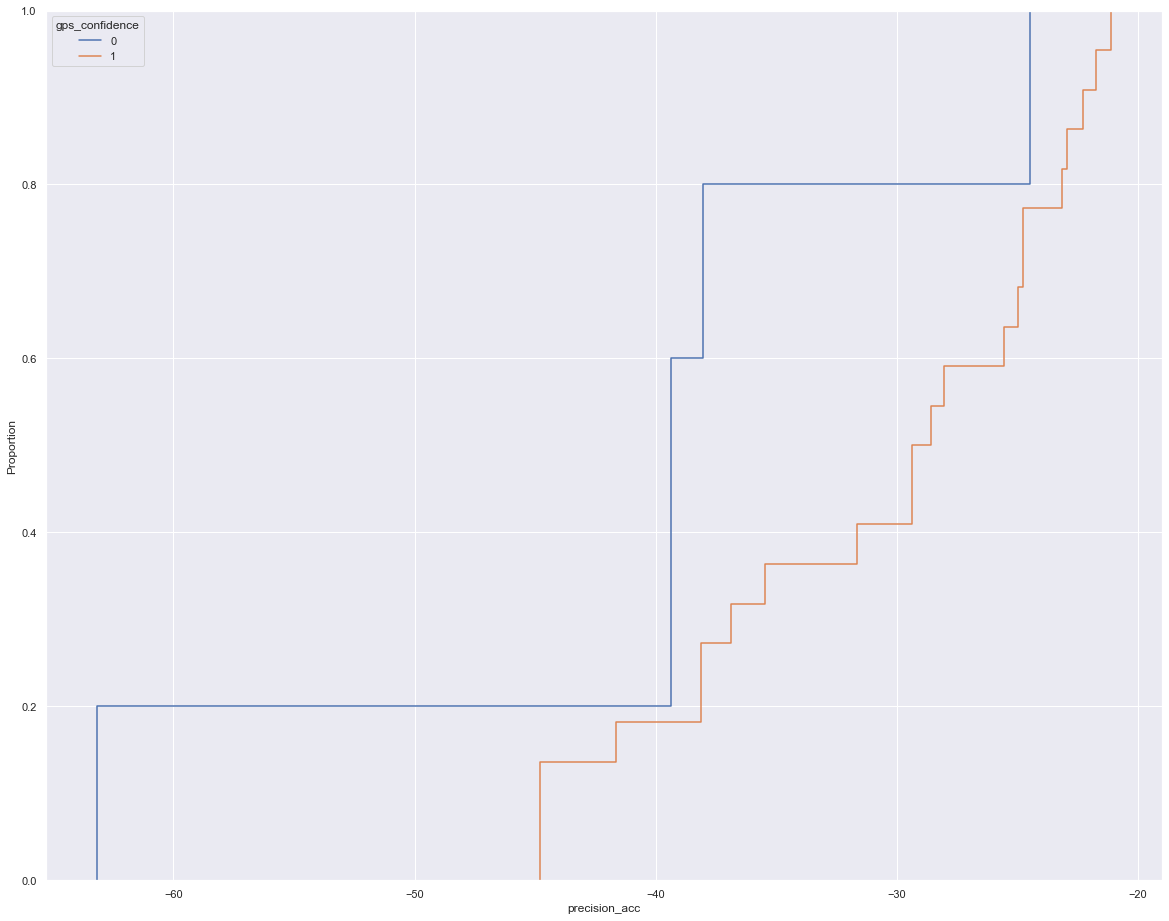

In [95]:
sns.ecdfplot(data=normalrides_20p_less_100000, x="precision_acc", hue="gps_confidence")

Trips with GPS confidence had more precision

<AxesSubplot:xlabel='date', ylabel='count'>

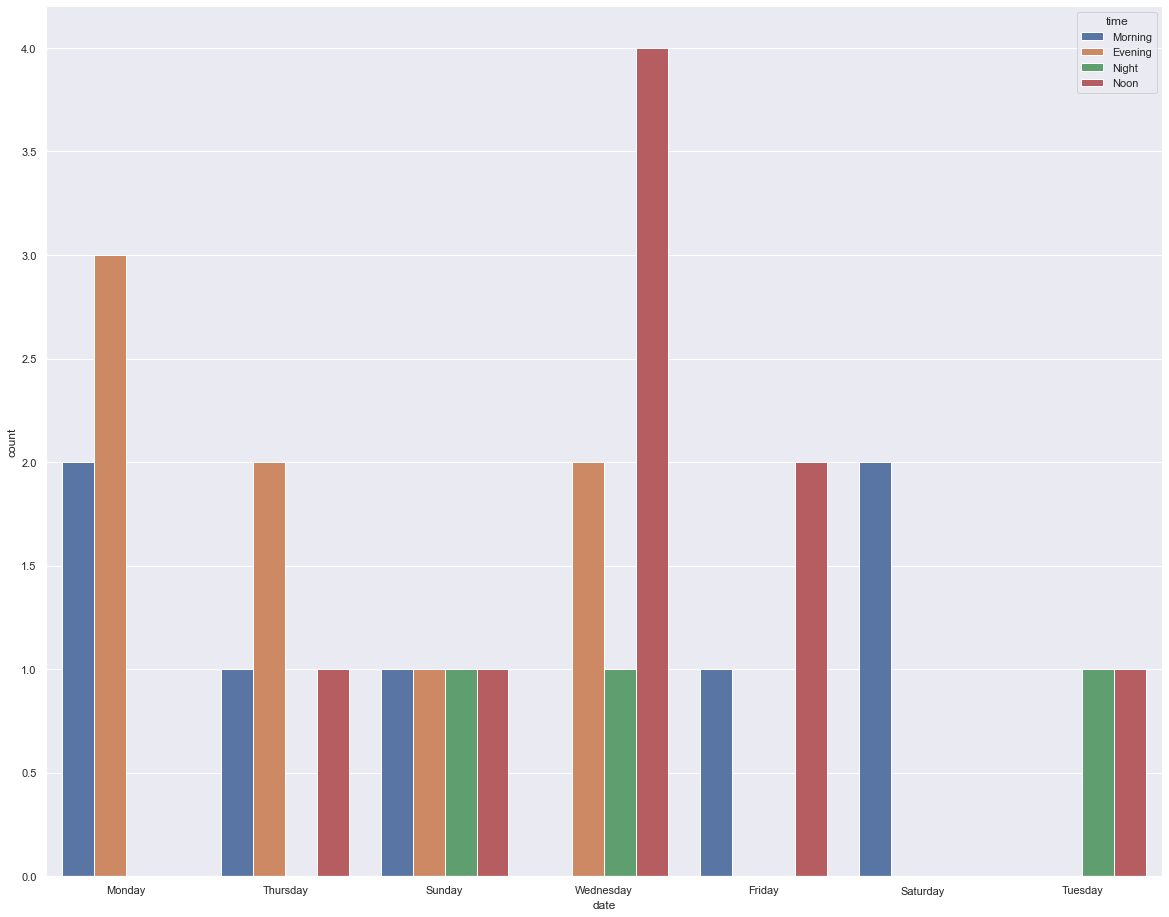

In [97]:
sns.countplot(x='date',data=normalrides_20p_less_100000, hue='time')

Majority of the trips happened on Wednesday and also between Noon and Evening.

<AxesSubplot:xlabel='precision', ylabel='Density'>

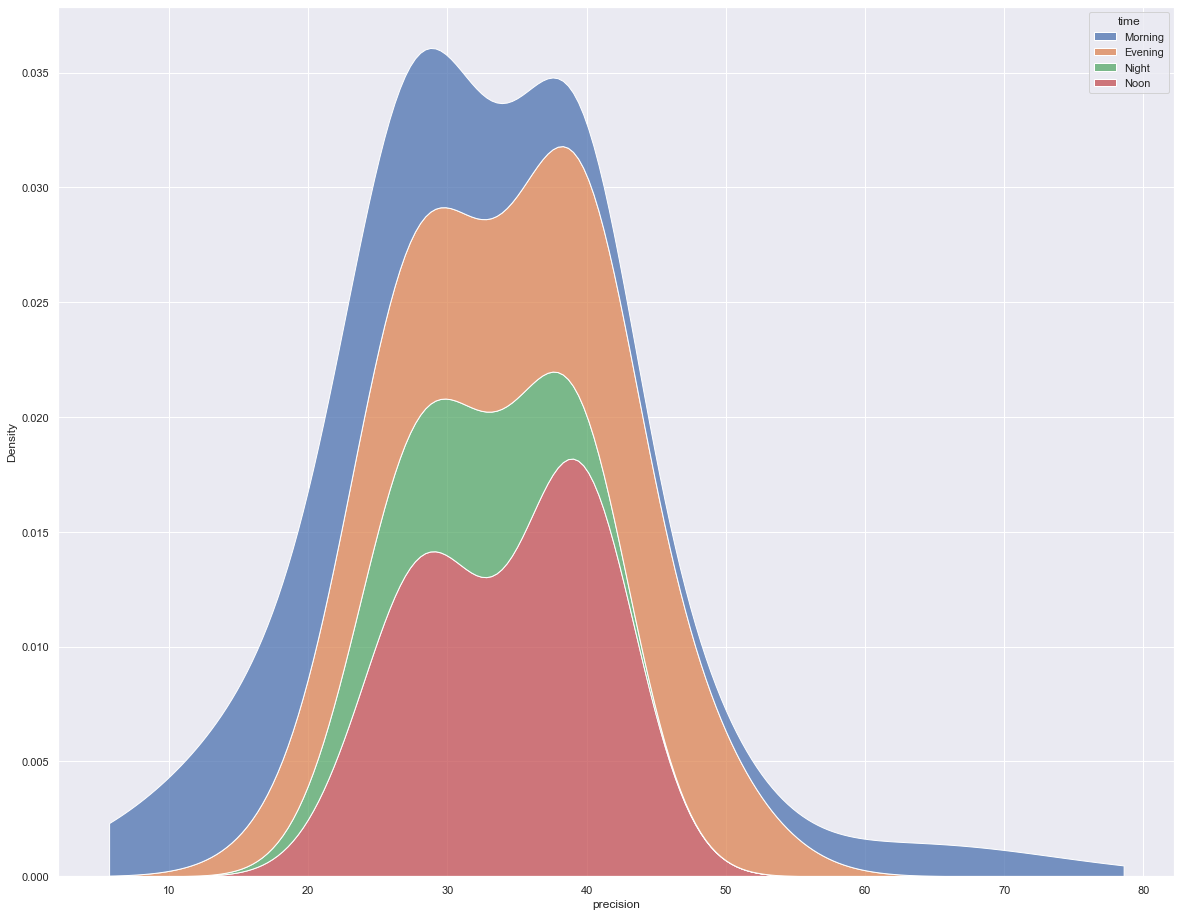

In [101]:
sns.kdeplot(data=normalrides_20p_less_100000, x="precision", hue="time", multiple="stack")


<AxesSubplot:xlabel='precision', ylabel='Density'>

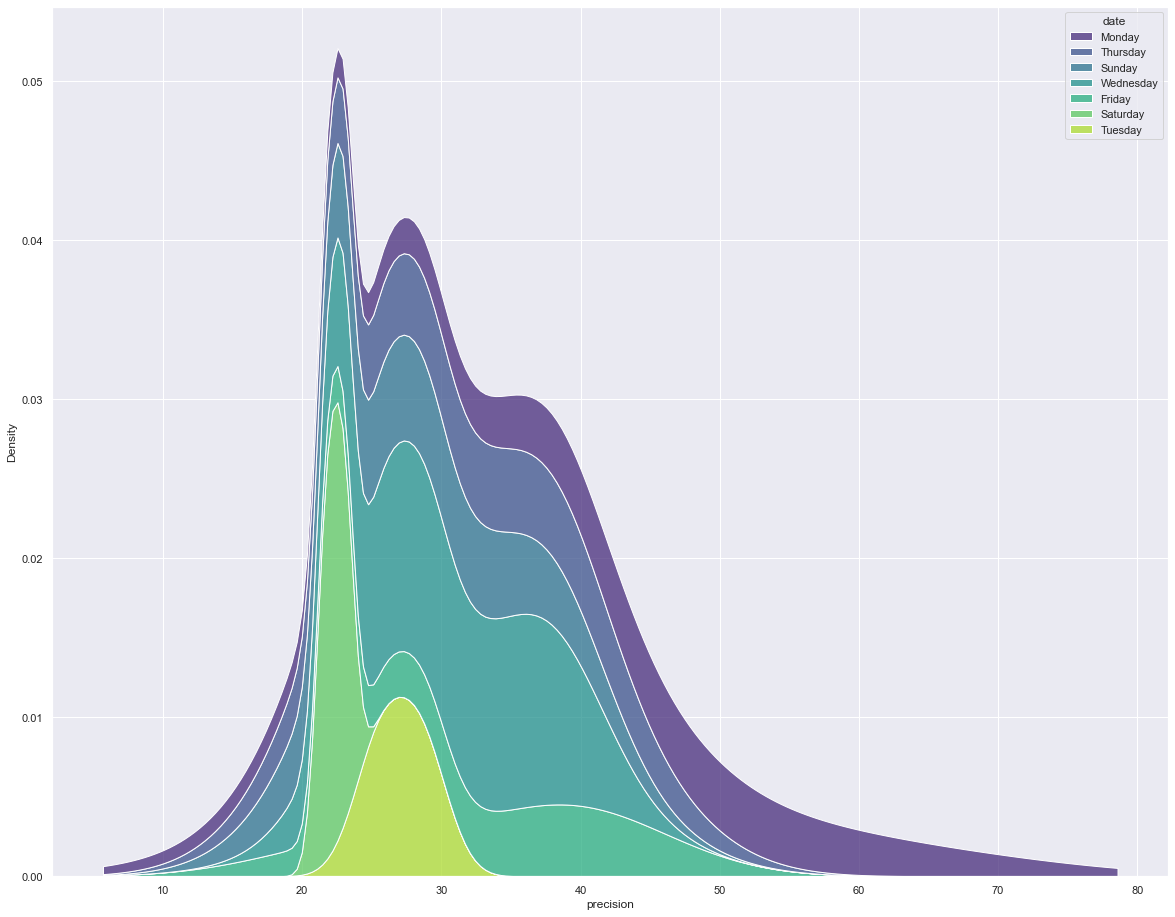

In [102]:
sns.kdeplot(data=normalrides_20p_less_100000, x="precision", hue="date", multiple="stack", palette='viridis')

The more precise trips happened on Friday and in the mornings

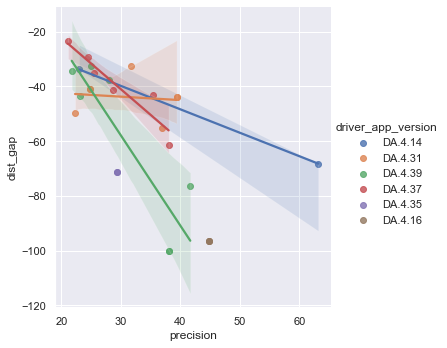

In [105]:
# We look at device models and their precisions.

sns.lmplot(
    data=normalrides_20p_less_100000, x="precision", y="dist_gap", hue="driver_app_version",
)

The rides with driver app versions 4.37 and 4.39 had more precision.

In [106]:
normalrides_20p_less_100000.corr(method='kendall')

metered_price  upfront_price  distance  duration  \
metered_price              1.000000       0.830243  0.302326  0.122093   
upfront_price              0.830243       1.000000  0.180231  0.085683   
distance                   0.302326       0.180231  1.000000  0.168605   
duration                   0.122093       0.085683  0.168605  1.000000   
gps_confidence            -0.010281      -0.052249 -0.400977 -0.236473   
dest_change_number         0.274921       0.279425  0.232625  0.211477   
predicted_distance         0.348837       0.327961  0.651163  0.284884   
predicted_duration         0.151163       0.085683  0.418605  0.598837   
eu_indicator                    NaN            NaN       NaN       NaN   
overpaid_ride_ticket       0.279581       0.187288  0.190623  0.177915   
fraud_score                     NaN            NaN       NaN       NaN   
dist_diff                 -0.052326      -0.221595  0.180233 -0.186047   
time_diff                  0.098837       0.056137 -0.133721  0.546512   
price_diff                -0.383721      -0.576147 -0.023256 -0.063953   
dist_gap                   0.244186       0.091593  0.627907 -0.052326   
precision_acc              0.162791      -0.020682  0.325581  0.122093   
time_gap                   0.040698       0.002955 -0.087209  0.569767   
precision                 -0.162791       0.020682 -0.325581 -0.122093   

                      gps_confidence  dest_change_number  predicted_distance  \
metered_price              -0.010281            0.274921            0.348837   
upfront_price              -0.052249            0.279425            0.327961   
distance                   -0.400977            0.232625            0.651163   
duration                   -0.236473            0.211477            0.284884   
gps_confidence              1.000000           -0.411377           -0.493510   
dest_change_number         -0.411377            1.000000            0.274921   
predicted_distance         -0.493510            0.274921            1.000000   
predicted_duration         -0.472947            0.253773            0.581395   
eu_indicator                     NaN                 NaN                 NaN   
overpaid_ride_ticket       -0.134840            0.554700            0.127082   
fraud_score                      NaN                 NaN                 NaN   
dist_diff                   0.339288           -0.274921           -0.168605   
time_diff                   0.051407            0.148034           -0.040698   
price_diff                  0.236473           -0.274921           -0.232558   
dist_gap                   -0.020563           -0.105739            0.279070   
precision_acc               0.246755           -0.274921            0.069767   
time_gap                    0.092533            0.105739           -0.052326   
precision                  -0.246755            0.274921           -0.069767   

                      predicted_duration  eu_indicator  overpaid_ride_ticket  \
metered_price                   0.151163           NaN              0.279581   
upfront_price                   0.085683           NaN              0.187288   
distance                        0.418605           NaN              0.190623   
duration                        0.598837           NaN              0.177915   
gps_confidence                 -0.472947           NaN             -0.134840   
dest_change_number              0.253773           NaN              0.554700   
predicted_distance              0.581395           NaN              0.127082   
predicted_duration              1.000000           NaN              0.127082   
eu_indicator                         NaN           1.0                   NaN   
overpaid_ride_ticket            0.127082           NaN              1.000000   
fraud_score                          NaN           NaN                   NaN   
dist_diff                      -0.122093           NaN              0.012708   
time_diff                       0.145349           NaN

Metered price correlated more with predicted duration and predicted distance.



In [109]:
normalrides_20p_less_100000.metered_price

198     27435.60
286      8519.18
619     15723.72
667      9902.78
742     17752.64
1180     8474.99
1185     9220.26
1318    12790.50
1335    21150.48
1382    10103.04
1458    13800.00
1763    11466.38
1812    13800.00
2344    14090.28
2458    10974.48
2594     8474.99
2646     8628.13
3101    13800.00
3346     9902.78
3439    12790.50
3552     6670.90
3697     6670.90
3805     9355.02
3841    12659.22
3964    16563.79
4035     8212.02
4191     6709.02
Name: metered_price, dtype: float64

Observed that rides that are 20% or more less than upfront price and with varying distances are filled with metered_price of 6000.

In [114]:
get_sum(rides_20p_less_100000[rides_20p_less_100000.metered_price == 6000])

Precision% for data is:  -59.09869683594785
Distance% for data is:  -95.36346033116094
Duration% for data is:  -85.46552042080098


These rides cost 59% less than predicted, took 95% less distances and 85% less time. They are anomalies and all happened outside the EU. They must have been the result of a malfunction or some differences in unit calculations.

<AxesSubplot:xlabel='precision'>

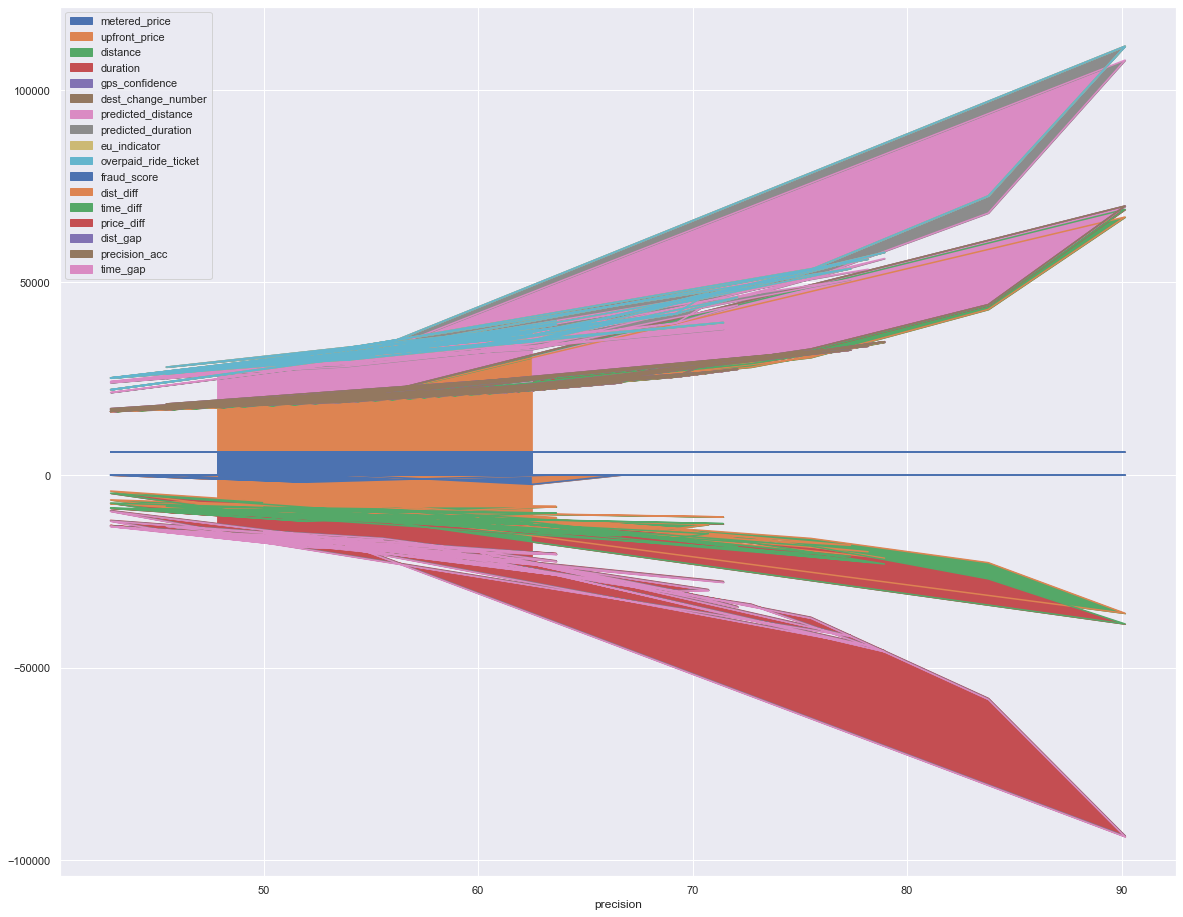

In [118]:
rides_20p_less_100000[rides_20p_less_100000.metered_price == 6000].plot.area('precision')

These rides are anomalies.

<AxesSubplot:xlabel='precision', ylabel='dist_gap'>

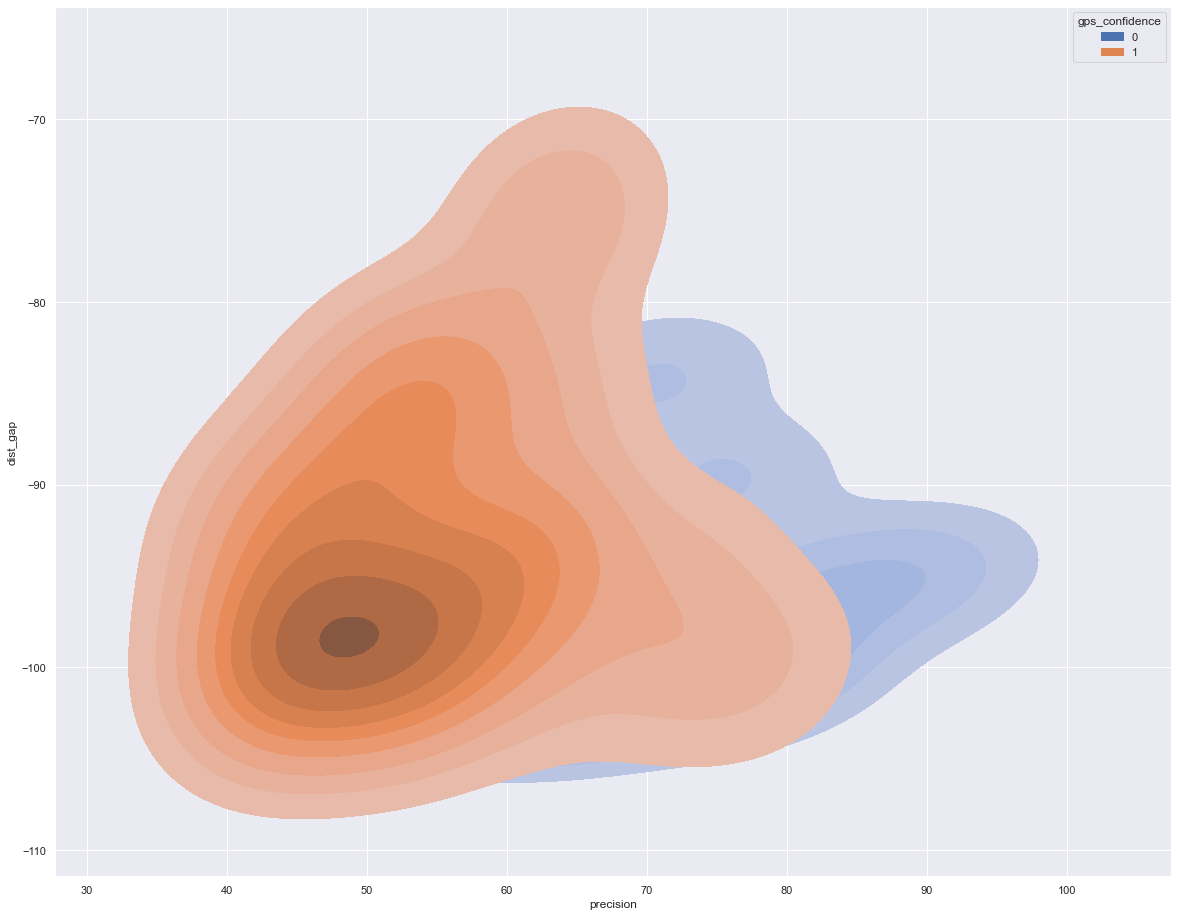

In [121]:
sns.kdeplot(
    data=rides_20p_less_100000[rides_20p_less_100000.metered_price == 6000], x="precision", y="dist_gap", hue="gps_confidence", fill=True,
)

#### Rides costing 10000 to 100000 with metered price at least 20% more than the upfront price

In [123]:
# We isolate these rides
rides_20p_more_threshold_100000 = rides_20p_more_less_than_threshold_100000[rides_20p_more_less_than_threshold_100000['precision_acc'] > 21]

In [124]:
get_sum(rides_20p_more_threshold_100000)

Precision% for data is:  127.43403527022554
Distance% for data is:  89.4796189247256
Duration% for data is:  127.88425303067046


The average ride cost 127% more price, took 89% more distance and 127% more time than predicted. These rides were significantly affected by continous rides so we extract rides with close distances

In [126]:
rides_20p_more_threshold_100000

metered_price  upfront_price  distance  duration  gps_confidence  \
6          20753.20        10500.0     10459      1874               1   
101        30617.50        23000.0     19448      4635               1   
114        59316.78        19500.0     24055     16266               0   
125        20258.93        15500.0      8505      1195               1   
127        51573.74        14000.0     29835      6998               0   
...             ...            ...       ...       ...             ...   
4794       32816.40        14000.0     15332      3797               1   
4817       19831.02        14500.0     13988      3131               1   
4844       20706.01        15000.0     10913      1509               0   
4850       17963.28        11500.0     10658      3747               1   
4942       29244.10        16000.0     17825      4544               1   

     entered_by  dest_change_number prediction_price_type  predicted_distance  \
6        client                   1               upfront              4892.0   
101      client                   1               upfront             17267.0   
114      client                   1               upfront             14707.0   
125      client                   1               upfront              6063.0   
127      client                   1               upfront             10462.0   
...         ...                 ...                   ...                 ...   
4794     client                   1               upfront              6391.0   
4817     client                   1               upfront             10930.0   
4844     client                   1               upfront              7740.0   
4850     client                   1               upfront              7319.0   
4942     client                   2               upfront             12427.0   

      predicted_duration  ... fraud_score       date           time dist_diff  \
6                  698.0  ...         NaN     Sunday  Early Morning    5567.0   
101               2343.0  ...         NaN     Sunday        Morning    2181.0   
114               2605.0  ...         NaN     Friday        Evening    9348.0   
125                873.0  ...         NaN     Friday          Night    2442.0   
127               1642.0  ...         NaN     Sunday  Early Morning   19373.0   
...                  ...  ...         ...        ...            ...       ...   
4794              1207.0  ...         NaN  Wednesday        Morning    8941.0   
4817              1837.0  ...         NaN     Friday           Noon    3058.0   
4844               928.0  ...         NaN     Friday          Night    3173.0   
4850              1746.0  ...         NaN    Tuesday           Noon    3339.0   
4942              1495.0  ...         NaN     Sunday  Early Morning    5398.0   

      time_diff  price_diff    dist_gap precision_acc    time_gap   precision  
6        1176.0    10253.20  113.798038     97.649524  168.481375   97.649524  
101      2292.0     7617.50   12.631030     33.119565   97.823303   33.119565  
114     13661.0    39816.78   63.561569    204.188615  524.414587  204.188615  
125       322.0     4758.93   40.277091     30.702774   36.884307   30.702774  
127      5356.0    37573.74  185.174919    268.383857  326.187576  268.383857  
...         ...         ...         ...           ...         ...         ...  
4794     2590.0    18816.40  139.899859    134.402857  214.581607  134.402857  
4817     1294.0     5331.02   27.978042     36.765655   70.440936   36.765655  
4844      581.0     5706.01   40.994832     38.040067   62.607759   38.040067  
4850     2001.0     6463.28   45.620986     56.202435  114.604811   56.202435  
4942     3049.0    13244.10   43.437676     82.775625  203.946488   82.775625  

[200 rows x 26 columns]

In [127]:
normalrides_20p_more_100000 = rides_20p_more_threshold_100000[rides_20p_more_threshold_100000['dist_gap'] < 21]

In [128]:
# We get the properties.
get_sum(normalrides_20p_more_100000)

Precision% for data is:  35.29535964912374
Distance% for data is:  7.469725873589136
Duration% for data is:  130.39849752204847


Using our 20% threshold, these rides cost 35% more price, took 7% more distance and 130% more time than predicted.

In [ ]:
# Which check the standard deviation of our data to ensure it is reliable

In [140]:
get_std_cv(normalrides_20p_more_100000)

standard_deviation for precision data is:  11.572083860483437
coefficient of variation for precision data is:  0.32786417182097566
standard_deviation for distance data is:  8.707175245554723
coefficient of variation for distance precision data is:  1.1656619523804566
standard_deviation for duration data is:  61.18848764433965
coefficient of variation for duration precision data is:  0.4692422750806126


This shows that our mean calcutions are reliable since the standard deviations are low. Points are closely distributed from the mean.

In [142]:
# We evaluate GPS confidence and impact on rides
print_percentage_differences(normalrides_20p_more_100000,  'gps_confidence')

Precision% for gps_confidence = 0 is:  31.023833805271497
Precision% for gps_confidence = 1 is:  37.8582751554351
Distance% for gps_confidence = 0 is:  3.6421803636898438
Distance% for gps_confidence = 1 is:  9.766253179528713
Duration% for gps_confidence = 0 is:  126.00901593823964
Duration% for gps_confidence = 1 is:  133.0321864723338


For rides with GPS confidence high, average ride cost 37.8% more price, took 9.7% more distance and 133% more time while rides with low confidence cost 31% more price, took 3.6% more distance and 126% more time than predicted.

<AxesSubplot:xlabel='date', ylabel='count'>

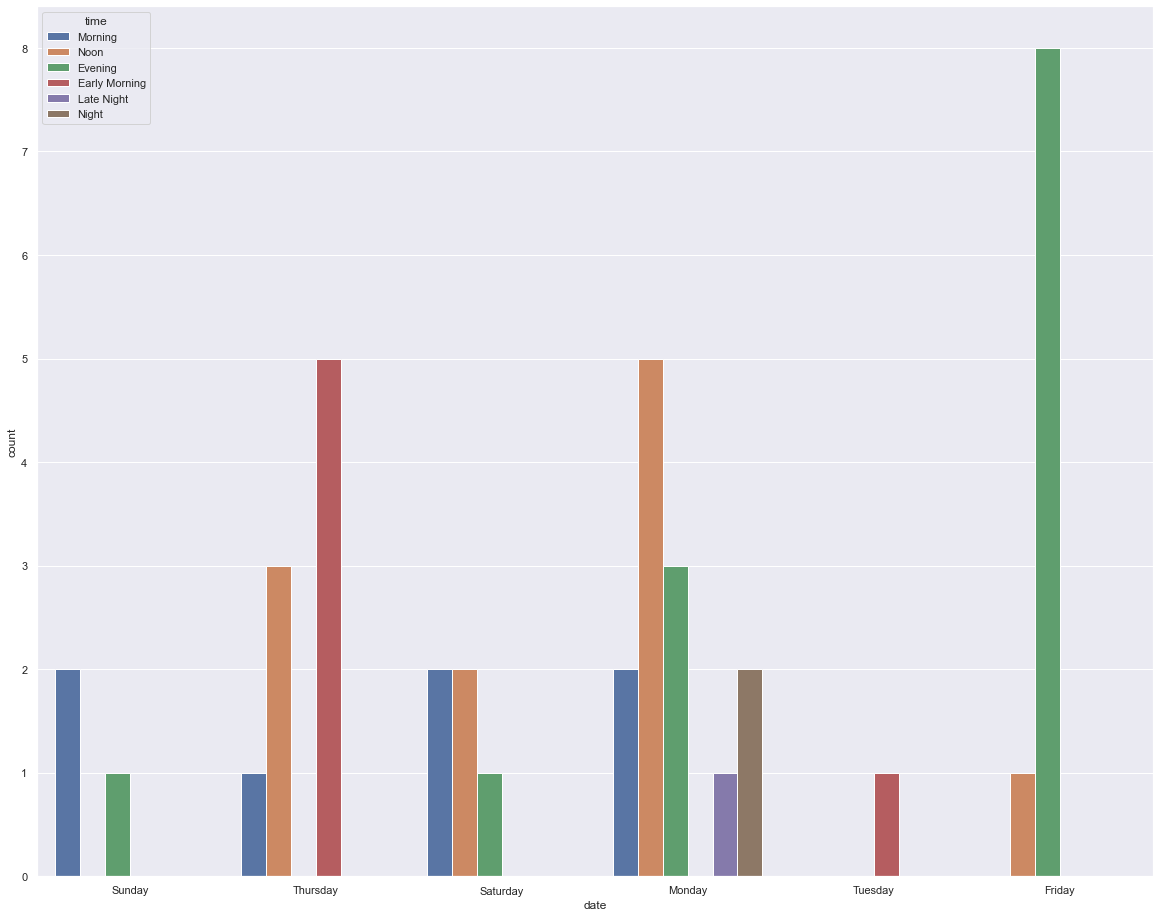

In [144]:
sns.countplot(x='date', data=normalrides_20p_more_100000, hue='time')

More trips happened on weekdays, especially Monday, and between noon and evening.

<AxesSubplot:xlabel='precision', ylabel='Proportion'>

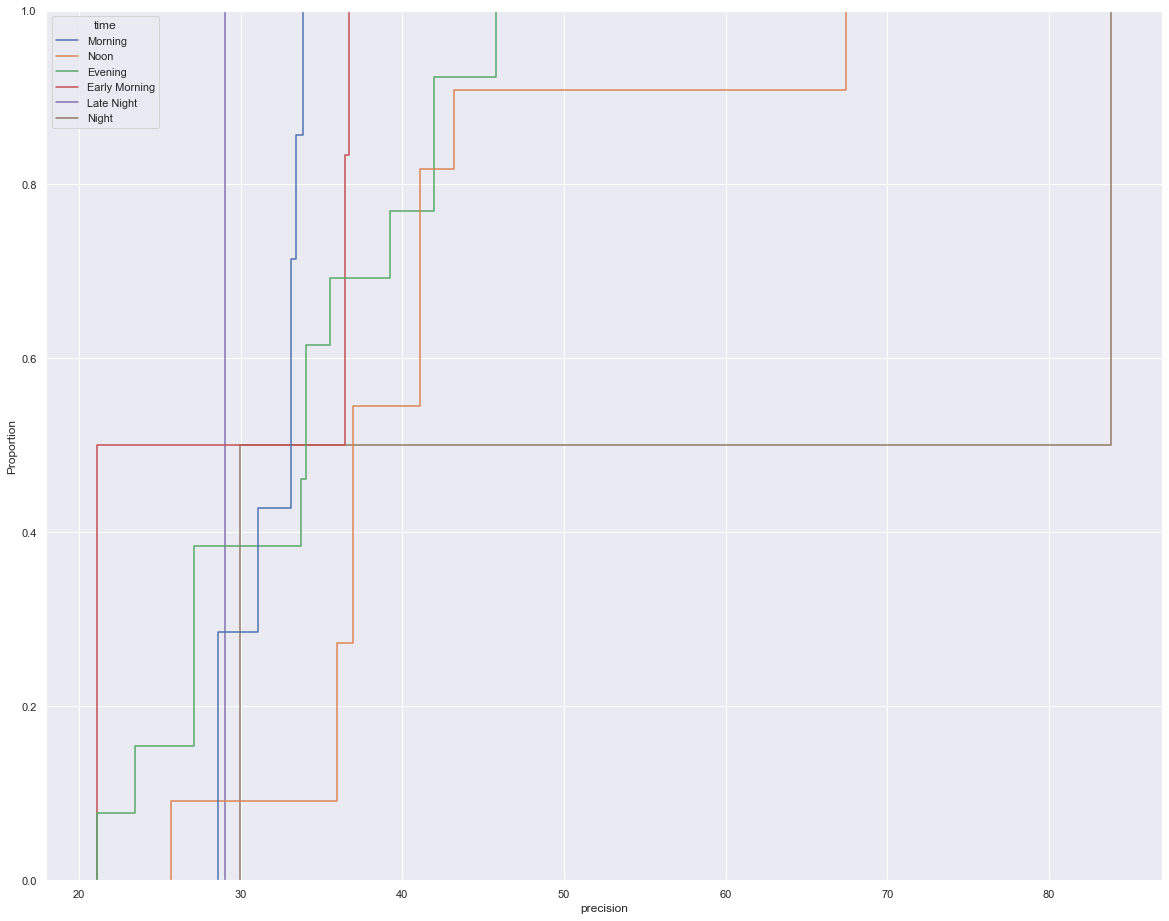

In [152]:
sns.ecdfplot(
    data=normalrides_20p_more_100000, x="precision", hue="time",
)

<AxesSubplot:xlabel='precision', ylabel='Proportion'>

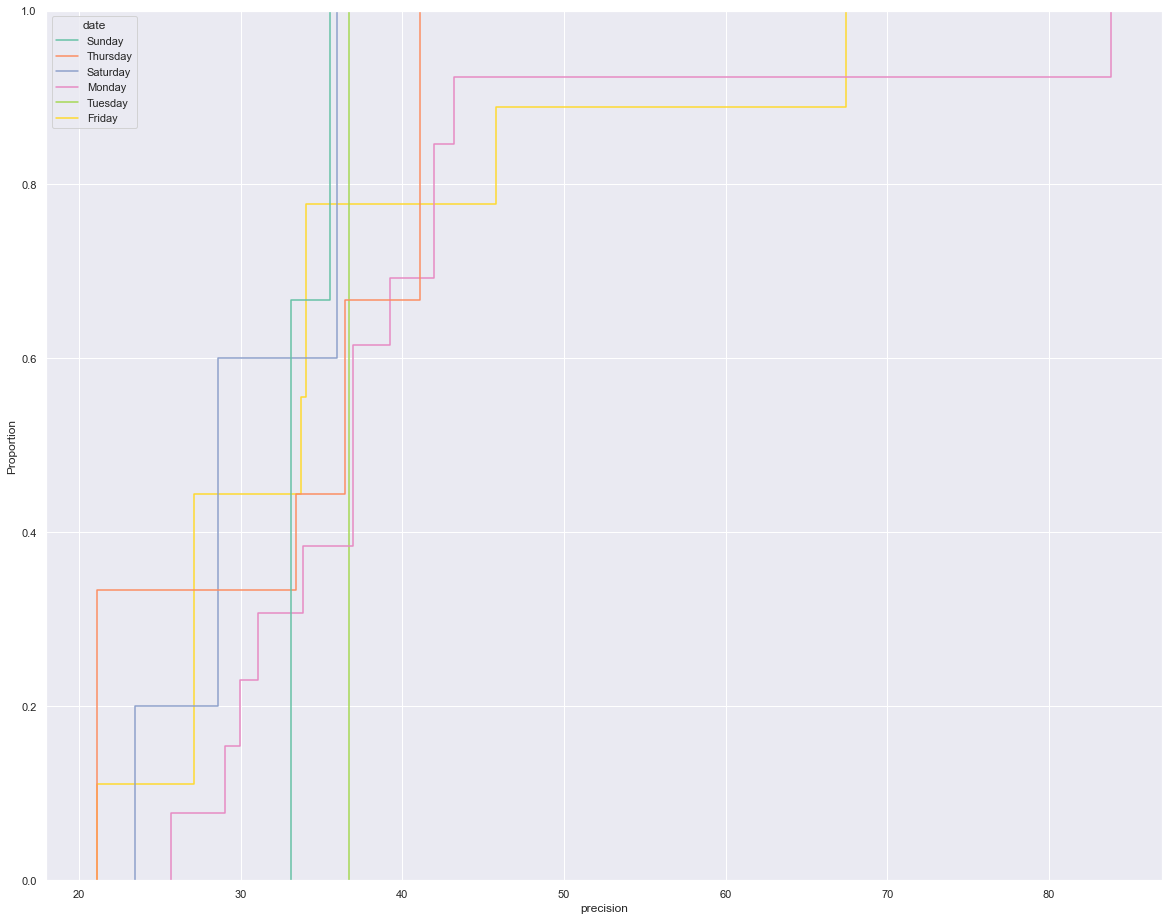

In [154]:
sns.ecdfplot(
    data=normalrides_20p_more_100000, x="precision", hue="date",palette='Set2'
)

The more precise trips happened on Fridays and in the evenings too.

In [155]:
# We evaluate riders who complained about their rides
print_percentage_differences(normalrides_20p_more_100000, 'overpaid_ride_ticket')

Precision% for overpaid_ride_ticket = 0 is:  35.809561158983314
Precision% for overpaid_ride_ticket = 1 is:  25.525530961791837
Distance% for overpaid_ride_ticket = 0 is:  7.769635264497687
Distance% for overpaid_ride_ticket = 1 is:  1.7714474463266674
Duration% for overpaid_ride_ticket = 0 is:  132.16886671744334
Duration% for overpaid_ride_ticket = 1 is:  96.76148280954598


Rides who complained spent 25% more than predicted but covered only 1% more distance. They did however have 96% more time than predicted. All the rides happened in the EU.

<AxesSubplot:>

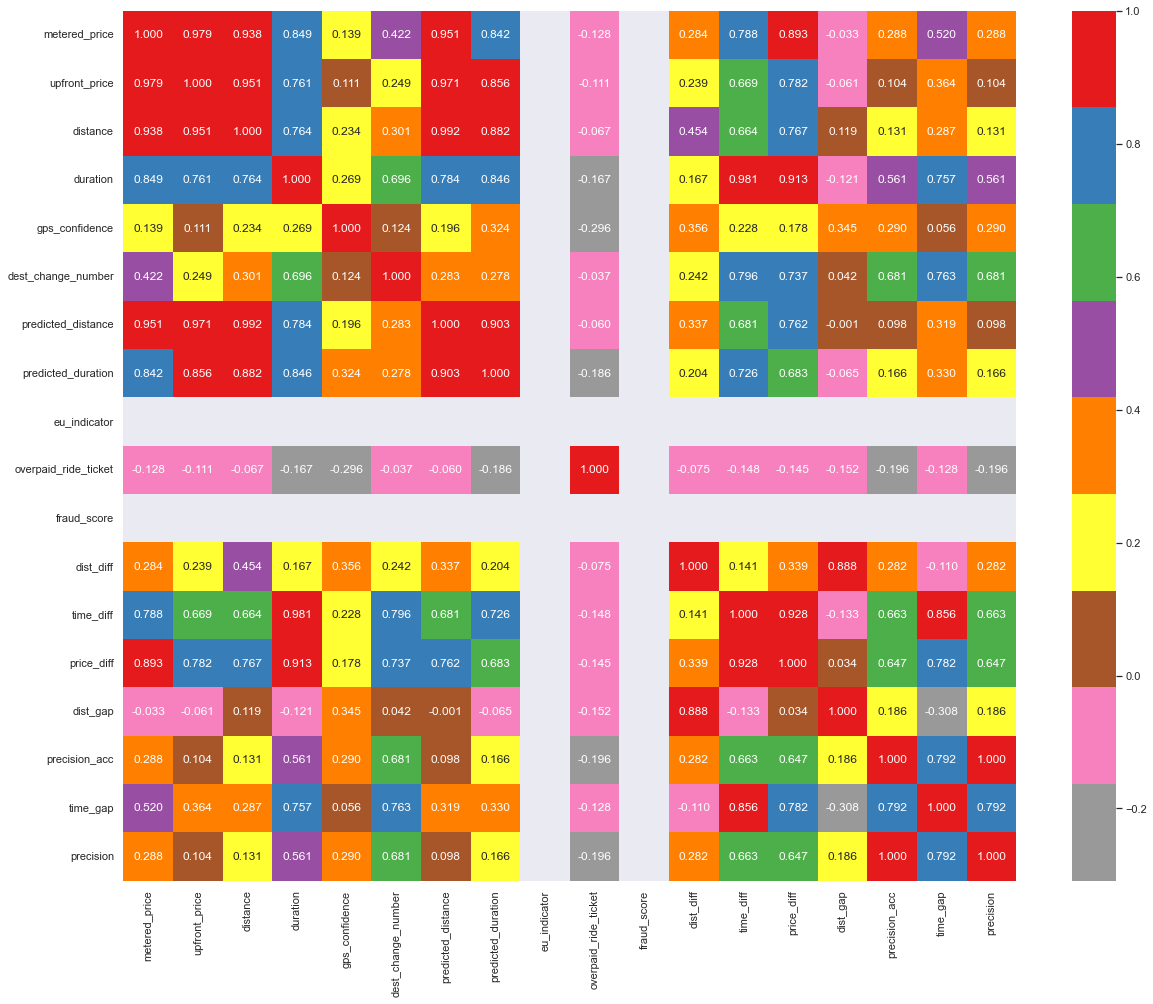

In [157]:
sns.heatmap(normalrides_20p_more_100000.corr(),annot=True,
                 fmt=".3f",
                 cmap = 'Set1_r')

Metered price correlated more with predicted distance

#### Rides exceeding 100000

The sample size was too small. Majority of the rides were finished significantly before they were scheduled to ended so I filtered rides with close distances.

In [158]:
# Rides with close distances.
rides_exceeding_100000 = new[new['upfront_price'] > 100000]


In [159]:
normalrides_exceeding_100000 = rides_exceeding_100000[rides_exceeding_100000['precision'] < 30]

In [160]:
# We evaluate their properties
get_sum(normalrides_exceeding_100000)

Precision% for data is:  -3.352573804712861
Distance% for data is:  -0.24811772709964863
Duration% for data is:  7.81227609212429


The average ride cost 3% less price, took 0.2% less distance and 7% more time than predicted.



In [161]:
get_std_cv(normalrides_exceeding_100000)

standard_deviation for precision data is:  17.45521779842721
coefficient of variation for precision data is:  -5.20651261245603
standard_deviation for distance data is:  16.51441217325616
coefficient of variation for distance precision data is:  -66.55877581299812
standard_deviation for duration data is:  56.86414282603051
coefficient of variation for duration precision data is:  7.2788188941960685


Our data points aren't too far off from the mean except in the duration.

<AxesSubplot:xlabel='precision_acc'>

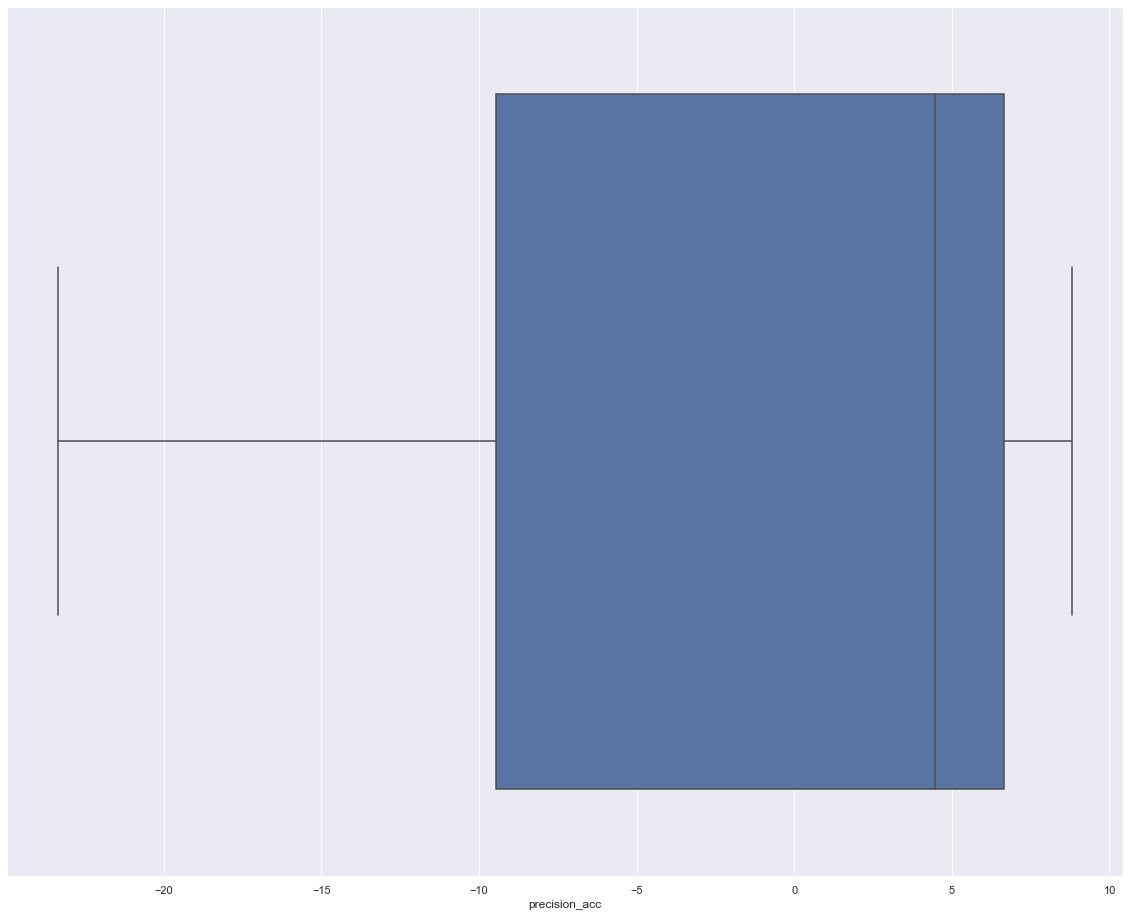

In [165]:
sns.boxplot(x='precision_acc', data=normalrides_exceeding_100000)

<AxesSubplot:xlabel='precision_acc', ylabel='Density'>

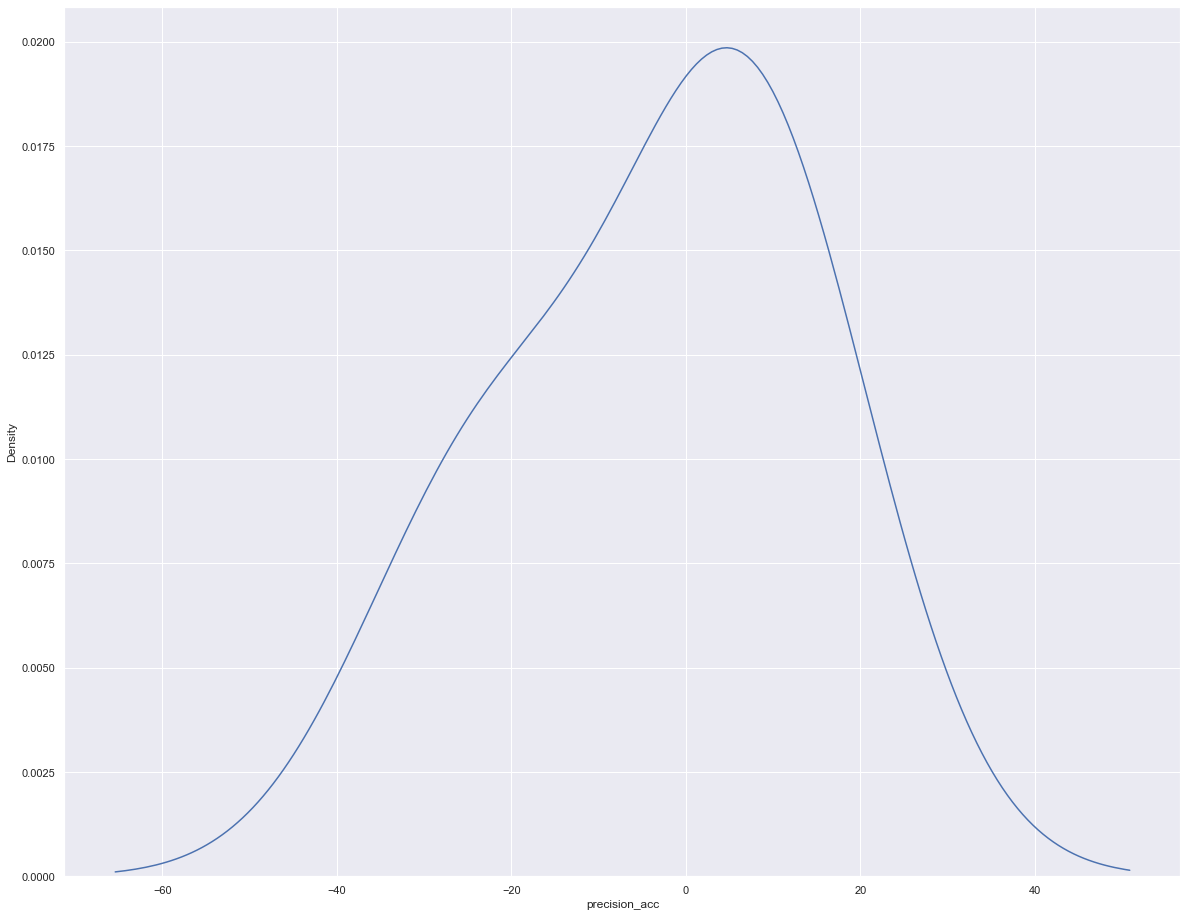

In [166]:
sns.kdeplot(x='precision_acc', data=normalrides_exceeding_100000)

<AxesSubplot:ylabel='precision_acc'>

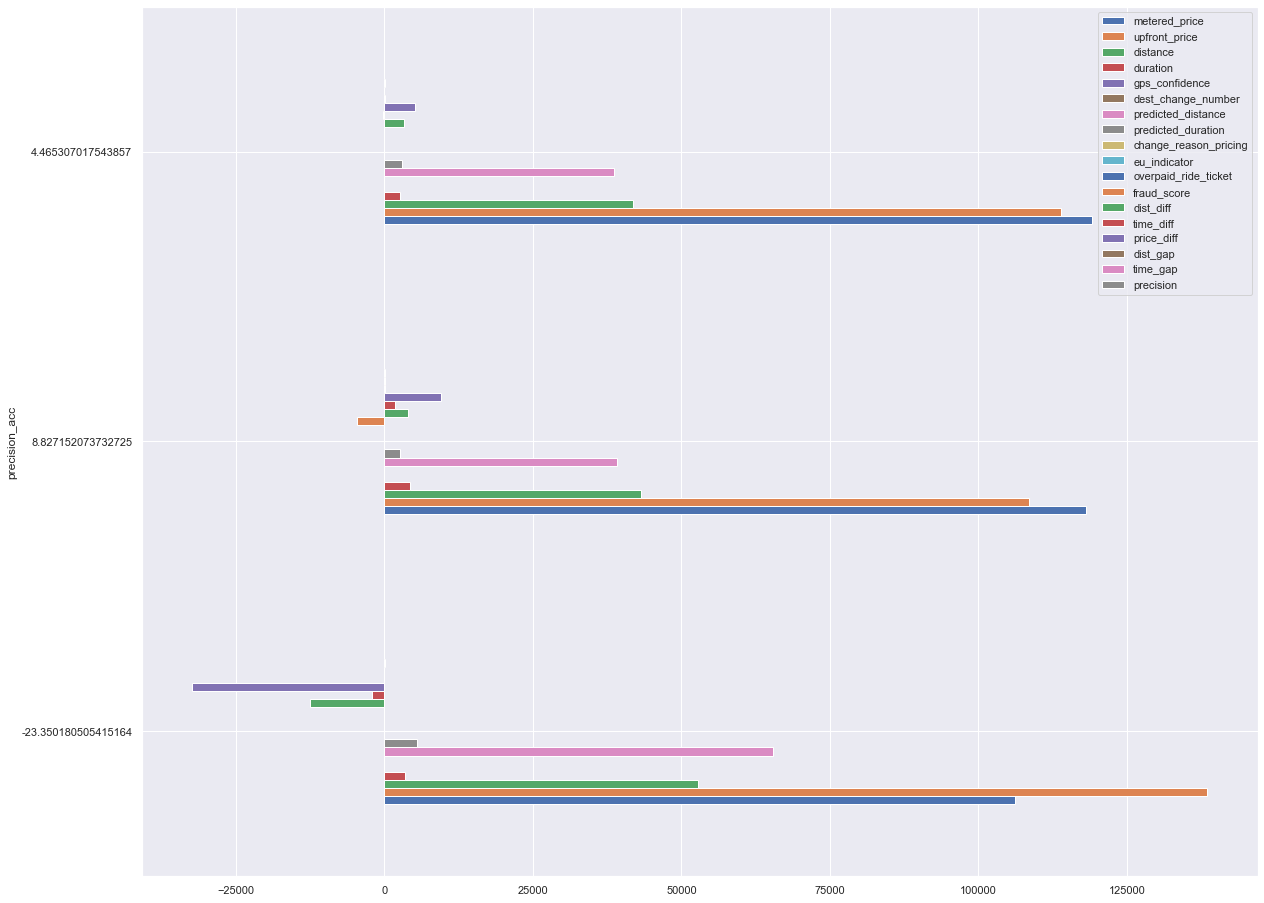

In [174]:
normalrides_exceeding_100000.plot.barh('precision_acc')

In [242]:
clean_data

metered_price  upfront_price  distance  duration  gps_confidence  \
0              4.04           10.0      2839       700               1   
1              6.09            3.6      5698       493               1   
2              4.32            3.5      4426       695               1   
4          20032.50        19500.0     10273      5067               1   
5              6.11            6.3      4924       513               1   
...             ...            ...       ...       ...             ...   
4937           7.01            5.6     10919      1465               1   
4938          10.89           13.7     15672      1449               1   
4940           7.50            7.4      5303       486               1   
4941           3.06            8.1      3528       338               1   
4942       29244.10        16000.0     17825      4544               1   

     entered_by  dest_change_number prediction_price_type  predicted_distance  \
0        client                   1               upfront             13384.0   
1        client                   1               upfront              2286.0   
2        client                   1               upfront              4101.0   
4        client                   1               upfront             14236.0   
5        client                   1               upfront              4882.0   
...         ...                 ...                   ...                 ...   
4937     client                   1               upfront              9022.0   
4938     client                   1               upfront             16172.0   
4940     client                   1               upfront              5141.0   
4941     client                   1               upfront              8143.0   
4942     client                   2               upfront             12427.0   

      predicted_duration  ... fraud_score      date           time dist_diff  \
0                 1091.0  ...     -1383.0    Sunday     Late Night  -10545.0   
1                  360.0  ...         NaN  Saturday     Late Night    3412.0   
2                  433.0  ...      -166.0  Saturday        Morning     325.0   
4                 2778.0  ...         NaN  Thursday        Evening   -3963.0   
5                  562.0  ...         NaN    Friday     Late Night      42.0   
...                  ...  ...         ...       ...            ...       ...   
4937              1029.0  ...        -4.0  Thursday  Early Morning    1897.0   
4938              1691.0  ...      -286.0  Saturday        Evening    -500.0   
4940               498.0  ...      -192.0  Thursday          Night     162.0   
4941               768.0  ...      -228.0    Sunday        Evening   -4615.0   
4942              1495.0  ...         NaN    Sunday  Early Morning    5398.0   

      time_diff  price_diff    dist_gap precision_acc    time_gap  precision  
0        -391.0       -5.96  -78.788105    -59.600000  -35.838680  59.600000  
1         133.0        2.49  149.256343     69.166667   36.944444  69.166667  
2         262.0        0.82    7.924896     23.428571   60.508083  23.428571  
4        2289.0      532.50  -27.837876      2.730769   82.397408   2.730769  
5         -49.0       -0.19    0.860303     -3.015873   -8.718861   3.015873  
...         ...         ...         ...           ...         ...        ...  
4937      436.0        1.41   21.026380     25.178571   42.371234  25.178571  
4938     -242.0       -2.81   -3.091764    -20.510949  -14.311059  20.510949  
4940      -12.0        0.10    3.151138      1.351351   -2.409639   1.351351  
4941     -430.0       -5.04  -56.674444    -62.222222  -55.989583  62.222222  
4942     3049.0    13244.10   43.437676     82.775625  203.946488  82.775625  

[3409 rows x 26 columns]

In [245]:
new.upfront_price.sum()

14181766.4

In [246]:
new.metered_price.sum()

39376474.19

In [257]:
(new.metered_price.sum()) - (new.upfront_price.sum())

25194707.79

In [253]:
new[new['eu_indicator'] == 1].metered_price.sum()

21015.949999999997

In [255]:
new

metered_price  upfront_price  distance  duration  gps_confidence  \
0              4.04           10.0      2839       700               1   
1              6.09            3.6      5698       493               1   
2              4.32            3.5      4426       695               1   
3          72871.72            NaN     49748      1400               0   
4          20032.50        19500.0     10273      5067               1   
...             ...            ...       ...       ...             ...   
4938          10.89           13.7     15672      1449               1   
4939        8789.28            NaN      5712      1173               0   
4940           7.50            7.4      5303       486               1   
4941           3.06            8.1      3528       338               1   
4942       29244.10        16000.0     17825      4544               1   

     entered_by  dest_change_number        prediction_price_type  \
0        client                   1                      upfront   
1        client                   1                      upfront   
2        client                   1                      upfront   
3        client                   2  upfront_destination_changed   
4        client                   1                      upfront   
...         ...                 ...                          ...   
4938     client                   1                      upfront   
4939     client                   1                   prediction   
4940     client                   1                      upfront   
4941     client                   1                      upfront   
4942     client                   2                      upfront   

      predicted_distance  predicted_duration  ... fraud_score       date  \
0                13384.0              1091.0  ...     -1383.0     Sunday   
1                 2286.0               360.0  ...         NaN   Saturday   
2                 4101.0               433.0  ...      -166.0   Saturday   
3                 3017.0               600.0  ...         NaN  Wednesday   
4                14236.0              2778.0  ...         NaN   Thursday   
...                  ...                 ...  ...         ...        ...   
4938             16172.0              1691.0  ...      -286.0   Saturday   
4939              5712.0              1093.0  ...         NaN   Saturday   
4940              5141.0               498.0  ...      -192.0   Thursday   
4941              8143.0               768.0  ...      -228.0     Sunday   
4942             12427.0              1495.0  ...         NaN     Sunday   

               time dist_diff  time_diff  price_diff     dist_gap  \
0        Late Night  -10545.0     -391.0       -5.96   -78.788105   
1        Late Night    3412.0      133.0        2.49   149.256343   
2           Morning     325.0      262.0        0.82     7.924896   
3     Early Morning   46731.0      800.0         NaN  1548.922771   
4           Evening   -3963.0     2289.0      532.50   -27.837876   
...             ...       ...        ...         ...          ...   
4938        Evening    -500.0     -242.0       -2.81    -3.091764   
4939        Evening       0.0       80.0         NaN     0.000000   
4940          Night     162.0      -12.0        0.10     3.151138   
4941        Evening   -4615.0     -430.0       -5.04   -56.674444   
4942  Early Morning    5398.0     3049.0    13244.10    43.437676   

     precision_acc    time_gap  precision  
0       -59.600000  -35.838680  59.600000  
1        69.166667   36.944444  69.166667  
2        23.428571   60.508083  23.428571  
3              NaN  133.333333        NaN  
4         2.730769   82.397408   2.730769  
...            ...         ...        ...  
4938    -20.510949  -14.311059  20.510949  
4939           NaN    7.319305        NaN  
4940      1.351351   -2.409639   1.351351  
4941    -62.222222  -55.989583  62.222222  
4942     82.775625  203.946488  82.775625  

[4943 rows x 26 columns]